In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns        
import matplotlib.pyplot as plt 
import statsmodels.api as sm

In [2]:
df_1=pd.read_parquet(
    "/Users/danielmunoz/Documents/EDUCACION/DATA_ANALIST/CURSOS/TFM/DATA/PROCESSED/df_YouTube_2025TFM.parquet")

In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19154 entries, 0 to 19153
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                19154 non-null  object 
 1   title                   19154 non-null  object 
 2   description             15337 non-null  object 
 3   published_at            19154 non-null  object 
 4   duration_minutes        19154 non-null  float64
 5   definition              19154 non-null  int64  
 6   licensed_content        19154 non-null  Int64  
 7   has_caption             19154 non-null  Int64  
 8   category_id             19154 non-null  float64
 9   views                   19154 non-null  int64  
 10  likes                   19154 non-null  int64  
 11  comments                19154 non-null  int64  
 12  tags                    10706 non-null  object 
 13  tags_count              19154 non-null  int64  
 14  views_per_day           19154 non-null

# VIDEO 

##	Detectar vídeos con muchas visitas pero bajo engagement (o al revés).

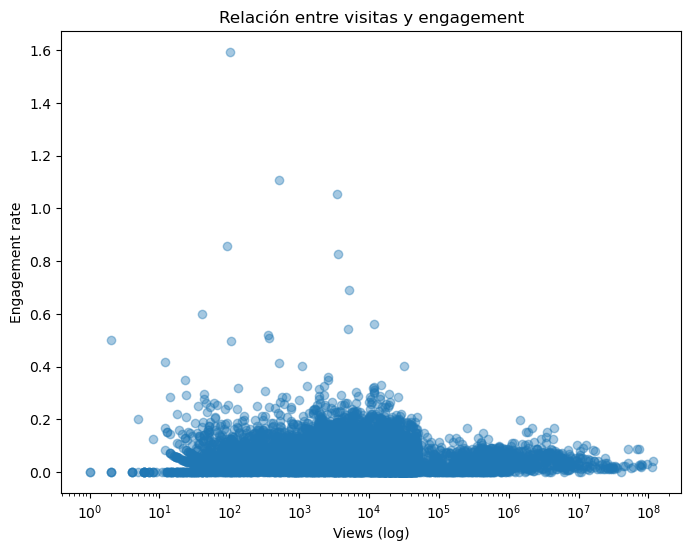

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(df_1["views"], df_1["engagement_rate"], alpha=0.4)
plt.xscale("log")  # escala logarítmica para las views (mejor visibilidad)
plt.xlabel("Views (log)")
plt.ylabel("Engagement rate")
plt.title("Relación entre visitas y engagement")
plt.show()

In [5]:
low_engagement = df_1.sort_values(["views", "engagement_rate"], ascending=[False, True]).head(10)
print(low_engagement[["title", "views", "likes", "comments", "engagement_rate"]])

                                                   title      views    likes  \
19073                        Lose 100 LBs, Win $250,000!  117021679  4720783   
18854                   Who was faster? 😳😱 @isabellaafro  114183096  2257219   
18024  Survive 100 Days Trapped In A Private Jet, Kee...   95218846  2775236   
18227               What's The Sharpest homemade Katana?   80404874  2129981   
19048                    World's Fastest Car Vs Cheetah!   77658950  2370815   
18140                Which Shoes Will Protect Your Feet?   77112145  1623066   
18097                            If You Spill, You Lose!   75908720  1870536   
18539                   When the toilet occupied! 🚽🧜🏻‍♀️   73759375  6416885   
18193                Which Shoes Will Protect Your Feet?   73468178  1865219   
18414                   When the toilet occupied! 🚽🧜🏻‍♀️   68746871  6095944   

       comments  engagement_rate  
19073     74447         0.040977  
18854      6562         0.019826  
18024     3609

In [6]:
# ==========================
# 1. Calcular percentiles
# ==========================
views_p25, views_p75 = df_1["views"].quantile([0.25, 0.75])
eng_p25, eng_p75     = df_1["engagement_rate"].quantile([0.25, 0.75])

views_p5, views_p95  = df_1["views"].quantile([0.05, 0.95])
eng_p5, eng_p95      = df_1["engagement_rate"].quantile([0.05, 0.95])

# ==========================
# 2. Función de clasificación
# ==========================
def categorize(row):
    v, e = row["views"], row["engagement_rate"]

    # Extremos 5%
    if v <= views_p5 and e <= eng_p5:
        return "LowLow (≤5%)"
    if v >= views_p95 and e >= eng_p95:
        return "HighHigh (≥95%)"

    # Cuadrantes amplios (25/75)
    if v >= views_p75 and e >= eng_p75:
        return "High Views & High Engagement"
    elif v >= views_p75 and e <= eng_p25:
        return "High Views & Low Engagement"
    elif v <= views_p25 and e >= eng_p75:
        return "Low Views & High Engagement"
    elif v <= views_p25 and e <= eng_p25:
        return "Low Views & Low Engagement"

    # En el medio
    return "Middle"

# ==========================
# 3. Aplicar al DataFrame
# ==========================
df_1["quadrant"] = df_1.apply(categorize, axis=1)

# ==========================
# 4. Resumen
# ==========================
print(df_1["quadrant"].value_counts())

quadrant
Middle                          14184
High Views & Low Engagement      1632
Low Views & High Engagement      1311
Low Views & Low Engagement       1136
High Views & High Engagement      716
LowLow (≤5%)                      165
HighHigh (≥95%)                    10
Name: count, dtype: int64


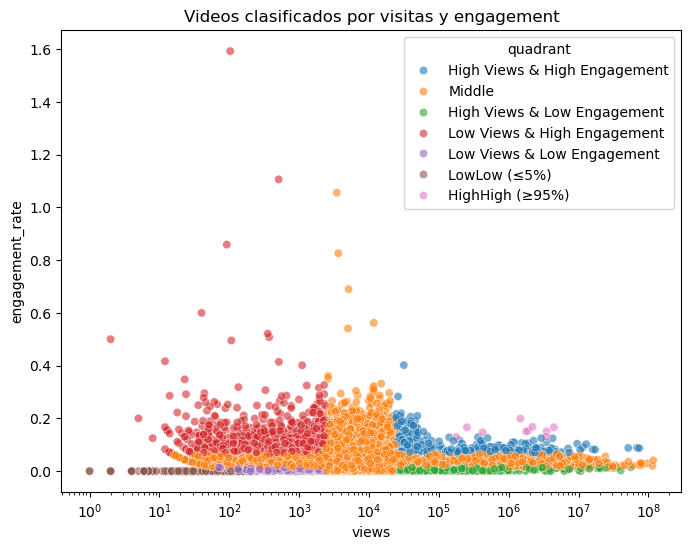

In [7]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_1, x="views", y="engagement_rate",
    hue="quadrant", alpha=0.6
)
plt.xscale("log")
plt.title("Videos clasificados por visitas y engagement")
plt.show()

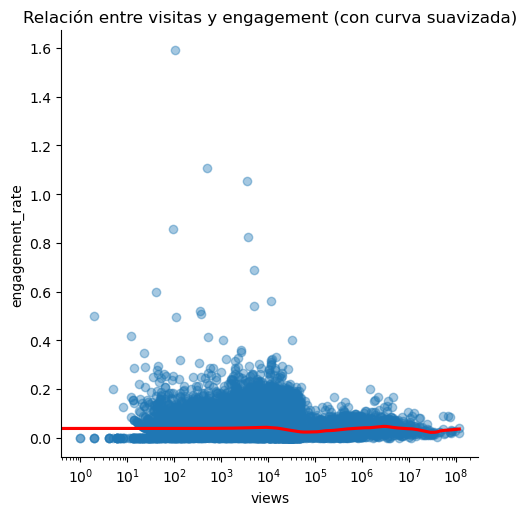

Videos con más engagement del esperado:
                                                    title  views  \
1442   Pocket Option Estrategia | ¿Cómo convertí 30 d...    103   
544    El RETO de la IA: Cómo APROVECHARLA sin ROMPER...    509   
7713   CÓMO UN NIÑO DE GUERRA CONSTRUYÓ EL IMPERIO DE...   3449   
12518   Opciones Binarias | ¿Cómo convertí $75 en $3757?     92   
14497  ¿Cómo Convertirse en una SIRENA Popular? De Ne...   3632   
11026  BARBIE vs BRATZ Makeover Extremo de Sirena! ¿C...   5102   
14030  Cómo gané la apelación de YouTube y logré mone...     40   
7592   Cambio De Imagen Extremo De NERD a Chica POPUL...  11694   
4066   Mono Baba, Pobre vs. Rico | Cómo conseguir más...   5002   
9886   ¿Cómo se hace cada día el canal Un minuto ju...    355   

       engagement_rate     resid  
1442          1.592233  1.536550  
544           1.106090  1.053908  
7713          1.055668  1.007694  
12518         0.858696  0.802767  
14497         0.825716  0.777856  
11026      

In [8]:


# scatter con curva suavizada
sns.lmplot(
    data=df_1, x="views", y="engagement_rate",
    lowess=True, scatter_kws={"alpha":0.4}, line_kws={"color":"red"}
)
plt.xscale("log")
plt.title("Relación entre visitas y engagement (con curva suavizada)")
plt.show()

# regresión log-views vs engagement_rate para detectar outliers

X = np.log1p(df_1["views"])
y = df_1["engagement_rate"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
df_1["resid"] = model.resid

# top extremos
top_pos = df_1.nlargest(10, "resid")[["title","views","engagement_rate","resid"]]
top_neg = df_1.nsmallest(10, "resid")[["title","views","engagement_rate","resid"]]

print("Videos con más engagement del esperado:\n", top_pos)
print("\nVideos con menos engagement del esperado:\n", top_neg)

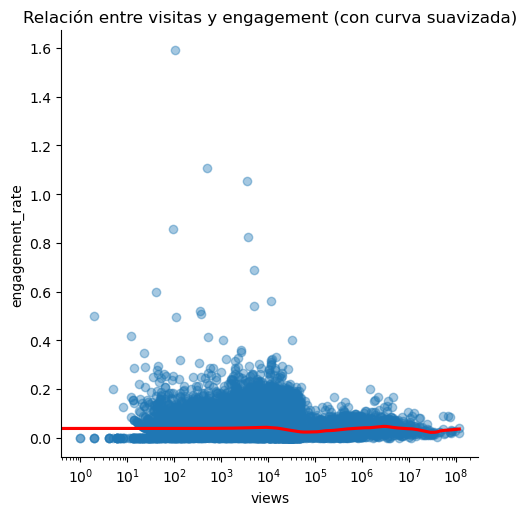

Videos con más engagement del esperado:
                                                    title  views  \
1442   Pocket Option Estrategia | ¿Cómo convertí 30 d...    103   
544    El RETO de la IA: Cómo APROVECHARLA sin ROMPER...    509   
7713   CÓMO UN NIÑO DE GUERRA CONSTRUYÓ EL IMPERIO DE...   3449   
12518   Opciones Binarias | ¿Cómo convertí $75 en $3757?     92   
14497  ¿Cómo Convertirse en una SIRENA Popular? De Ne...   3632   
11026  BARBIE vs BRATZ Makeover Extremo de Sirena! ¿C...   5102   
14030  Cómo gané la apelación de YouTube y logré mone...     40   
7592   Cambio De Imagen Extremo De NERD a Chica POPUL...  11694   
4066   Mono Baba, Pobre vs. Rico | Cómo conseguir más...   5002   
9886   ¿Cómo se hace cada día el canal Un minuto ju...    355   

       engagement_rate     resid  
1442          1.592233  1.536550  
544           1.106090  1.053908  
7713          1.055668  1.007694  
12518         0.858696  0.802767  
14497         0.825716  0.777856  
11026      

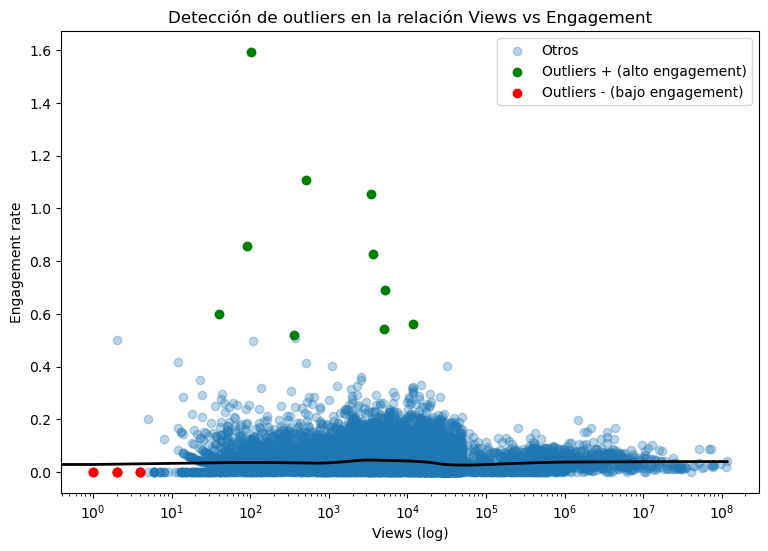

In [9]:
sns.lmplot(
    data=df_1, x="views", y="engagement_rate",
    lowess=True,
    scatter_kws={"alpha":0.4},
    line_kws={"color":"red"}
)
plt.xscale("log")
plt.title("Relación entre visitas y engagement (con curva suavizada)")
plt.show()

# ===========================
# 3. Ajustar modelo lineal simple
# ===========================
X = np.log1p(df_1["views"])   # log(views+1) para estabilizar escala
y = df_1["engagement_rate"]

X = sm.add_constant(X)
ols_model = sm.OLS(y, X).fit()

df_1["resid"] = ols_model.resid

# ===========================
# 4. Detectar outliers
# ===========================
top_pos = df_1.nlargest(10, "resid")[["title", "views", "engagement_rate", "resid"]]
top_neg = df_1.nsmallest(10, "resid")[["title", "views", "engagement_rate", "resid"]]

print("Videos con más engagement del esperado:\n", top_pos)
print("\nVideos con menos engagement del esperado:\n", top_neg)

# ===========================
# 5. Scatter coloreando outliers
# ===========================
plt.figure(figsize=(9,6))
plt.scatter(df_1["views"], df_1["engagement_rate"], alpha=0.3, label="Otros")
plt.scatter(top_pos["views"], top_pos["engagement_rate"], color="green", label="Outliers + (alto engagement)")
plt.scatter(top_neg["views"], top_neg["engagement_rate"], color="red", label="Outliers - (bajo engagement)")

# Curva LOWESS para referencia
from statsmodels.nonparametric.smoothers_lowess import lowess
lowess_curve = lowess(y, np.log1p(df_1["views"]), frac=0.3)
plt.plot(np.expm1(lowess_curve[:,0]), lowess_curve[:,1], color="black", linewidth=2)

plt.xscale("log")
plt.xlabel("Views (log)")
plt.ylabel("Engagement rate")
plt.title("Detección de outliers en la relación Views vs Engagement")
plt.legend()
plt.show()

### Análisis de outliers en la relación entre visitas y engagement

Para comprender mejor cómo se relacionan las visitas (`views`) con la tasa de engagement 
(definida como `(likes + comments) / views`), se ha representado un scatterplot en escala logarítmica 
junto con una curva suavizada (LOWESS).

La curva muestra la tendencia general: a medida que aumentan las visitas, 
el engagement relativo tiende a decrecer.

Para identificar vídeos que se desvían claramente de esta tendencia, 
se ajustó un modelo lineal simple entre `log(views)` y `engagement_rate`. 
A partir de este modelo se calcularon **residuos**: 

- Valores **positivos grandes** → vídeos con más engagement del esperado dado su nivel de visitas.  
- Valores **negativos grandes** → vídeos con menos engagement del esperado.

En el gráfico se destacan:
- **Verde**: vídeos con un engagement significativamente mayor de lo esperado (outliers positivos).  
- **Rojo**: vídeos con engagement significativamente menor (outliers negativos).  
- **Negro**: la curva de tendencia estimada (LOWESS).  

Este análisis permite no solo clasificar vídeos en “altas/bajas visitas y engagement” 
sino también detectar casos **anómalos y relevantes para explicar la viralidad**.

In [10]:
df_1['published_at']


0        2025-08-11T01:30:22Z
1        2025-08-10T22:55:33Z
2        2025-08-10T22:00:03Z
3        2025-08-10T16:45:04Z
4        2025-08-10T14:08:00Z
                 ...         
19149    2025-09-01T16:00:13Z
19150    2025-09-01T18:08:06Z
19151    2025-09-01T19:00:44Z
19152    2025-09-01T22:23:25Z
19153    2025-09-01T16:55:57Z
Name: published_at, Length: 19154, dtype: object

In [11]:
df_1["published_at"] = pd.to_datetime(df_1["published_at"], utc=True)
df_1["hour"] = df_1["published_at"].dt.hour
df_1["dayofweek"] = df_1["published_at"].dt.day_name()  # 'Monday', 'Tuesday', etc.
df_1["month"] = df_1["published_at"].dt.month

In [12]:
# engagement rate
df_1["engagement_rate"] = (df_1["likes"] + df_1["comments"]) / df_1["views"].replace(0, np.nan)

# promedio por hora
views_by_hour = df_1.groupby("hour")["views"].mean()
eng_by_hour   = df_1.groupby("hour")["engagement_rate"].mean()

# promedio por día de semana
views_by_day = df_1.groupby("dayofweek")["views"].mean()
eng_by_day   = df_1.groupby("dayofweek")["engagement_rate"].mean()

In [13]:
#####!!!! DIFICIL PONER EN PERSPETICA LA HORA PUBLICACIÓN PUESTO QUE VARIA EN FUNCION DEL PAIS 
# fig, ax1 = plt.subplots(figsize=(10,5))

# ax1.plot(views_by_hour.index, views_by_hour.values, marker="o", label="Views promedio")
# ax1.set_xlabel("Hora de publicación")
# ax1.set_ylabel("Views (media)", color="blue")
# ax1.tick_params(axis="y", labelcolor="blue")

# ax2 = ax1.twinx()
# ax2.plot(eng_by_hour.index, eng_by_hour.values, marker="s", color="red", label="Engagement rate promedio")
# ax2.set_ylabel("Engagement rate", color="red")
# ax2.tick_params(axis="y", labelcolor="red")

# plt.title("Views y engagement según hora de publicación")
# plt.show()

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/1287814216.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  views_by_day = df_1.groupby("dayofweek")["views"].mean()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/1287814216.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eng_by_day   = df_1.groupby("dayofweek")["engagement_rate"].mean()


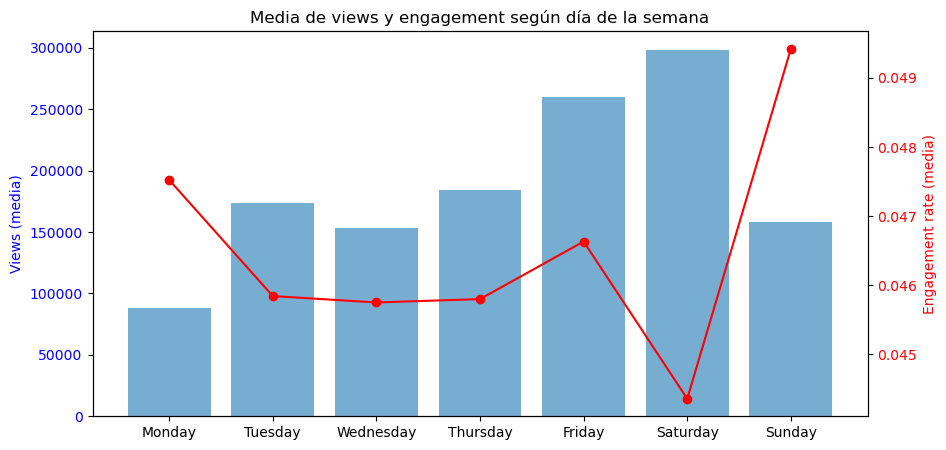

In [14]:
# Definir orden correcto de los días
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convertir columna a categórica ordenada
df_1["dayofweek"] = pd.Categorical(df_1["published_at"].dt.day_name(),
                                   categories=day_order,
                                   ordered=True)

# Recalcular agregados respetando el orden
views_by_day = df_1.groupby("dayofweek")["views"].mean()
eng_by_day   = df_1.groupby("dayofweek")["engagement_rate"].mean()

# === Visualización ===
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.bar(views_by_day.index, views_by_day.values, alpha=0.6, label="Views promedio")
ax1.set_ylabel("Views (media)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(eng_by_day.index, eng_by_day.values, marker="o", color="red", label="Engagement rate promedio")
ax2.set_ylabel("Engagement rate (media)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Media de views y engagement según día de la semana")
plt.xticks(rotation=45)
plt.show()

### Influencia del tiempo de publicación en el rendimiento

Se analizó el campo `published_at`, transformándolo a formato datetime y extrayendo
la hora, el día de la semana y el mes de publicación.

A partir de ello se calcularon los **promedios de visitas y engagement rate** **Por día de la semana**: 
Este enfoque permite responder preguntas como:
Las tendencias de visionado van en aumento del miercoles al sábado; mientras que el engagement aumenta del asbado al domingo, con una fuerte caida del vierne al sabado, aunque solo es de un 0,01

Los resultados pueden orientar recomendaciones sobre **cuándo publicar** para maximizar alcance y participación.

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/3248172904.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  views_by_day = df_1.groupby("dayofweek")["views"].mean()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/3248172904.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eng_by_day   = df_1.groupby("dayofweek")["comments"].mean()


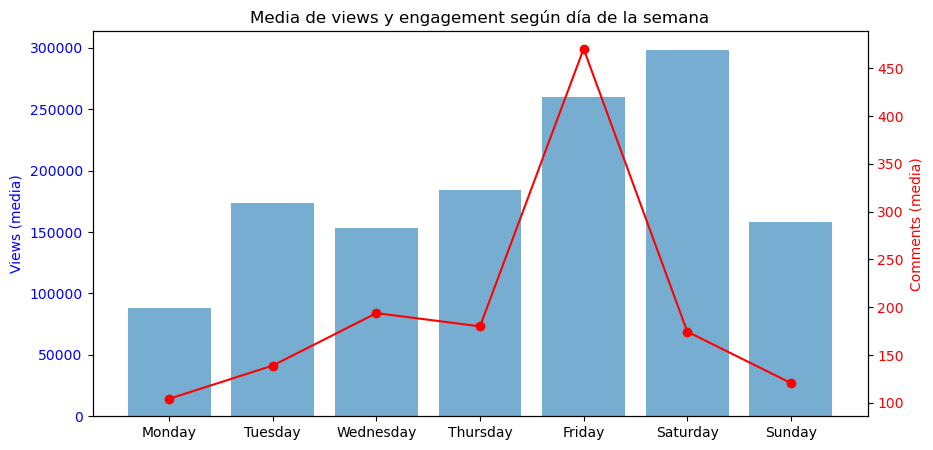

In [15]:
# Definir orden correcto de los días
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convertir columna a categórica ordenada
df_1["dayofweek"] = pd.Categorical(df_1["published_at"].dt.day_name(),
                                   categories=day_order,
                                   ordered=True)

# Recalcular agregados respetando el orden
views_by_day = df_1.groupby("dayofweek")["views"].mean()
eng_by_day   = df_1.groupby("dayofweek")["comments"].mean()

# === Visualización ===
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.bar(views_by_day.index, views_by_day.values, alpha=0.6, label="Views promedio")
ax1.set_ylabel("Views (media)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(eng_by_day.index, eng_by_day.values, marker="o", color="red", label="Comments, promedio")
ax2.set_ylabel("Comments (media)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Media de views y engagement según día de la semana")
plt.xticks(rotation=45)
plt.show()

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/515290537.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  views_by_day = df_1.groupby("dayofweek")["views"].mean()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/515290537.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eng_by_day   = df_1.groupby("dayofweek")["likes"].mean()


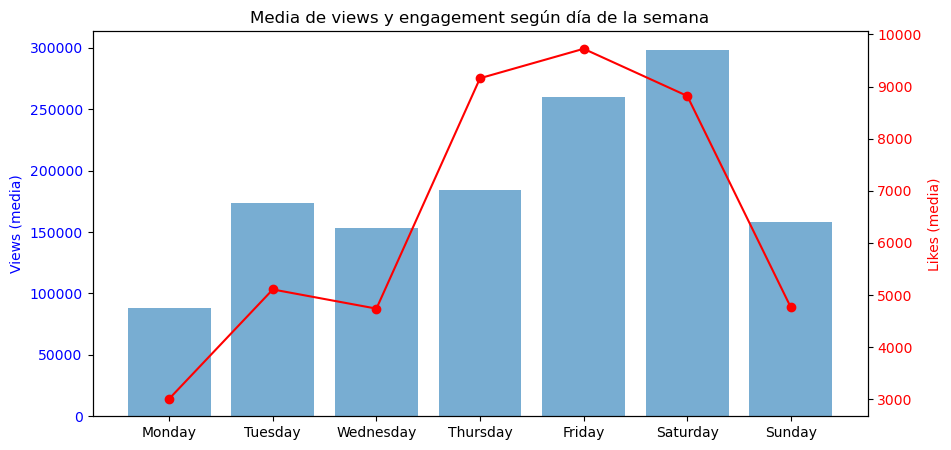

In [16]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convertir columna a categórica ordenada
df_1["dayofweek"] = pd.Categorical(df_1["published_at"].dt.day_name(),
                                   categories=day_order,
                                   ordered=True)

# Recalcular agregados respetando el orden
views_by_day = df_1.groupby("dayofweek")["views"].mean()
eng_by_day   = df_1.groupby("dayofweek")["likes"].mean()

# === Visualización ===
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.bar(views_by_day.index, views_by_day.values, alpha=0.6, label="Views promedio")
ax1.set_ylabel("Views (media)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(eng_by_day.index, eng_by_day.values, marker="o", color="red", label="Likes, promedio")
ax2.set_ylabel("Likes (media)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Media de views y engagement según día de la semana")
plt.xticks(rotation=45)
plt.show()

## ENGAGEMENT

Qué tipo de vídeos generan más comentarios por cada 1000 vistas?
•	(comments_per_view * 1000) → ¿los vídeos virales generan conversación o solo clics?


In [17]:
# Diccionario oficial de categorías de YouTube (global)
category_map = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    18: "Short Movies",
    19: "Travel & Events",
    20: "Gaming",
    21: "Videoblogging",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism",
    30: "Movies",
    31: "Anime/Animation",
    32: "Action/Adventure",
    33: "Classics",
    34: "Comedy",
    35: "Documentary",
    36: "Drama",
    37: "Family",
    38: "Foreign",
    39: "Horror",
    40: "Sci-Fi/Fantasy",
    41: "Thriller",
    42: "Shorts",
    43: "Shows",
    44: "Trailers"
}

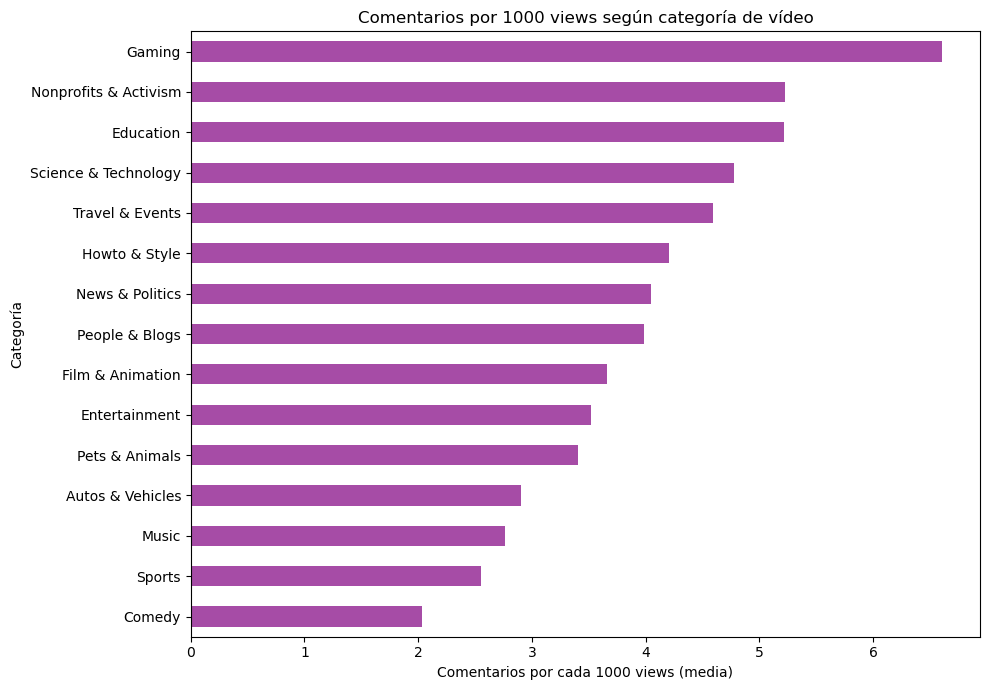

In [18]:
df_1["comments_per_1000views"] = (df_1["comments"] / df_1["views"].replace(0, np.nan)) * 1000

# 2. Agrupar por categoría y calcular promedio
comments_by_cat = (
    df_1.groupby("category_id")["comments_per_1000views"]
    .mean()
    .sort_values(ascending=False)
)

# 3. Mapear IDs a nombres
comments_by_cat.index = comments_by_cat.index.map(lambda x: category_map.get(int(x), f"Unknown {x}"))

# 4. Visualización
plt.figure(figsize=(10,7))
comments_by_cat.plot(kind="barh", color="purple", alpha=0.7)
plt.xlabel("Comentarios por cada 1000 views (media)")
plt.ylabel("Categoría")
plt.title("Comentarios por 1000 views según categoría de vídeo")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

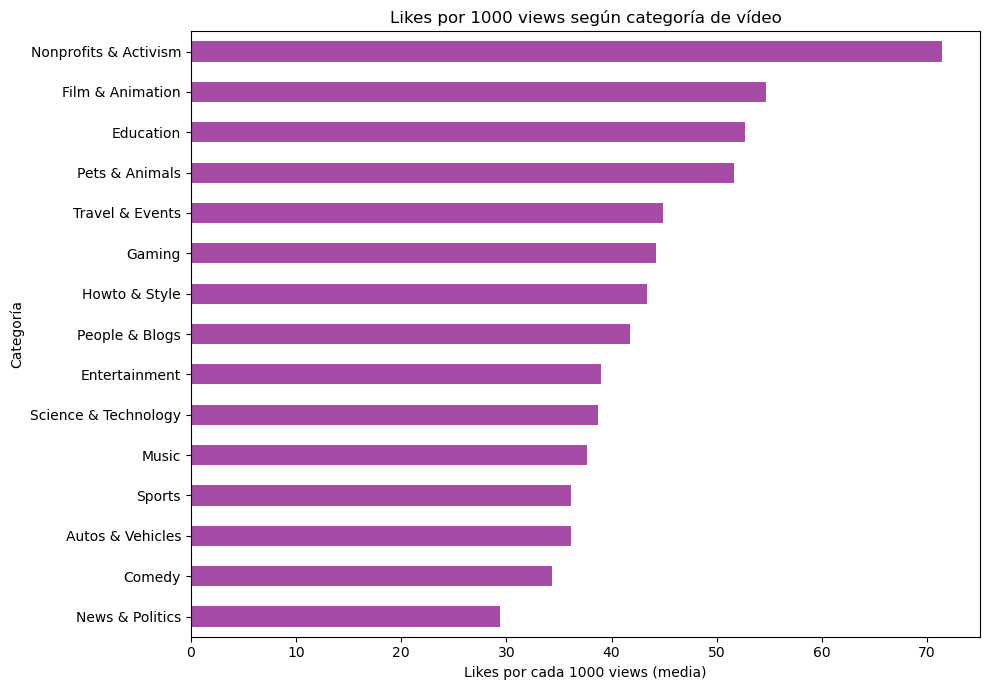

In [19]:
df_1["likes_per_1000views"] = (df_1["likes"] / df_1["views"].replace(0, np.nan)) * 1000

# 2. Agrupar por categoría y calcular promedio
likes_by_cat = (
    df_1.groupby("category_id")["likes_per_1000views"]
    .mean()
    .sort_values(ascending=False)
)

# 3. Mapear IDs a nombres
likes_by_cat.index = likes_by_cat.index.map(lambda x: category_map.get(int(x), f"Unknown {x}"))

# 4. Visualización
plt.figure(figsize=(10,7))
likes_by_cat.plot(kind="barh", color="purple", alpha=0.7)
plt.xlabel("Likes por cada 1000 views (media)")
plt.ylabel("Categoría")
plt.title("Likes por 1000 views según categoría de vídeo")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## EFICIENCIA Y VIRALIDAD

In [20]:
df_1["comments_per_view"] = df_1["comments"] / df_1["views"].replace(0, np.nan)

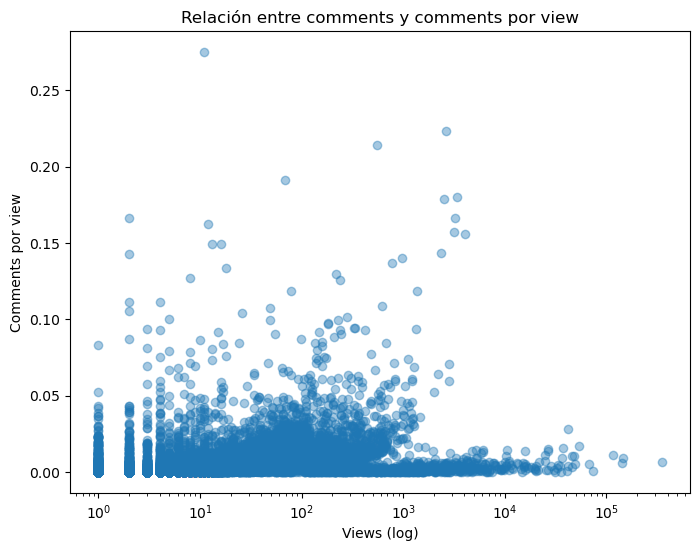

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_1["comments"], df_1["comments_per_view"], alpha=0.4)
plt.xscale("log")  # log para que se vea mejor
plt.xlabel("Views (log)")
plt.ylabel("Comments por view")
plt.title("Relación entre comments y comments por view")
plt.show()

In [22]:
high_comments_small_views = df_1[
    (df_1["comments"] > 100) & (df_1["comments_per_view"] > 0.16)
][["title", "views", "comments", "comments_per_view"]]

print(high_comments_small_views.sort_values("comments_per_view", ascending=False).head(25))

                                                   title  views  comments  \
7228   Cómo ganar más dinero y tener las finanzas con...  11804      2635   
15402  Cómo Orar en la Práctica y Tener más Intimidad...   2595       555   
2523   Reza esto a San Miguel Arcángel y verás cómo s...  18928      3415   
7252   Cómo construir tu base financiera para 2025 | ...  14184      2532   
4537   Como baixar e usar script no 99 Noites na Flor...  19485      3247   

       comments_per_view  
7228            0.223229  
15402           0.213873  
2523            0.180421  
7252            0.178511  
4537            0.166641  


## DISTRIBUCIONES Y OUTLIERS

Gini de views: 0.957
Proporción de vídeos necesaria para acumular el 80% de views: 100.0%


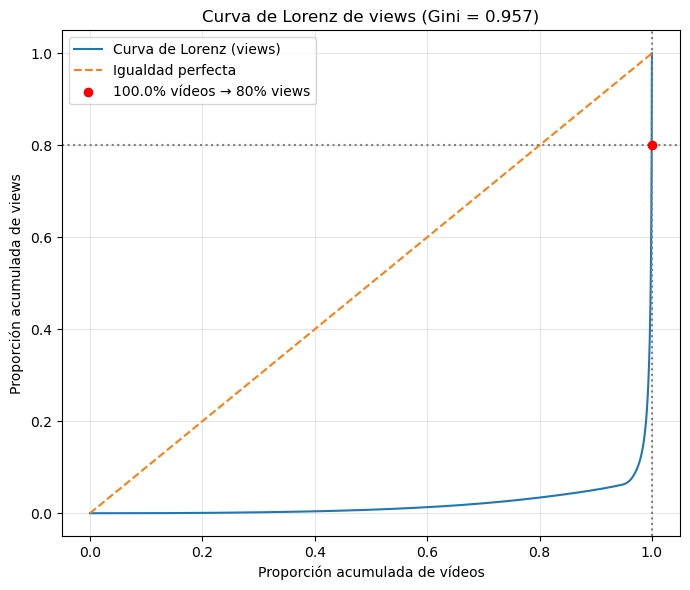

In [23]:


# --- 0) Preparación: columna de views limpia ---
views = pd.to_numeric(df_1["views"], errors="coerce").fillna(0).values
n = len(views)
if n == 0:
    raise ValueError("No hay datos de 'views'.")

# --- 1) Ordenar de menor a mayor y calcular acumulados ---
views_sorted = np.sort(views)                    # ascendente
cum_views = np.cumsum(views_sorted)              # acumulado de views
total_views = cum_views[-1] if cum_views[-1] > 0 else 1.0

# Eje X: proporción acumulada de vídeos (0..1)
cum_videos = np.arange(1, n+1) / n
# Eje Y: proporción acumulada de views (0..1)
lorenz = cum_views / total_views
lorenz = np.insert(lorenz, 0, 0)                 # forzar origen (0,0)
cum_videos0 = np.insert(cum_videos, 0, 0)

# --- 2) Gini (área entre igualdad y Lorenz): G = 1 - 2 * AUC(Lorenz) ---
auc_lorenz = np.trapz(lorenz, cum_videos0)
gini = 1 - 2 * auc_lorenz

# --- 3) ¿Qué % de vídeos concentra el 80% de las views? ---
threshold = 0.80
# índice del primer punto donde el acumulado de views >= 80%
idx_80 = np.searchsorted(lorenz, threshold)
prop_videos_80 = cum_videos0[idx_80] * 100   # en porcentaje

print(f"Gini de views: {gini:.3f}")
print(f"Proporción de vídeos necesaria para acumular el 80% de views: {prop_videos_80:.1f}%")

# --- 4) Gráfica de Lorenz ---
plt.figure(figsize=(7,6))
plt.plot(cum_videos0, lorenz, label="Curva de Lorenz (views)")
plt.plot([0,1], [0,1], linestyle="--", label="Igualdad perfecta")
# marcar el punto del 80%
plt.axhline(threshold, color="gray", linestyle=":")
plt.axvline(cum_videos0[idx_80], color="gray", linestyle=":")
plt.scatter([cum_videos0[idx_80]], [threshold], color="red", zorder=3,
            label=f"{prop_videos_80:.1f}% vídeos → 80% views")

plt.xlabel("Proporción acumulada de vídeos")
plt.ylabel("Proporción acumulada de views")
plt.title(f"Curva de Lorenz de views (Gini = {gini:.3f})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# Orden descendente por views
views_sorted_desc = np.sort(views)[::-1]
cum_views_desc = np.cumsum(views_sorted_desc) / total_views

# Índice donde se supera el 80%
idx_80_desc = np.searchsorted(cum_views_desc, 0.8)
prop_videos_80_desc = (idx_80_desc + 1) / n * 100

print(f"Top {prop_videos_80_desc:.2f}% de vídeos concentran el 80% de views")

Top 1.04% de vídeos concentran el 80% de views


### COMMENTS

Gini de comments: 0.947
Proporción de vídeos necesaria para acumular el 80% de comments: 100.0%


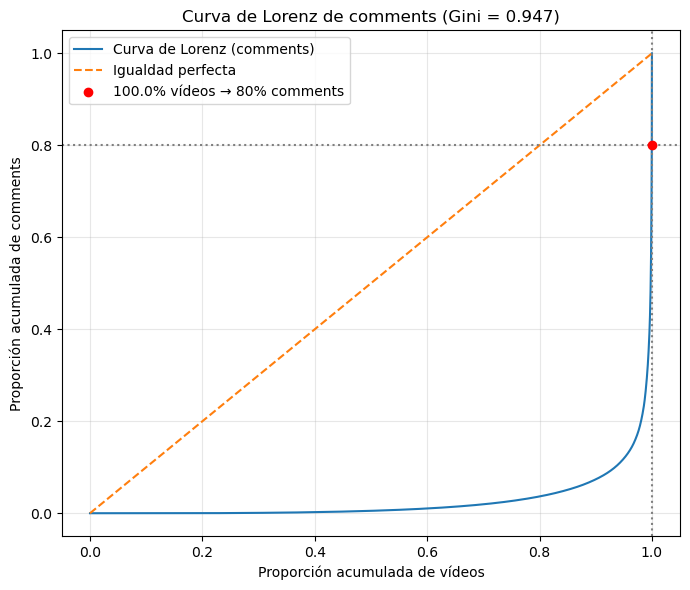

In [25]:
# --- 0) Preparación: columna de comments limpia ---
comments = pd.to_numeric(df_1["comments"], errors="coerce").fillna(0).values
n = len(comments)
if n == 0:
    raise ValueError("No hay datos de 'comments'.")

# --- 1) Ordenar (ascendente) y acumulados ---
comments_sorted = np.sort(comments)             # ascendente
cum_comments = np.cumsum(comments_sorted)       # acumulado de comments
total_comments = cum_comments[-1] if cum_comments[-1] > 0 else 1.0

# Eje X: proporción acumulada de vídeos (0..1)
cum_videos = np.arange(1, n+1) / n
# Eje Y: proporción acumulada de comments (0..1)
lorenz = cum_comments / total_comments
lorenz = np.insert(lorenz, 0, 0)                # origen (0,0)
cum_videos0 = np.insert(cum_videos, 0, 0)

# --- 2) Gini para comments ---
auc_lorenz = np.trapz(lorenz, cum_videos0)
gini = 1 - 2 * auc_lorenz

# --- 3) ¿Qué % de vídeos acumula el 80% de comments? ---
threshold = 0.80
idx_80 = np.searchsorted(lorenz, threshold)
prop_videos_80 = cum_videos0[idx_80] * 100

print(f"Gini de comments: {gini:.3f}")
print(f"Proporción de vídeos necesaria para acumular el 80% de comments: {prop_videos_80:.1f}%")

# --- 4) Curva de Lorenz (comments) ---
plt.figure(figsize=(7,6))
plt.plot(cum_videos0, lorenz, label="Curva de Lorenz (comments)")
plt.plot([0,1], [0,1], linestyle="--", label="Igualdad perfecta")
# marcar el 80%
plt.axhline(threshold, color="gray", linestyle=":")
plt.axvline(cum_videos0[idx_80], color="gray", linestyle=":")
plt.scatter([cum_videos0[idx_80]], [threshold], color="red", zorder=3,
            label=f"{prop_videos_80:.1f}% vídeos → 80% comments")

plt.xlabel("Proporción acumulada de vídeos")
plt.ylabel("Proporción acumulada de comments")
plt.title(f"Curva de Lorenz de comments (Gini = {gini:.3f})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Orden descendente por views
comments_sorted_desc = np.sort(comments)[::-1]
cum_comments_desc = np.cumsum(comments_sorted_desc) / total_comments

# Índice donde se supera el 80%
idx_80_desc = np.searchsorted(cum_comments_desc, 0.8)
prop_videos_80_desc = (idx_80_desc + 1) / n * 100

print(f"Top {prop_videos_80_desc:.2f}% de vídeos concentran el 80% de views")

Top 1.94% de vídeos concentran el 80% de views


## ENGAGEMENT / EFICIENCIA

In [27]:

# --- Definimos las métricas ---
metricas = ["engagement_rate", "efficiency"]

unicorns = {}

for m in metricas:
    p99 = df_1[m].quantile(0.99)   # umbral 1% superior
    top = df_1[df_1[m] >= p99].copy()
    unicorns[m] = top.sort_values(m, ascending=False)
    
    print(f"\n=== Unicorns por {m} (umbral ≥ {p99:.4f}) ===")
    print(top[["title", "views", "likes", "comments", m]].head(10))

# Ejemplo: acceder a unicorns["engagement_rate"] o unicorns["efficiency"]


=== Unicorns por engagement_rate (umbral ≥ 0.1959) ===
                                                 title  views  likes  \
50   CÓMO ORAR CON LA ACTITUD CORRECTA✨📺LUNES 11 AG...   1810    417   
329  ¿Cómo están los nervios? [25 Ago] – Cristianos...  11273   2930   
350  Los Taygeteanos, ¿qué es el CIC y cómo funcion...   7438   1697   
425                            How do we feed Winston?  15105   3281   
544  El RETO de la IA: Cómo APROVECHARLA sin ROMPER...    509    557   
603  “CÓMO LIMPIAR ESPIRITUALMENTE A TU MASCOTA EN ...  11063   2386   
667                   Cómo pararse con mayor facilidad   5844   1166   
743  como seria meus post se não existisse julgamen...  11717   3460   
928                   Cómo crear historias de terror 👻  11876   2062   
988  El ATAQUE a la FAMILIA, ¿cómo PREVENIRLO? 🎙️ P...   3731    748   

     comments  engagement_rate  
50         44         0.254696  
329       646         0.317218  
350         0         0.228153  
425       440      

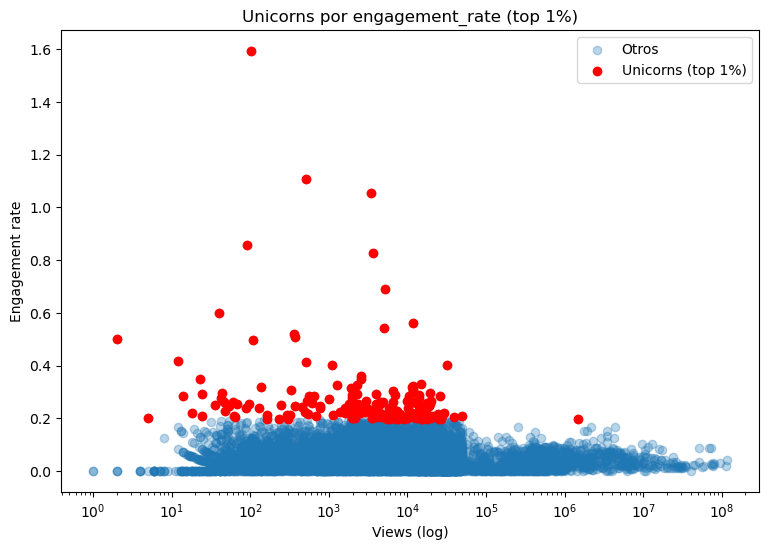

In [28]:

plt.figure(figsize=(9,6))
plt.scatter(df_1["views"], df_1["engagement_rate"], alpha=0.3, label="Otros")
plt.scatter(unicorns["engagement_rate"]["views"],
            unicorns["engagement_rate"]["engagement_rate"],
            color="red", label="Unicorns (top 1%)")

plt.xscale("log")
plt.xlabel("Views (log)")
plt.ylabel("Engagement rate")
plt.title("Unicorns por engagement_rate (top 1%)")
plt.legend()
plt.show()

# CONTENIDO Y METADATOS

¿Influye la duración (duration_minutes) en el engagement?

In [29]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19154 entries, 0 to 19153
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                19154 non-null  object             
 1   title                   19154 non-null  object             
 2   description             15337 non-null  object             
 3   published_at            19154 non-null  datetime64[ns, UTC]
 4   duration_minutes        19154 non-null  float64            
 5   definition              19154 non-null  int64              
 6   licensed_content        19154 non-null  Int64              
 7   has_caption             19154 non-null  Int64              
 8   category_id             19154 non-null  float64            
 9   views                   19154 non-null  int64              
 10  likes                   19154 non-null  int64              
 11  comments                19154 non-null  i

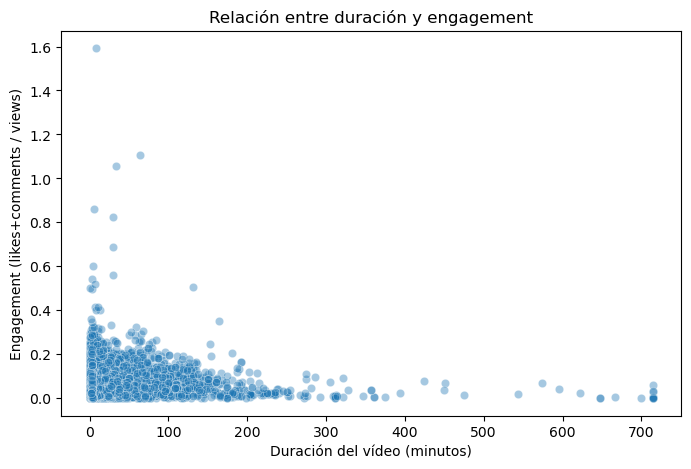

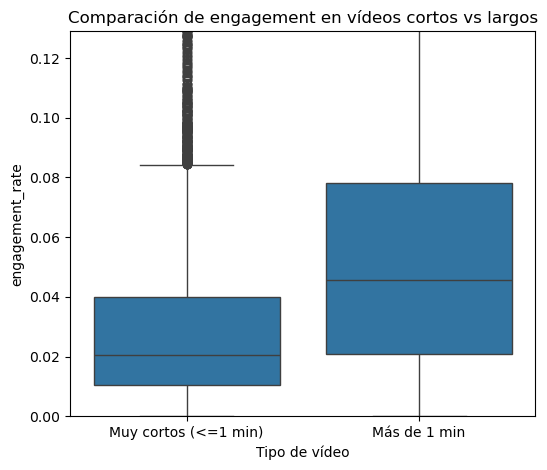

In [30]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_1, x="duration_minutes", y="engagement_rate", alpha=0.4)
plt.xlabel("Duración del vídeo (minutos)")
plt.ylabel("Engagement (likes+comments / views)")
plt.title("Relación entre duración y engagement")
#plt.ylim(0, df_1["engagement_rate"].quantile(0.95))  # cortar outliers extremos
plt.show()

# --- 3) Boxplot: agrupar vídeos cortos vs largos ---
# Definimos arbitrariamente 'cortos' <= 10 min, 'largos' > 10 min
df_1["duracion_tipo"] = pd.cut(
    df_1["duration_minutes"],
    bins=[0, 1, df_1["duration_minutes"].max()],
    labels=["Muy cortos (<=1 min)", "Más de 1 min"]
)

plt.figure(figsize=(6,5))
sns.boxplot(data=df_1, x="duracion_tipo", y="engagement_rate")
plt.xlabel("Tipo de vídeo")
plt.ylabel("engagement_rate")
plt.title("Comparación de engagement en vídeos cortos vs largos")
plt.ylim(0, df_1["engagement_rate"].quantile(0.95))  # quitar outliers extremos
plt.show()

¿La presencia de captions (has_caption) afecta visitas?


In [31]:
df_1.groupby("has_caption")["views"].mean()

has_caption
0    1.503461e+05
1    1.498447e+06
Name: views, dtype: float64

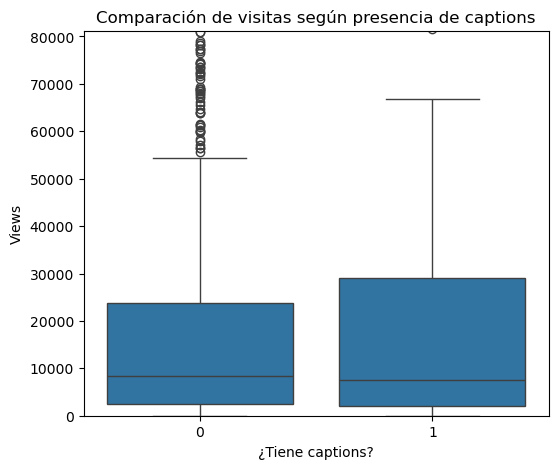

In [32]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df_1, x="has_caption", y="views")
plt.ylim(0, df_1["views"].quantile(0.95))  # opcional: limitar outliers
plt.xlabel("¿Tiene captions?")
plt.ylabel("Views")
plt.title("Comparación de visitas según presencia de captions")
plt.show()

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/59749830.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_1, x="has_caption", y="views", estimator=np.median, ci=None)


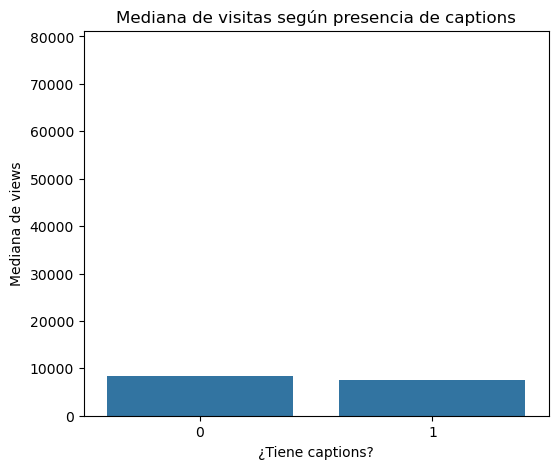

In [33]:
plt.figure(figsize=(6,5))
sns.barplot(data=df_1, x="has_caption", y="views", estimator=np.median, ci=None)
plt.ylim(0, df_1["views"].quantile(0.95))  # recorte opcional
plt.xlabel("¿Tiene captions?")
plt.ylabel("Mediana de views")
plt.title("Mediana de visitas según presencia de captions")
plt.show()

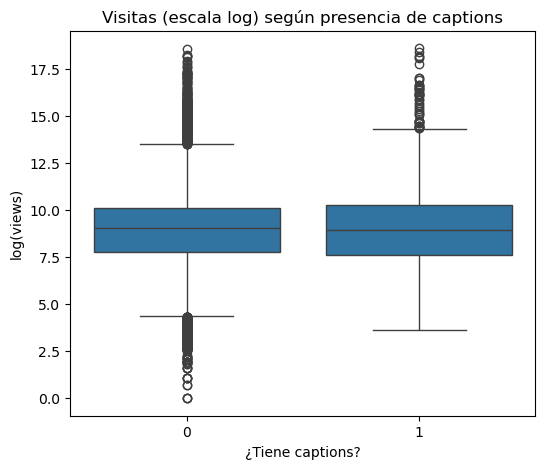

In [34]:

df_1["views_log"] = np.log1p(df_1["views"])  # log(views+1)

plt.figure(figsize=(6,5))
sns.boxplot(data=df_1, x="has_caption", y="views_log")
plt.xlabel("¿Tiene captions?")
plt.ylabel("log(views)")
plt.title("Visitas (escala log) según presencia de captions")
plt.show()

## RANKING CATEGORIAS POR ENGAGEMENT

In [35]:

df_1['category_name']=df_1['category_id'].map(category_map)

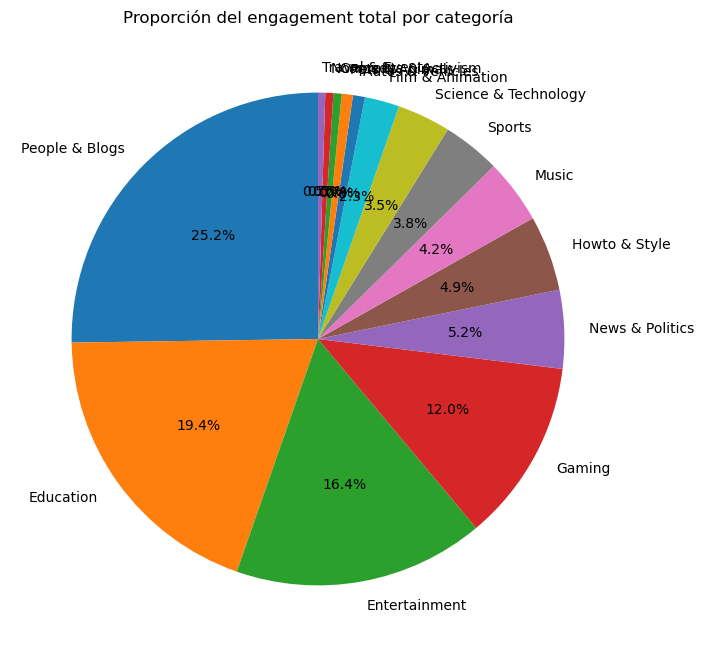

In [36]:
# Engagement total por categoría
engagement_total = (
    df_1.groupby("category_name")["engagement_rate"]
        .sum()
        .reset_index()
        .sort_values("engagement_rate", ascending=False)
)

# Pie chart
plt.figure(figsize=(8,8))
plt.pie(
    engagement_total["engagement_rate"],
    labels=engagement_total["category_name"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Proporción del engagement total por categoría")

plt.show()

            category_name  engagement_rate
0   Nonprofits & Activism         0.076677
1        Film & Animation         0.058320
2               Education         0.057881
3          Pets & Animals         0.055058
4                  Gaming         0.050834
5         Travel & Events         0.049454
6           Howto & Style         0.047592
7          People & Blogs         0.045765
8    Science & Technology         0.043481
9           Entertainment         0.042545
10                  Music         0.040399
11       Autos & Vehicles         0.039051
12                 Sports         0.038702
13                 Comedy         0.036342
14        News & Politics         0.033399


/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/361290491.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ranking, x="engagement_rate", y="category_name", palette="viridis")


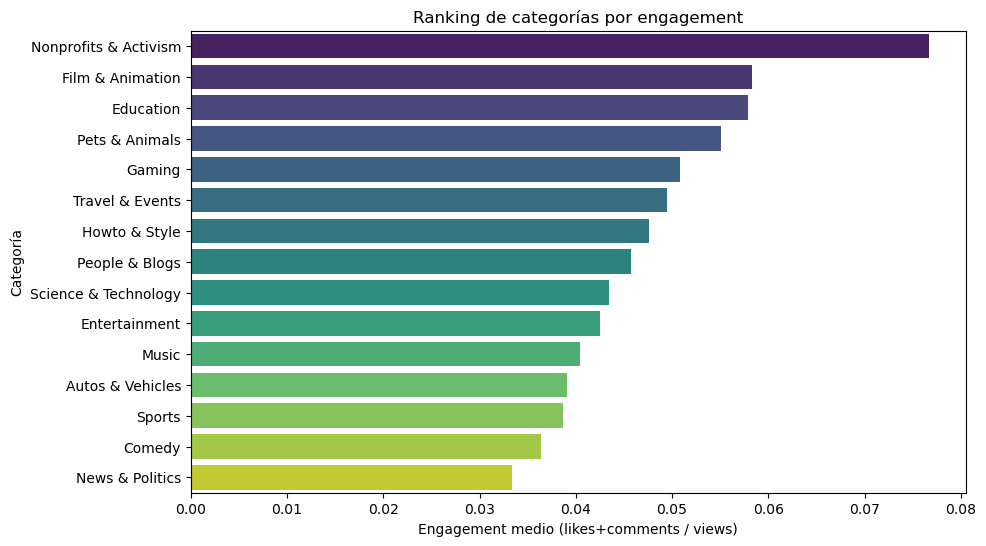

In [37]:
df_1["category_name"] = df_1["category_id"].map(category_map)

# --- 2) Calcular engagement medio por categoría ---
ranking = (
    df_1.groupby("category_name")["engagement_rate"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
)

# --- 3) Mostrar ranking en tabla ---
print(ranking)

# --- 4) Visualizar ranking ---
plt.figure(figsize=(10,6))
sns.barplot(data=ranking, x="engagement_rate", y="category_name", palette="viridis")
plt.xlabel("Engagement medio (likes+comments / views)")
plt.ylabel("Categoría")
plt.title("Ranking de categorías por engagement")
plt.show()

In [38]:
ranking_median = (
    df_1.groupby("category_name")["engagement_rate"]
        .median()
        .sort_values(ascending=False)
)

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2265034317.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ranking_median, x="engagement_rate", y="category_name", palette="viridis")


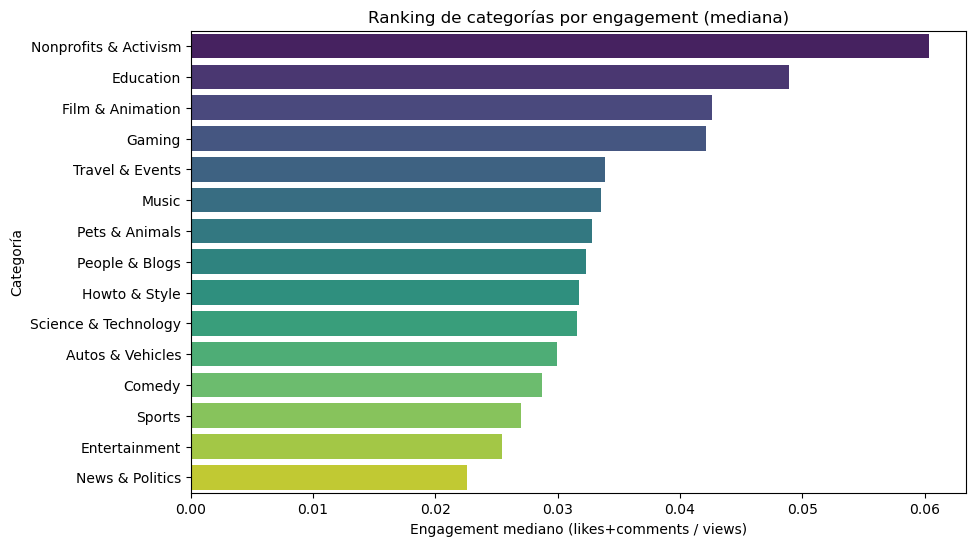

In [39]:
ranking_median = (
    df_1.groupby("category_name")["engagement_rate"]
        .median()
        .rename("engagement_rate")
        .reset_index()
        .sort_values("engagement_rate", ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(data=ranking_median, x="engagement_rate", y="category_name", palette="viridis")
plt.xlabel("Engagement mediano (likes+comments / views)")
plt.ylabel("Categoría")
plt.title("Ranking de categorías por engagement (mediana)")
plt.show()

## MEDIANA COMMENTS PER VIEW POR CATEGORIA

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2833308015.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ranking_median_comments, x="comments_per_view", y="category_name", palette="viridis")


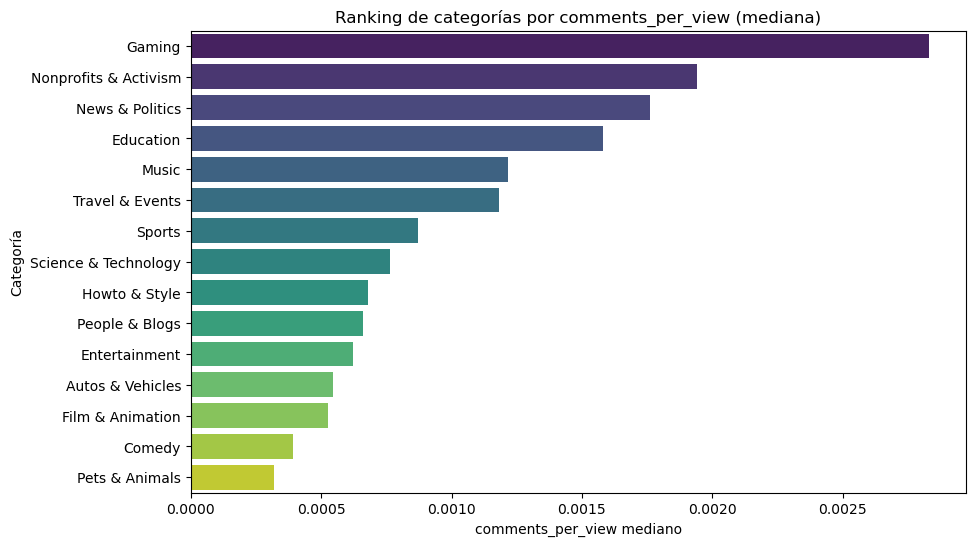

In [40]:
ranking_median_comments = (
    df_1.groupby("category_name")["comments_per_view"]
        .median()
        .rename("comments_per_view")
        .reset_index()
        .sort_values("comments_per_view", ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(data=ranking_median_comments, x="comments_per_view", y="category_name", palette="viridis")
plt.xlabel("comments_per_view mediano")
plt.ylabel("Categoría")
plt.title("Ranking de categorías por comments_per_view (mediana)")
plt.show()

## MEDIANA LIKES PER VIEW POR CATEGORIA

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/1520214949.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ranking_median_likes, x="likes_per_view", y="category_name", palette="viridis")


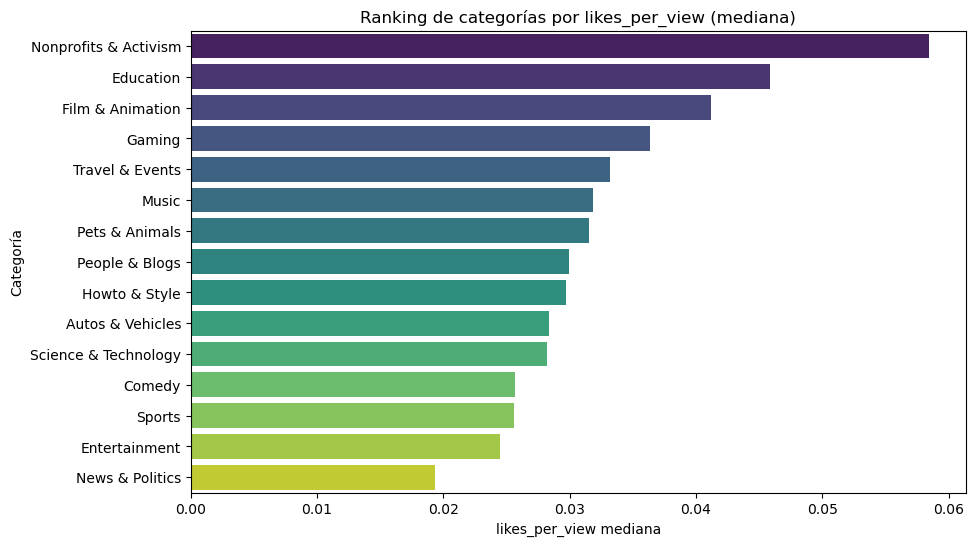

In [41]:
ranking_median_likes = (
    df_1.groupby("category_name")["likes_per_view"]
        .median()
        .rename("likes_per_view")
        .reset_index()
        .sort_values("likes_per_view", ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(data=ranking_median_likes, x="likes_per_view", y="category_name", palette="viridis")
plt.xlabel("likes_per_view mediana")
plt.ylabel("Categoría")
plt.title("Ranking de categorías por likes_per_view (mediana)")
plt.show()

## COMPARACION MEDIANAS Y LIKES POR CATEGORIA

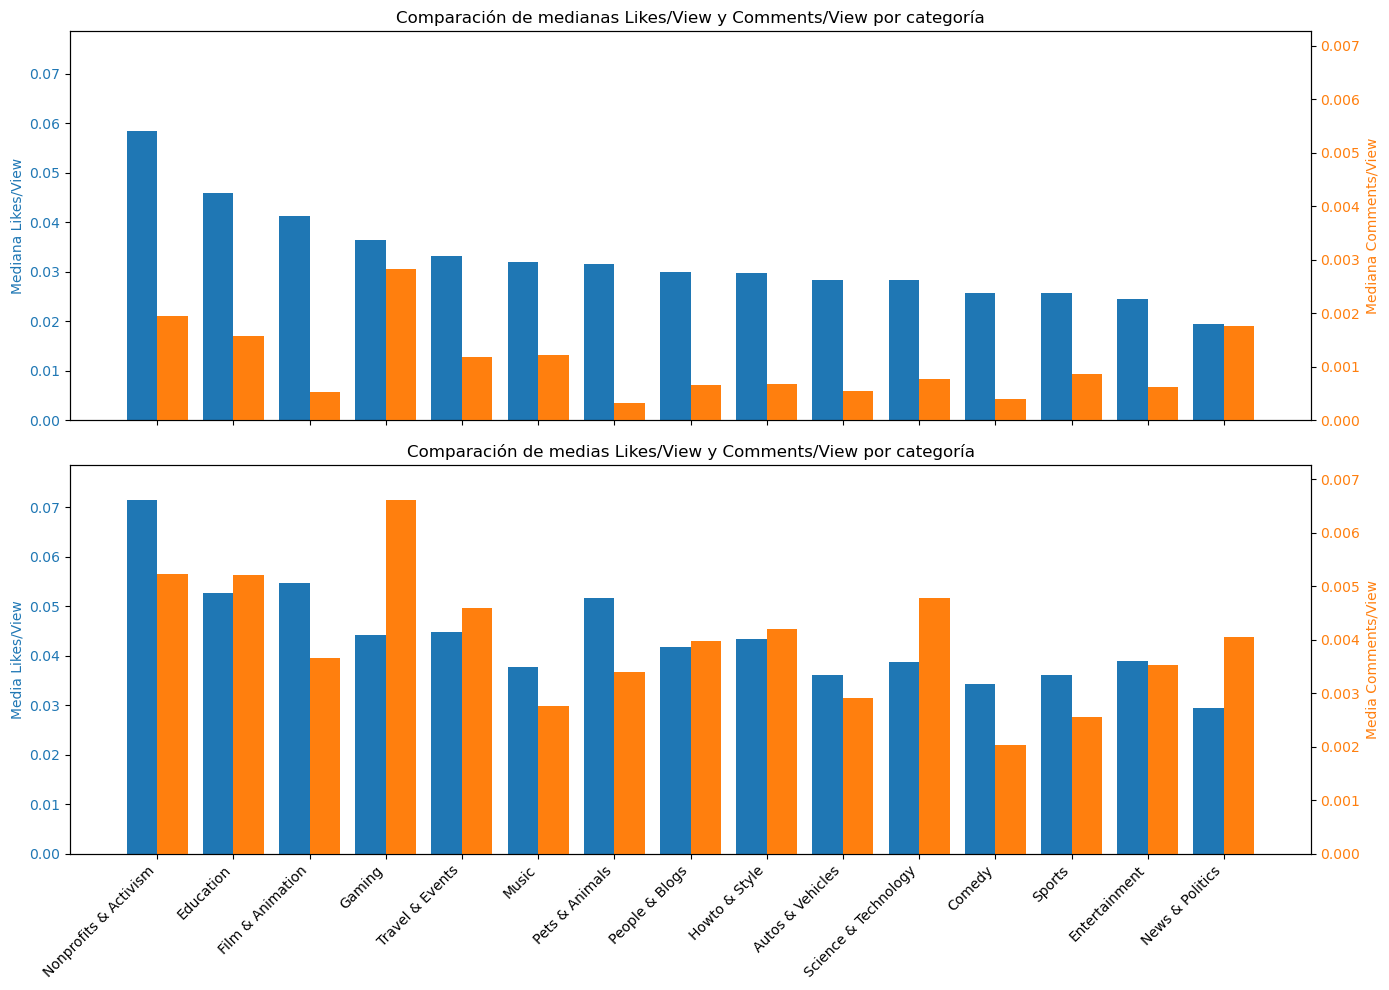

In [42]:
ranking_medianas = (
    df_1.groupby("category_name")[["likes_per_view", "comments_per_view"]]
        .median()
        .reset_index()
)

# --- Calcular medias ---
ranking_medias = (
    df_1.groupby("category_name")[["likes_per_view", "comments_per_view"]]
        .mean()
        .reset_index()
)

# --- Ordenar por likes_per_view (para que ambos tengan mismo orden) ---
order = ranking_medianas.sort_values("likes_per_view", ascending=False)["category_name"]
ranking_medianas = ranking_medianas.set_index("category_name").loc[order].reset_index()
ranking_medias = ranking_medias.set_index("category_name").loc[order].reset_index()

# --- Ajustar escalas iguales ---
ymax_likes = max(ranking_medianas["likes_per_view"].max(), ranking_medias["likes_per_view"].max())
ymax_comments = max(ranking_medianas["comments_per_view"].max(), ranking_medias["comments_per_view"].max())

x = np.arange(len(order))

fig, axes = plt.subplots(2, 1, figsize=(14,10), sharex=True)

# --- Gráfico 1: Median ---
ax1 = axes[0]
ax1.bar(x - 0.2, ranking_medianas["likes_per_view"], width=0.4, color="tab:blue", label="Likes/View")
ax1.set_ylabel("Mediana Likes/View", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(0, ymax_likes*1.1)

ax2 = ax1.twinx()
ax2.bar(x + 0.2, ranking_medianas["comments_per_view"], width=0.4, color="tab:orange", label="Comments/View")
ax2.set_ylabel("Mediana Comments/View", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.set_ylim(0, ymax_comments*1.1)

ax1.set_title("Comparación de medianas Likes/View y Comments/View por categoría")

# --- Gráfico 2: Media ---
ax3 = axes[1]
ax3.bar(x - 0.2, ranking_medias["likes_per_view"], width=0.4, color="tab:blue", label="Likes/View")
ax3.set_ylabel("Media Likes/View", color="tab:blue")
ax3.tick_params(axis="y", labelcolor="tab:blue")
ax3.set_ylim(0, ymax_likes*1.1)

ax4 = ax3.twinx()
ax4.bar(x + 0.2, ranking_medias["comments_per_view"], width=0.4, color="tab:orange", label="Comments/View")
ax4.set_ylabel("Media Comments/View", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")
ax4.set_ylim(0, ymax_comments*1.1)

ax3.set_title("Comparación de medias Likes/View y Comments/View por categoría")

# Eje X común
ax3.set_xticks(x)
ax3.set_xticklabels(order, rotation=45, ha="right")

plt.tight_layout()
plt.show()

Engagement por definition

In [43]:
df_1.groupby("definition")["engagement_rate"].mean()


definition
0    0.053878
1    0.046376
Name: engagement_rate, dtype: float64

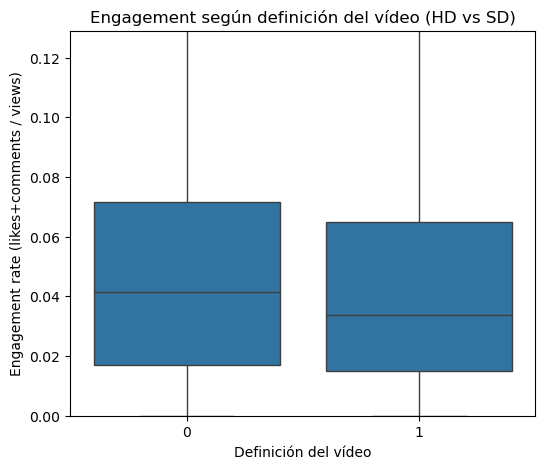

In [44]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df_1, x="definition", y="engagement_rate")
plt.ylim(0, df_1["engagement_rate"].quantile(0.95))  # cortar outliers extremos
plt.xlabel("Definición del vídeo")
plt.ylabel("Engagement rate (likes+comments / views)")
plt.title("Engagement según definición del vídeo (HD vs SD)")
plt.show()

# ANÁLISIS COMBINADO

¿Hay vídeos con alto engagement pero que tienen pocos views en “mostpopular”?

In [45]:
df_1.groupby("mostpopular")["engagement_rate"].mean()

mostpopular
0    0.046946
1    0.038475
Name: engagement_rate, dtype: float64

In [46]:
base = df_1[df_1['mostpopular'] == 1]
base = df_1[df_1['mostpopular'].fillna(False).astype(bool)]

In [47]:
low_views_threshold = df_1[df_1["mostpopular"]==1]["views"].quantile(0.25)
candidatos = df_1[(df_1["views"] <= low_views_threshold) & 
                  (df_1["engagement_rate"] >= df_1["engagement_rate"].quantile(0.95)) & (df_1['mostpopular']== True)]

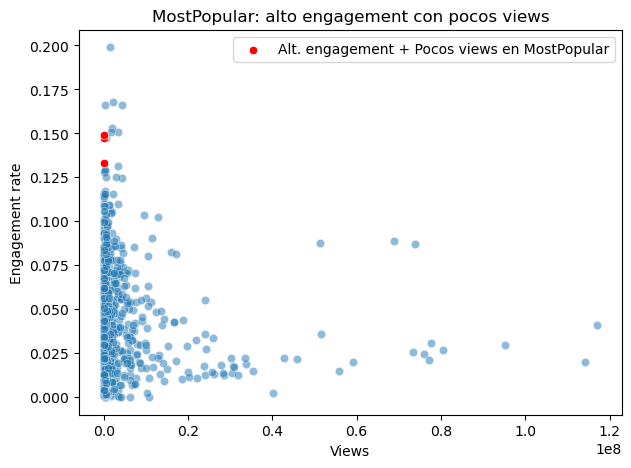

In [48]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=base, x="views", y="engagement_rate", alpha=0.5)

sns.scatterplot(
    data=candidatos,
    x="views", y="engagement_rate",
    color="red", label="Alt. engagement + Pocos views en MostPopular"
)

#plt.xscale("log")  # opcional
plt.xlabel("Views")
plt.ylabel("Engagement rate")
plt.title("MostPopular: alto engagement con pocos views")
plt.legend()
plt.show()

In [49]:
print(candidatos.shape)

(3, 42)


¿Existe una long tail de vídeos con <50000 views (o incluso menos) que suman mucho engagement?

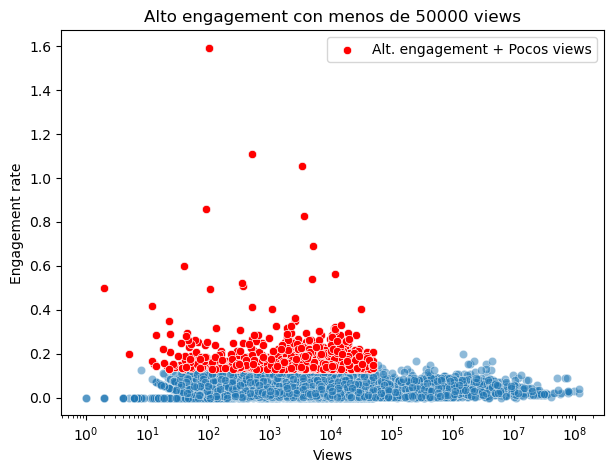

In [50]:
candidatos_2=df_1[(
    df_1['views']<=50000) & (
        df_1['engagement_rate'] >= df_1['engagement_rate'].quantile(0.95)
    )
    ]
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_1, x="views", y="engagement_rate", alpha=0.5)

sns.scatterplot(
    data=candidatos_2,
    x="views", y="engagement_rate",
    color="red", label="Alt. engagement + Pocos views"
)

plt.xscale("log")  # opcional
plt.xlabel("Views")
plt.ylabel("Engagement rate")
plt.title("Alto engagement con menos de 50000 views")
plt.legend()
plt.show()

## INDICE IMPACTO Y RANKEADO

In [51]:
df_1["Impacto"] = df_1["engagement_rate"] * np.log1p(df_1["views"])

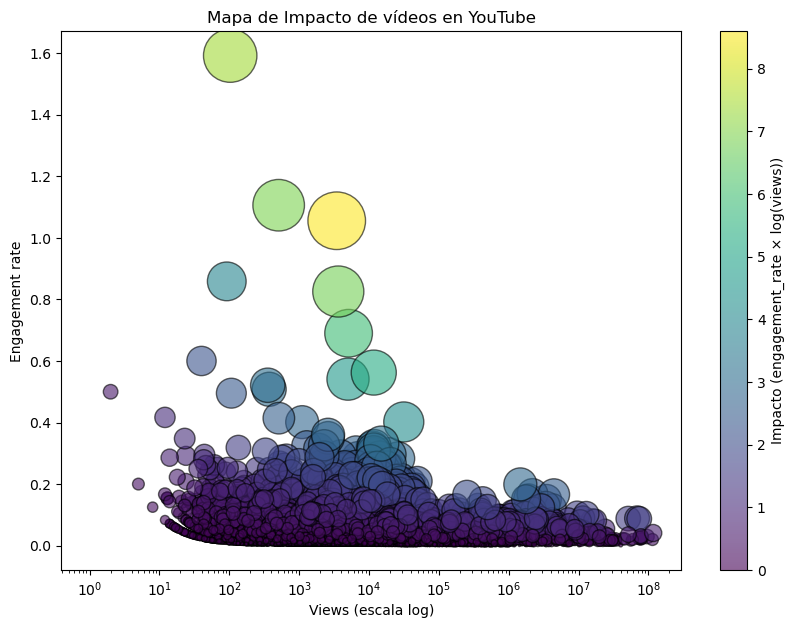

In [52]:
plt.figure(figsize=(10,7))
scatter = plt.scatter(
    x=df_1["views"],
    y=df_1["engagement_rate"],
    s=df_1["Impacto"]*200,    # tamaño de la burbuja (ajusta factor si queda muy grande/pequeño)
    c=df_1["Impacto"],        # color = impacto
    cmap="viridis",
    alpha=0.6,
    edgecolor="k"
)

plt.xscale("log")  # log en views para comprimir rango
plt.xlabel("Views (escala log)")
plt.ylabel("Engagement rate")
plt.title("Mapa de Impacto de vídeos en YouTube")

cbar = plt.colorbar(scatter)
cbar.set_label("Impacto (engagement_rate × log(views))")

plt.show()

                                                   title  \
7713   CÓMO UN NIÑO DE GUERRA CONSTRUYÓ EL IMPERIO DE...   
1442   Pocket Option Estrategia | ¿Cómo convertí 30 d...   
544    El RETO de la IA: Cómo APROVECHARLA sin ROMPER...   
14497  ¿Cómo Convertirse en una SIRENA Popular? De Ne...   
11026  BARBIE vs BRATZ Makeover Extremo de Sirena! ¿C...   
7592   Cambio De Imagen Extremo De NERD a Chica POPUL...   
4066   Mono Baba, Pobre vs. Rico | Cómo conseguir más...   
7184   COMO TRANSFORMAR O PROCESSO DOLOROSO EM GRANDE...   
12518   Opciones Binarias | ¿Cómo convertí $75 en $3757?   
17651  CUATRO DÍAS DE ORACIONES DE PODER PARA PROTEGE...   
9886   ¿Cómo se hace cada día el canal Un minuto ju...   
7228   Cómo ganar más dinero y tener las finanzas con...   
8655   ¡Descubre Cómo Todo Cambia Cuando Actúas Como ...   
329    ¿Cómo están los nervios? [25 Ago] – Cristianos...   
4537   Como baixar e usar script no 99 Noites na Flor...   
9030   El destructivo poder del Muerte P

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/100892177.py:13: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/100892177.py:13: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/100892177.py:13: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  plt.tight_layout()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/100892177.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-

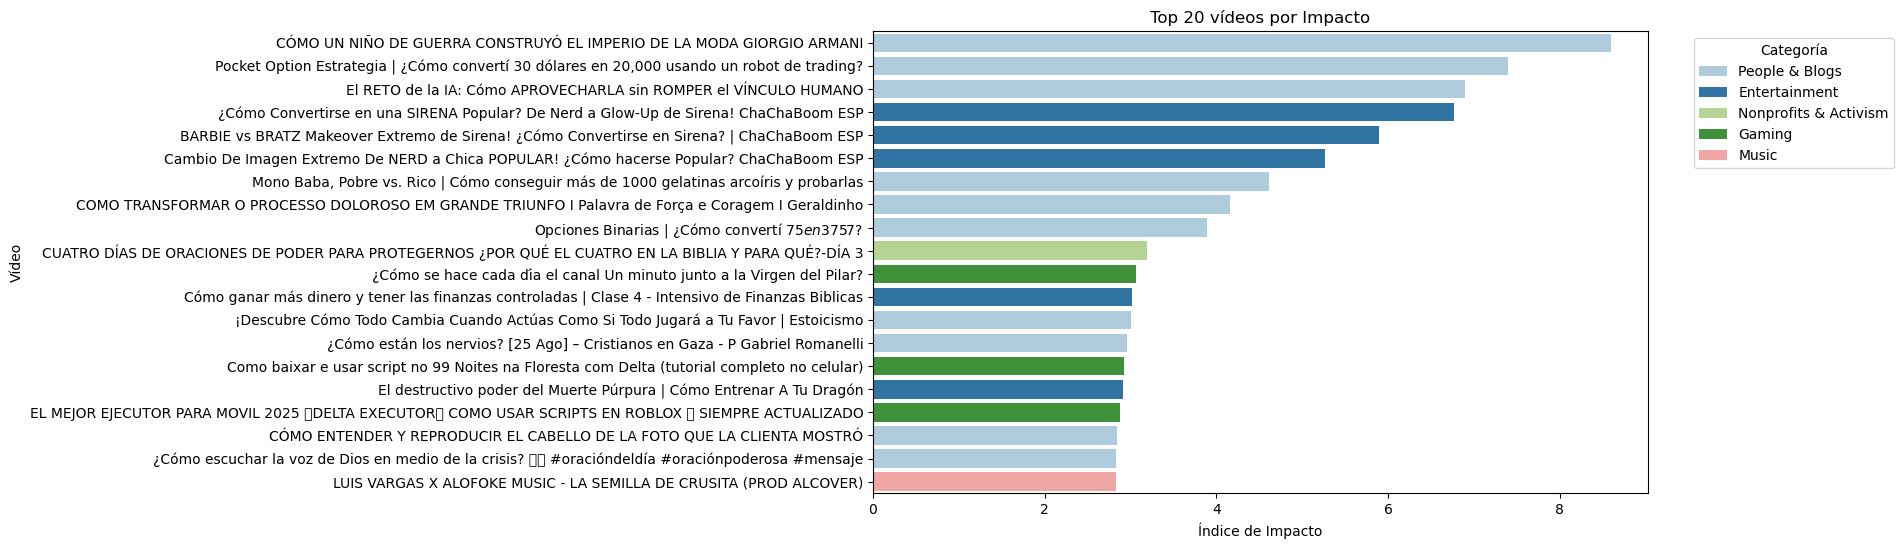

In [53]:
top20 = df_1.sort_values("Impacto", ascending=False).head(20)

# Mostrar en tabla resumida
print(top20[["title", "category_name", "views", "likes", "comments", "engagement_rate", "Impacto"]])

# --- 3) Visualización ---
plt.figure(figsize=(10,6))
sns.barplot(data=top20, x="Impacto", y="title", hue="category_name", dodge=False, palette="Paired")
plt.xlabel("Índice de Impacto")
plt.ylabel("Vídeo")
plt.title("Top 20 vídeos por Impacto")
plt.legend(title="Categoría", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

INDICE DE IMPACTO POR CATEGORIA

In [54]:
impacto_categoria_media = (
    df_1.groupby("category_name")["Impacto"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
)
print(impacto_categoria_media.head())


           category_name   Impacto
0  Nonprofits & Activism  0.697532
1       Film & Animation  0.538229
2              Education  0.467972
3                 Gaming  0.457199
4                  Music  0.440472


/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/3968284444.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=impacto_categoria_media, x="Impacto", y="category_name", palette="viridis")


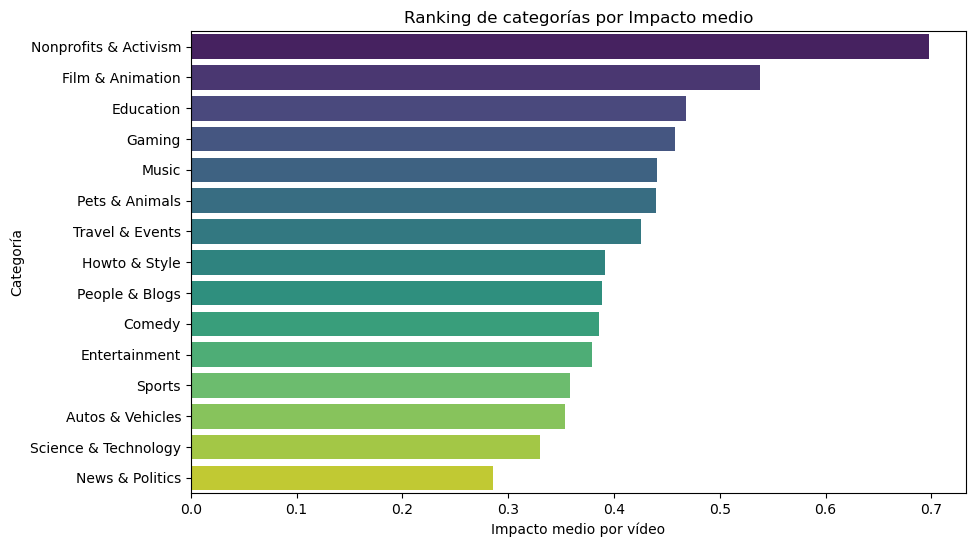

In [55]:
plt.figure(figsize=(10,6))
sns.barplot(data=impacto_categoria_media, x="Impacto", y="category_name", palette="viridis")
plt.xlabel("Impacto medio por vídeo")
plt.ylabel("Categoría")
plt.title("Ranking de categorías por Impacto medio")
plt.show()

    category_name      Impacto
0  People & Blogs  1903.956799
1       Education  1396.428257
2   Entertainment  1302.389483
3          Gaming   956.917507
4           Music   408.757796


/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/3834328824.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=impacto_categoria_total, x="Impacto", y="category_name", palette="magma")


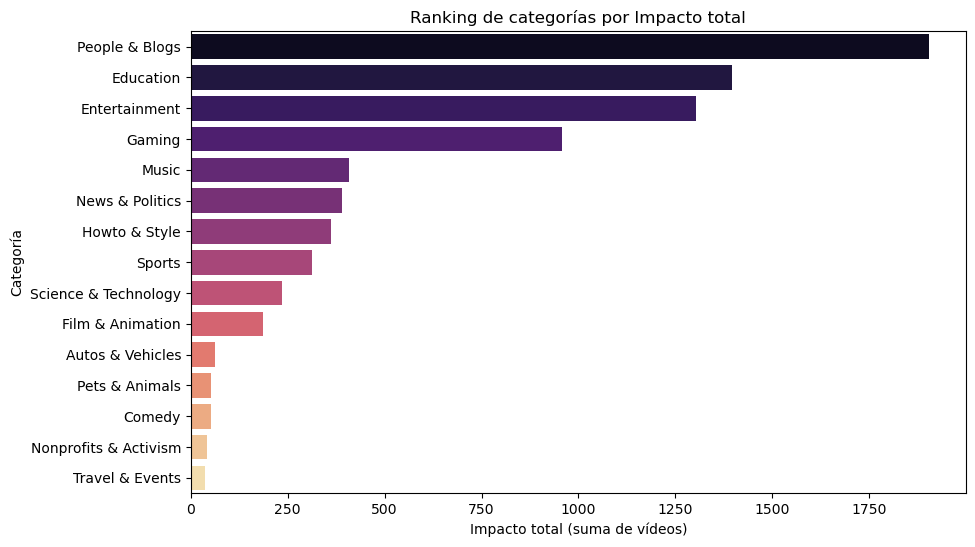

In [56]:
impacto_categoria_total = (
    df_1.groupby("category_name")["Impacto"]
        .sum()
        .sort_values(ascending=False)
        .reset_index()
)

print(impacto_categoria_total.head())

plt.figure(figsize=(10,6))
sns.barplot(data=impacto_categoria_total, x="Impacto", y="category_name", palette="magma")
plt.xlabel("Impacto total (suma de vídeos)")
plt.ylabel("Categoría")
plt.title("Ranking de categorías por Impacto total")
plt.show()

In [57]:
impacto_stats = (
    df_1.groupby("category_name")["Impacto"]
        .agg(Impacto_medio="mean", Impacto_total="sum", n="size")
        .reset_index()
        .sort_values("Impacto_total", ascending=False)
)

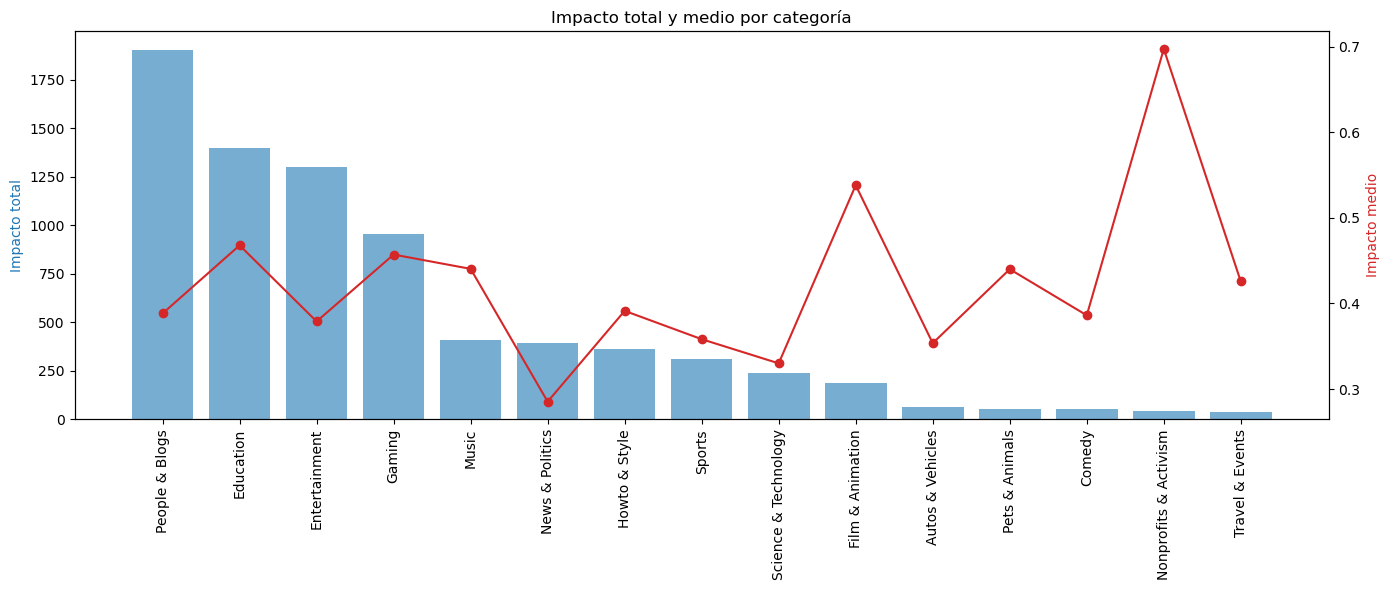

In [58]:
x = np.arange(len(impacto_stats["category_name"]))



fig, ax1 = plt.subplots(figsize=(14,6))

ax1.bar(x, impacto_stats["Impacto_total"], color="tab:blue", alpha=0.6)
ax1.set_ylabel("Impacto total", color="tab:blue")

# Línea roja: impacto medio
ax2 = ax1.twinx()
ax2.plot(x, impacto_stats["Impacto_medio"], color="tab:red", marker="o")
ax2.set_ylabel("Impacto medio", color="tab:red")

# 👇 aquí fuerzas las etiquetas con rotación vertical
ax1.set_xticks(x)
ax1.set_xticklabels(impacto_stats["category_name"], rotation=90, ha="center")

plt.title("Impacto total y medio por categoría")
plt.tight_layout()
plt.show()

In [59]:
impacto_stats = (
    df_1.groupby("category_name")["Impacto"]
        .agg(Impacto_mediana="median", Impacto_total="sum", n="size")
        .reset_index()
        .sort_values("Impacto_total", ascending=False))

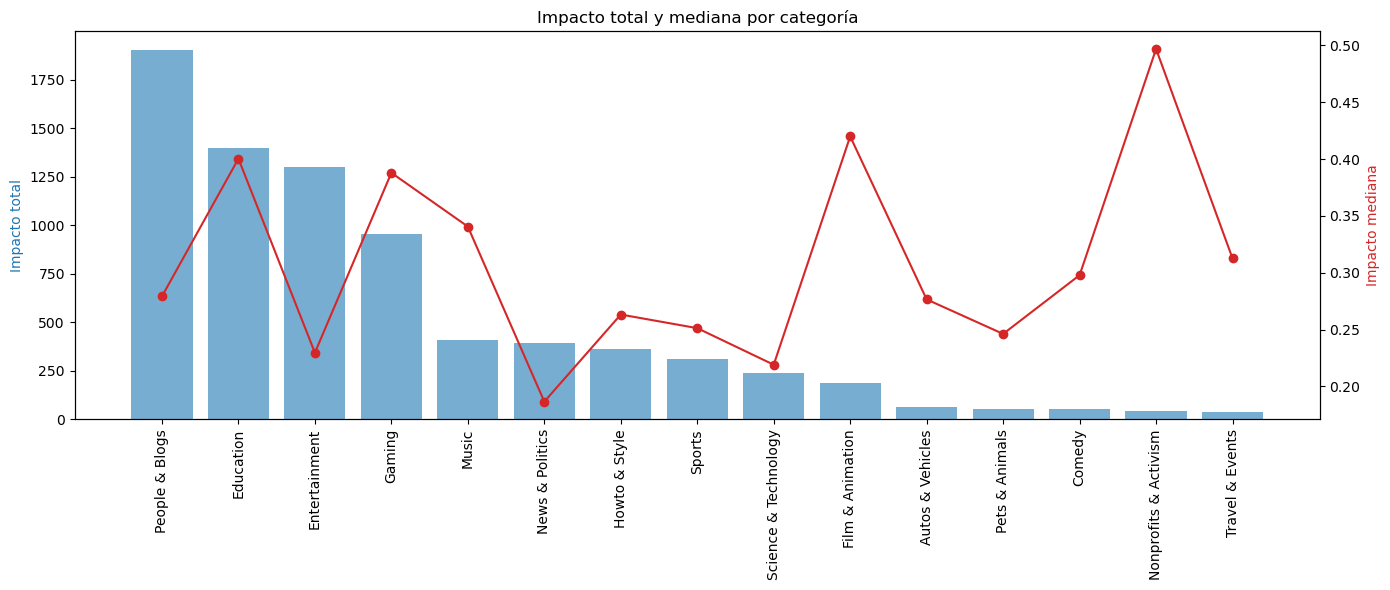

In [60]:
x = np.arange(len(impacto_stats["category_name"]))



fig, ax1 = plt.subplots(figsize=(14,6))

ax1.bar(x, impacto_stats["Impacto_total"], color="tab:blue", alpha=0.6)
ax1.set_ylabel("Impacto total", color="tab:blue")

# Línea roja: impacto medio
ax2 = ax1.twinx()
ax2.plot(x, impacto_stats["Impacto_mediana"], color="tab:red", marker="o")
ax2.set_ylabel("Impacto mediana", color="tab:red")

# 👇 aquí fuerzas las etiquetas con rotación vertical
ax1.set_xticks(x)
ax1.set_xticklabels(impacto_stats["category_name"], rotation=90, ha="center")

plt.title("Impacto total y mediana por categoría")
plt.tight_layout()
plt.show()

# CANALES

In [61]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19154 entries, 0 to 19153
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                19154 non-null  object             
 1   title                   19154 non-null  object             
 2   description             15337 non-null  object             
 3   published_at            19154 non-null  datetime64[ns, UTC]
 4   duration_minutes        19154 non-null  float64            
 5   definition              19154 non-null  int64              
 6   licensed_content        19154 non-null  Int64              
 7   has_caption             19154 non-null  Int64              
 8   category_id             19154 non-null  float64            
 9   views                   19154 non-null  int64              
 10  likes                   19154 non-null  int64              
 11  comments                19154 non-null  i

Filtrar por canal y ver sus mejores vídeos.

In [62]:
#idx = df_1.groupby("channel_id")["views"].idxmax()

df_top_por_canal_views = (df_1
    .sort_values(["channel_id","views","likes","published_at"], ascending=[True, False, False, False])
    .drop_duplicates("channel_id", keep="first"))
df_top_por_canal_views["video_label"] = df_top_por_canal_views["title"] + " | " + df_top_por_canal_views["channel_title"]


/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2785493572.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2785493572.py:13: UserWarning: Glyph 128701 (\N{TOILET}) missing from current font.
  plt.tight_layout()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2785493572.py:13: UserWarning: Glyph 129500 (\N{MERPERSON}) missing from current font.
  plt.tight_layout()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2785493572.py:13: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from current font.
  plt.tight_layout()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2785493572.py:13: UserWarning: Glyph 46832 (\N{HANGUL SYLLABLE DDWI}) missing from current font.
  plt.tight_layout()


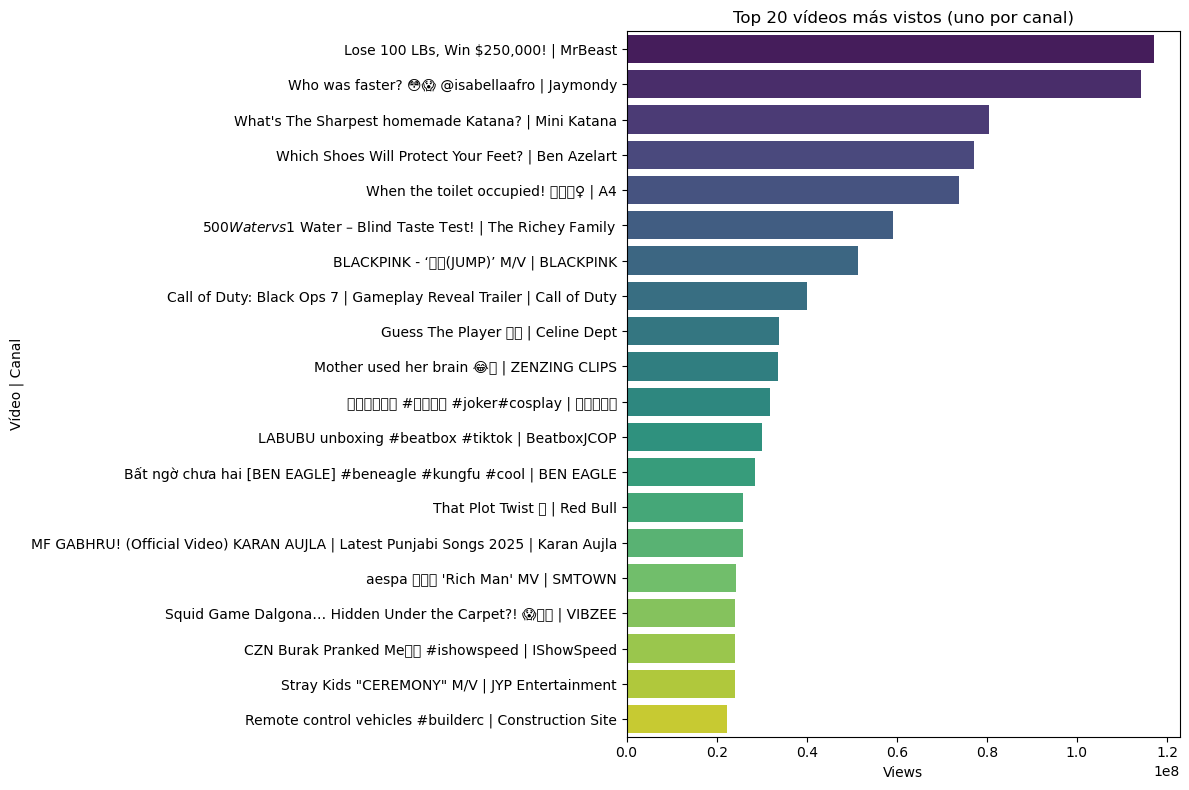

In [63]:
top_videos = df_top_por_canal_views.sort_values("views", ascending=False).head(20)

plt.figure(figsize=(12,8))
sns.barplot(
    data=top_videos,
    x="views",
    y="video_label",   # 👈 título + canal
    palette="viridis"
)
plt.xlabel("Views")
plt.ylabel("Vídeo | Canal")
plt.title("Top 20 vídeos más vistos (uno por canal)")
plt.tight_layout()
plt.show()

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2020546886.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2020546886.py:17: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2020546886.py:17: UserWarning: Glyph 128171 (\N{DIZZY SYMBOL}) missing from current font.
  plt.tight_layout()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2020546886.py:17: UserWarning: Glyph 119929 (\N{MATHEMATICAL BOLD ITALIC CAPITAL R}) missing from current font.
  plt.tight_layout()
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2020546886.py:17: UserWarning: Glyph 119942 (\N{MATHEMATICAL BOLD ITALIC SMALL E}) missing from current font.
  p

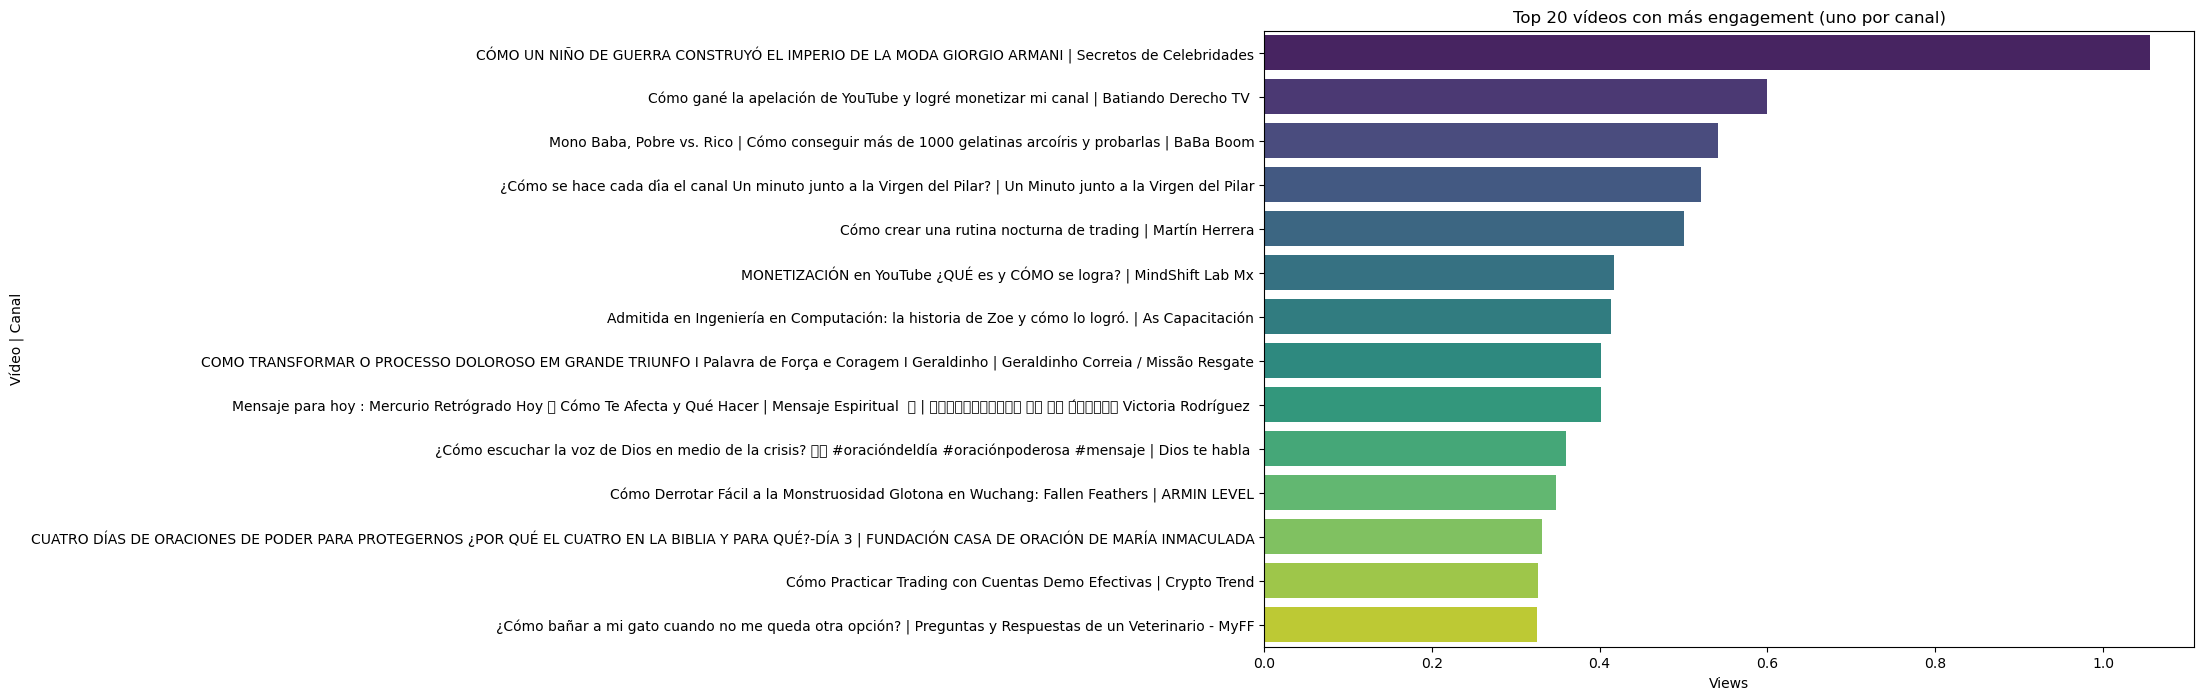

In [64]:

df_top_por_canal_engagement = (df_1
    .sort_values(["channel_id","engagement_rate","likes","published_at"], ascending=[True, False, False, False])
    .drop_duplicates("channel_id", keep="first"))
df_top_por_canal_engagement["video_label"] = df_top_por_canal_views["title"] + " | " + df_top_por_canal_views["channel_title"]
top_videos_engagement = df_top_por_canal_engagement.sort_values("engagement_rate", ascending=False).head(20)

plt.figure(figsize=(12,8))
sns.barplot(
    data=top_videos_engagement,
    x="engagement_rate",
    y="video_label",   # 👈 título + canal
    palette="viridis"
)
plt.xlabel("Views")
plt.ylabel("Vídeo | Canal")
plt.title("Top 20 vídeos con más engagement (uno por canal)")
plt.tight_layout()
plt.show()

Ranking de canales más efectivos por suscriptores vs engagement

!!!!!!! 
ELEGIR UNO DE LOS DOS ABAJO

In [65]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

canal_stats = (df_1
    .groupby(["channel_id","channel_title"], as_index=False)
    .agg(efficiency=("efficiency","mean"),
         engagement_subscribers=("engagement_subscribers","mean"))
)

canal_stats[["efficiency","engagement_subscribers"]] = (
    canal_stats[["efficiency","engagement_subscribers"]].fillna(0.0)
)
canal_stats[["eff_norm","engsub_norm"]] = scaler.fit_transform(
    canal_stats[["efficiency","engagement_subscribers"]]
)
# índice ponderado (70% eficiencia, 30% engagement_subscribers)
canal_stats["indice"] = 0.5 * canal_stats["eff_norm"] + 0.5 * canal_stats["engsub_norm"]
ranking = canal_stats.sort_values("indice", ascending=False)
print(ranking.head(10))

                    channel_id       channel_title     efficiency  \
285   UC0d7e5VN0DTIlFYNL6QGDOA    ManuelTurizoVEVO   13195.000000   
5097  UCTcqFJumnQDRj606hpyL5Dg     KendoKaponiVEVO   51896.250000   
8875  UCpXMiGQlzxA9AWaviDmQjXw           MILOJVEVO  178255.000000   
5121  UCTmIkSAZsViMmfpGX4ySJAA          LaMODAVEVO    1247.500000   
6623  UCbS0nwbq1L1uRv1pUdgtcYQ   DanielaBlascoVEVO    2238.000000   
7080  UCeDlzhpU8NZAlL1rsXp54zQ  AlofokeMusicSounds   58290.600000   
5590  UCWOVPbJfZ_g1JslVi_OFGfQ             W Sound   42941.600000   
6283  UC_TEvgd3S9ZOP3nUDsCZ52A       RoyelOtisVEVO    2198.722222   
6114  UCZS2K8ZsUmujTuj3cNMyBSA         Team Cherry   27854.052632   
2155  UCBoNpX06hjs3_ASFftQEmww    ChappellRoanVEVO   18823.400000   

      engagement_subscribers      eff_norm    engsub_norm         indice  
285             13195.000000   3739.661045  362249.003642  182994.332343  
5097             3538.421053  14708.756649   97141.920097   55925.338373  
8875           

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2481986097.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


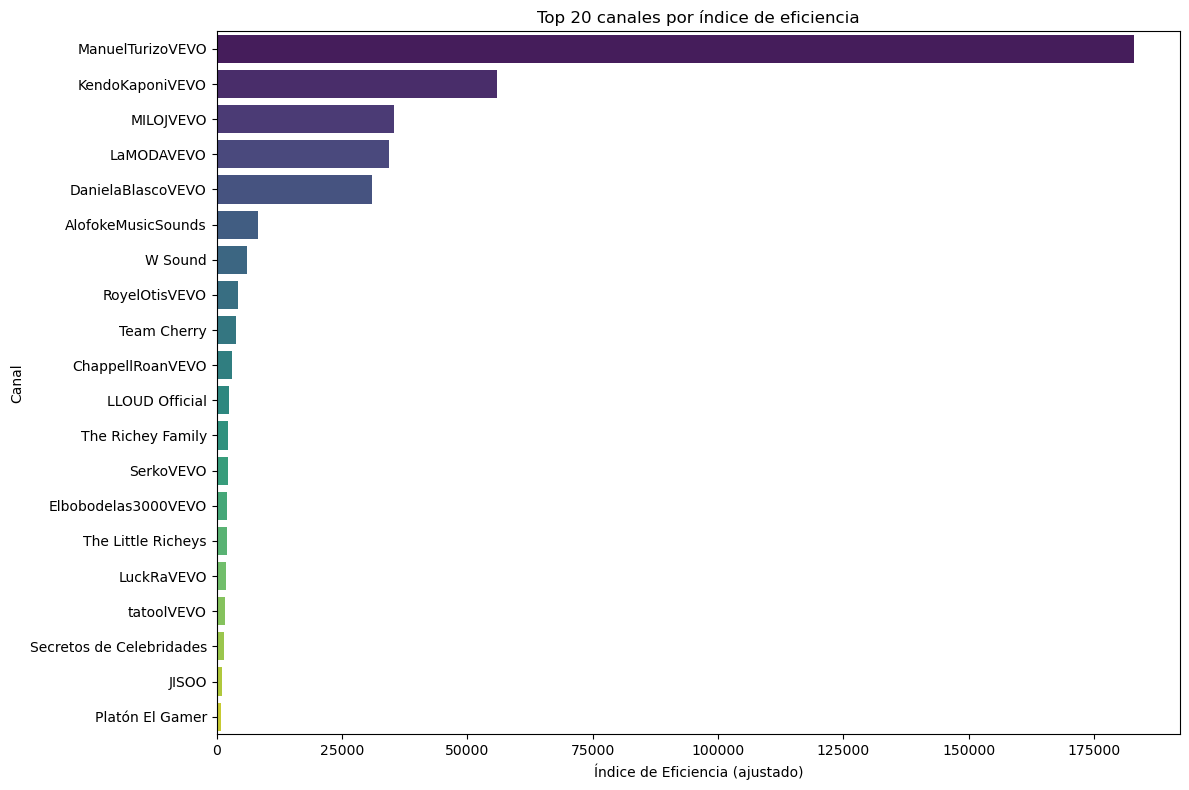

In [66]:
topN = 20
ranking = canal_stats.sort_values("indice", ascending=False).head(topN)

plt.figure(figsize=(12,8))
sns.barplot(
    data=ranking,
    x="indice",
    y="channel_title",
    palette="viridis"
)
plt.xlabel("Índice de Eficiencia (ajustado)")
plt.ylabel("Canal")
plt.title(f"Top {topN} canales por índice de eficiencia")
plt.tight_layout()
plt.show()

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2093162897.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


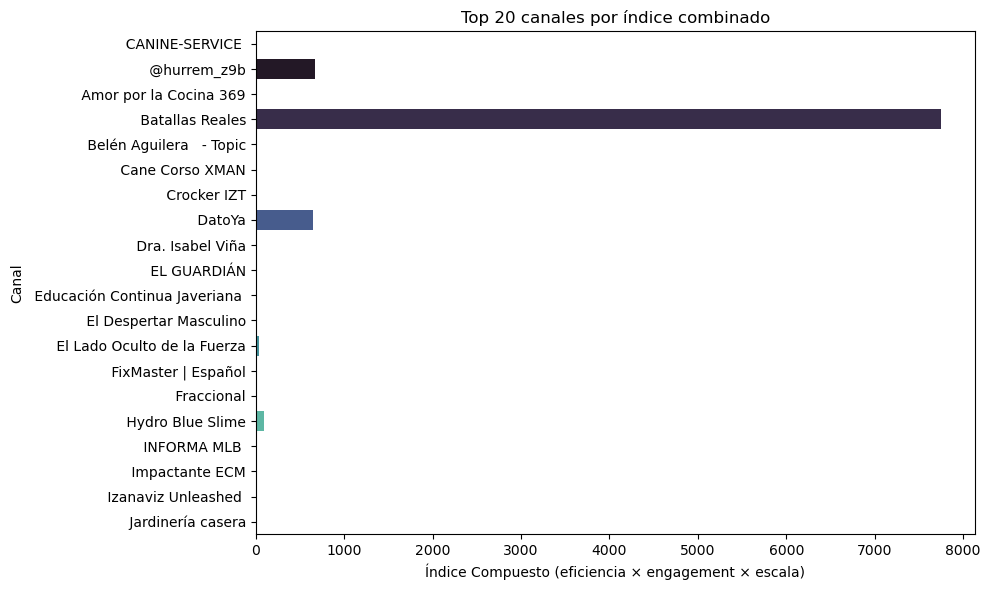

In [67]:
canal_stats = (
    df_1.groupby(["channel_title"])
        .agg(media_efficiency=("efficiency","mean"),
             media_eng_sub=("engagement_subscribers","mean"),
             n_videos=("video_id","nunique"),
             subscribers=("subscriber_count","max")) # suponiendo mismo valor por canal
        .reset_index()
)
# canal_stats["indice_compuesto"] = (
#     0.5 * canal_stats["media_efficiency"] +
#     0.5 * canal_stats["media_eng_sub"])
canal_stats["indice_compuesto"] = (
    canal_stats["media_efficiency"] * canal_stats["media_eng_sub"]
    * np.log1p(canal_stats["n_videos"]) * np.log1p(canal_stats["subscribers"]))

plt.figure(figsize=(10,6))
sns.barplot(
    data=canal_stats.head(20),
    x="indice_compuesto", y="channel_title", palette="mako"
)
plt.xlabel("Índice Compuesto (eficiencia × engagement × escala)")
plt.ylabel("Canal")
plt.title("Top 20 canales por índice combinado")
plt.tight_layout()
plt.show()

In [68]:

# Opcion 1
canal_stats["indice_compuesto"] = (
    canal_stats["media_efficiency"] * canal_stats["media_eng_sub"]
    * np.log1p(canal_stats["n_videos"]) * np.log1p(canal_stats["subscribers"]))

#Opcion 2 Resta valor a la eficiencia y al engagement


ranking = canal_stats.sort_values("indice_compuesto", ascending=False)
print(ranking[["channel_title","n_videos","subscribers","media_efficiency","media_eng_sub","indice_compuesto"]].head(10))

            channel_title  n_videos  subscribers  media_efficiency  \
5207      KendoKaponiVEVO         2           38      51896.250000   
5971            MILOJVEVO         1          241     178255.000000   
6093     ManuelTurizoVEVO         1            1      13195.000000   
1643     ChappellRoanVEVO         1        12600      18823.400000   
2286    DanielaBlascoVEVO         1            1       2238.000000   
5845           LuckRaVEVO         1          799       5351.230769   
8138        RoyelOtisVEVO         1          140       2198.722222   
5546           LaMODAVEVO         1            1       1247.500000   
3220  Elbobodelas3000VEVO         1           22       1565.500000   
526    AlofokeMusicSounds         1       355000      58290.600000   

      media_eng_sub  indice_compuesto  
5207    3538.421053      7.390834e+08  
5971     739.647303      5.016261e+08  
6093   13195.000000      8.365073e+07  
1643      29.878413      3.680641e+06  
2286    2238.000000      2.40

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/4126803936.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


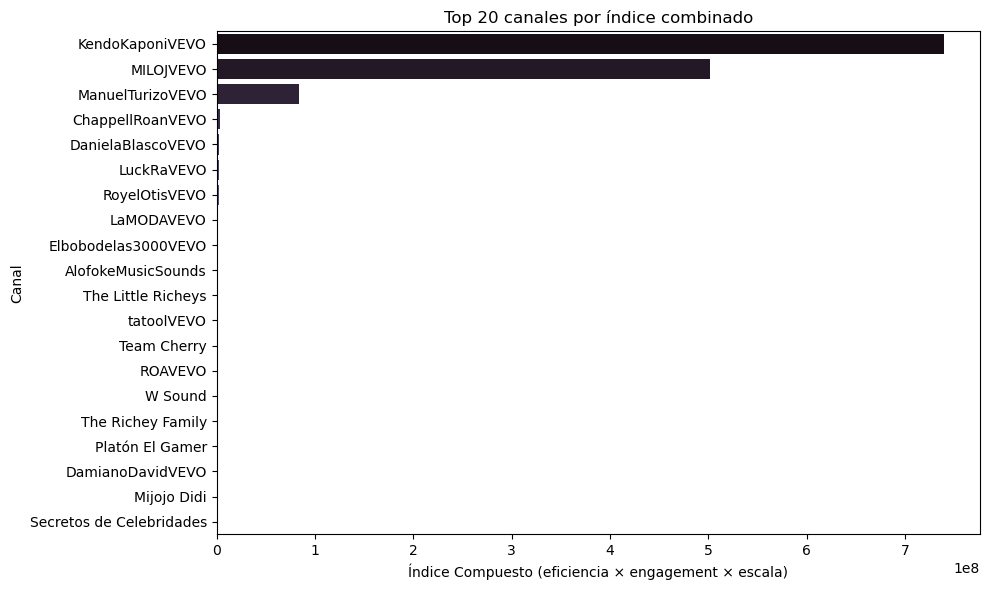

In [69]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=ranking.head(20),
    x="indice_compuesto", y="channel_title", palette="mako"
)
plt.xlabel("Índice Compuesto (eficiencia × engagement × escala)")
plt.ylabel("Canal")
plt.title("Top 20 canales por índice combinado")
plt.tight_layout()
plt.show()

## ENGAGEMENT ## 

•	¿Qué canales logran más “engagement relativo”?

In [70]:
ranking_engsub = df_1.sort_values("engagement_subscribers", ascending=False).head(20)

print(ranking_engsub[["channel_title","engagement_subscribers"]])

                  channel_title  engagement_subscribers
18752          ManuelTurizoVEVO            13195.000000
18600           KendoKaponiVEVO             6133.500000
18169                LaMODAVEVO             2495.000000
18086         DanielaBlascoVEVO             2238.000000
18160           KendoKaponiVEVO              943.342105
18154                 MILOJVEVO              739.647303
18124             RoyelOtisVEVO              282.692857
18373                 SerkoVEVO              167.857143
18116                 SerkoVEVO              156.142857
18110       Elbobodelas3000VEVO              142.318182
7713   Secretos de Celebridades              107.088235
19127                LuckRaVEVO               87.066333
10185           Platón El Gamer               54.131579
10491              Logan Fraser               52.500000
11349            Absurder Level               31.857143
11312               spider-meme               31.285714
18269           NanpaBasicoVEVO               31

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/1739321271.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


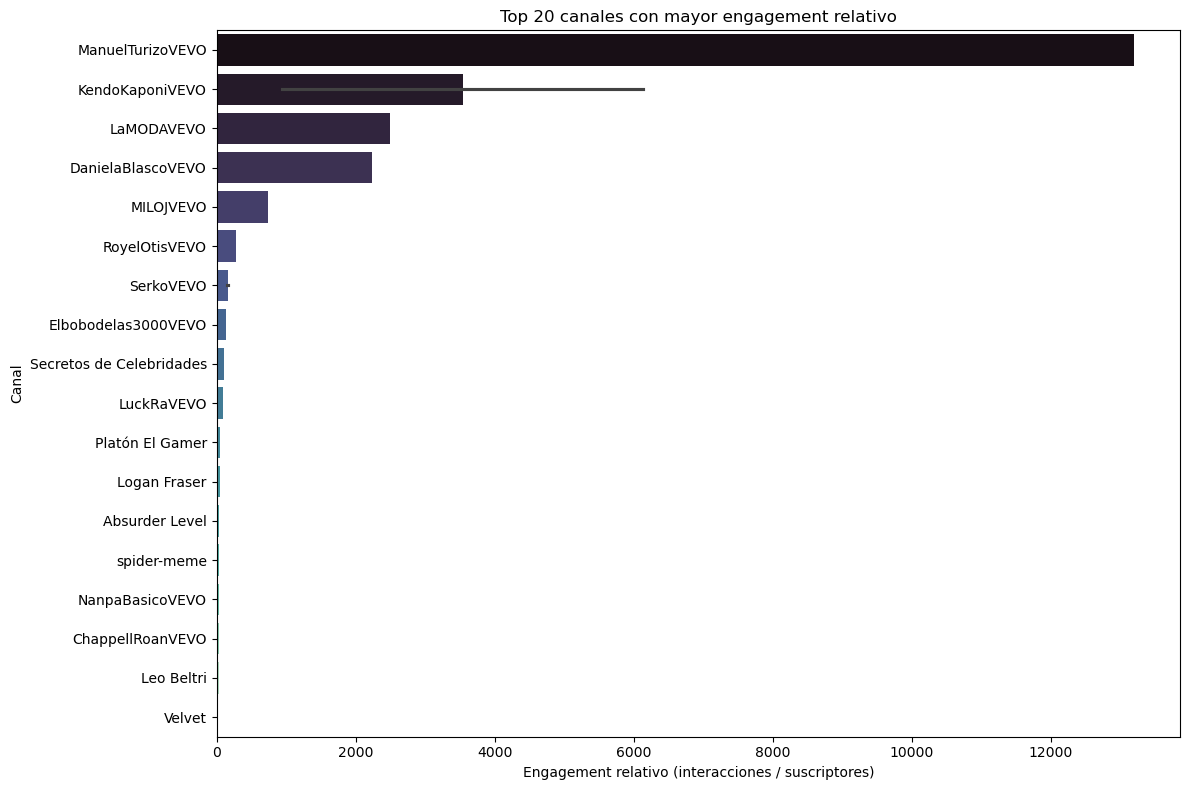

In [71]:
plt.figure(figsize=(12,8))
sns.barplot(
    data=ranking_engsub,
    x="engagement_subscribers",
    y="channel_title",
    palette="mako"
)
plt.xlabel("Engagement relativo (interacciones / suscriptores)")
plt.ylabel("Canal")
plt.title("Top 20 canales con mayor engagement relativo")
plt.tight_layout()
plt.show()

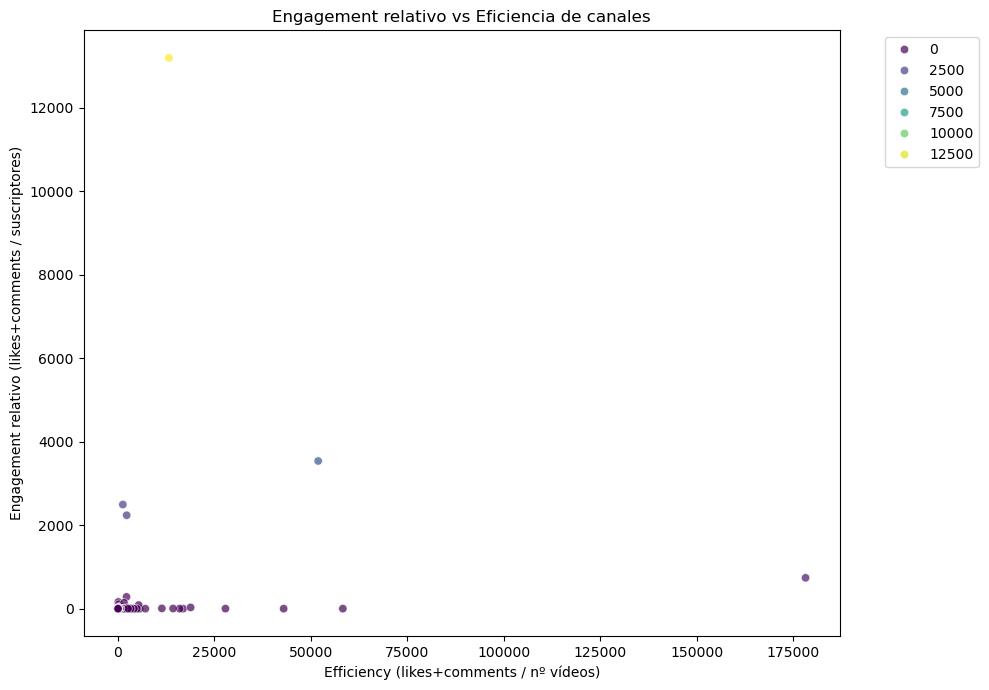

In [72]:

canal_stats = (df_1
    .groupby(["channel_id","channel_title"], as_index=False)
    .agg(efficiency=("efficiency","mean"),
         engagement_subscribers=("engagement_subscribers","mean"))
)

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=canal_stats,
    x="efficiency", 
    y="engagement_subscribers",
#    size="indice_compuesto",       # si ya calculaste índice combinado
    hue="engagement_subscribers",
    sizes=(50, 400),
    palette="viridis",
    alpha=0.7
)
plt.xlabel("Efficiency (likes+comments / nº vídeos)")
plt.ylabel("Engagement relativo (likes+comments / suscriptores)")
plt.title("Engagement relativo vs Eficiencia de canales")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

¿Hay canales pequeños con seguidores muy fieles?

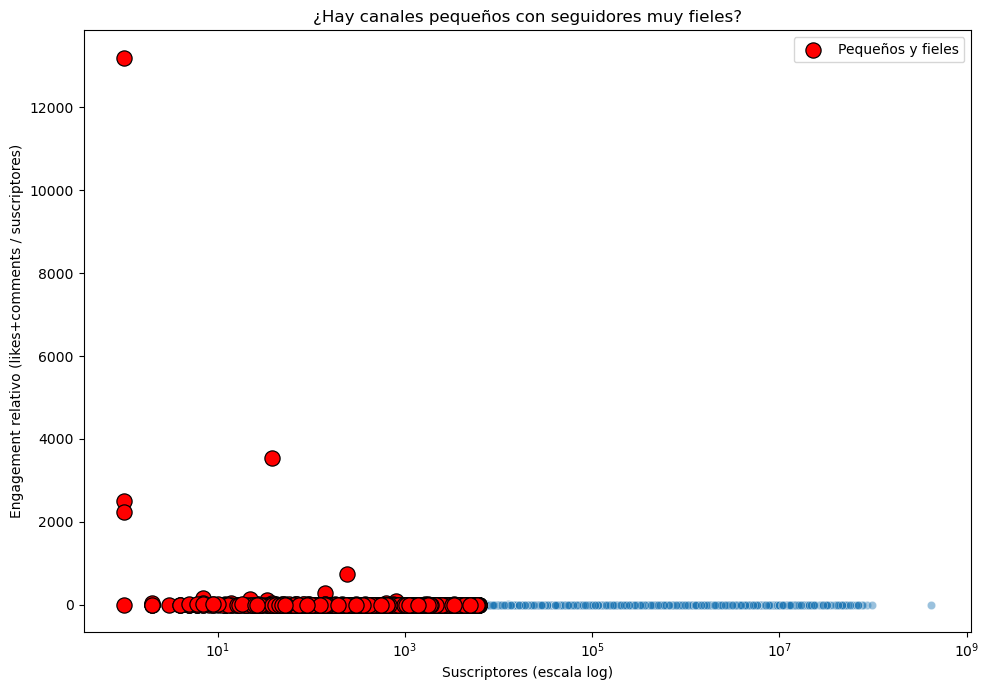

                 channel_title  subscribers  engagement_subscribers  \
285           ManuelTurizoVEVO            1            13195.000000   
5097           KendoKaponiVEVO           38             3538.421053   
5121                LaMODAVEVO            1             2495.000000   
6623         DanielaBlascoVEVO            1             2238.000000   
8875                 MILOJVEVO          241              739.647303   
6283             RoyelOtisVEVO          140              282.692857   
2943                 SerkoVEVO            7              162.000000   
7470       Elbobodelas3000VEVO           22              142.318182   
6095  Secretos de Celebridades           34              107.088235   
4172                LuckRaVEVO          799               87.066333   

         efficiency  
285    13195.000000  
5097   51896.250000  
5121    1247.500000  
6623    2238.000000  
8875  178255.000000  
6283    2198.722222  
2943      81.000000  
7470    1565.500000  
6095     214.176471 

In [73]:
canal_stats = (df_1
    .groupby(["channel_id","channel_title"], as_index=False)
    .agg(efficiency=("efficiency","mean"),
         engagement_subscribers=("engagement_subscribers","mean"))
)

# 2) Traer el número de suscriptores por canal (máximo observado)
subs_por_canal = (df_1
    .groupby(["channel_id"], as_index=False)
    .agg(subscribers=("subscriber_count","max"))
)

# 3) Merge -> ahora canal_stats tiene 'subscribers'
canal_stats = canal_stats.merge(subs_por_canal, on="channel_id", how="left")

# 4) Definir umbrales para "canal pequeño" y "fiel"
low_subs = canal_stats["subscribers"].quantile(0.25)           # 25% inferior en subs
high_engsub = canal_stats["engagement_subscribers"].quantile(0.75)  # 25% superior en engagement relativo

# 5) Filtrar canales pequeños con comunidad fiel
canales_fieles = canal_stats[
    (canal_stats["subscribers"] <= low_subs) &
    (canal_stats["engagement_subscribers"] >= high_engsub)
].copy()

# 6) Scatter general + destacados
plt.figure(figsize=(10,7))
ax = sns.scatterplot(
    data=canal_stats,
    x="subscribers",
    y="engagement_subscribers",
    alpha=0.45
)

# resaltar en rojo los pequeños pero fieles
sns.scatterplot(
    data=canales_fieles,
    x="subscribers",
    y="engagement_subscribers",
    s=120, color="red", edgecolor="k", label="Pequeños y fieles", ax=ax
)

plt.xscale("log")  # subs suele estar muy sesgado
plt.xlabel("Suscriptores (escala log)")
plt.ylabel("Engagement relativo (likes+comments / suscriptores)")
plt.title("¿Hay canales pequeños con seguidores muy fieles?")
plt.legend()
plt.tight_layout()
plt.show()

# (Opcional) Top 10 de pequeños y fieles
cols = ["channel_title","subscribers","engagement_subscribers","efficiency"]
print(canales_fieles.sort_values("engagement_subscribers", ascending=False)[cols].head(10))

## COMPARATIVA ENTRE CANALES

Ranking de canales más efectivos por suscriptores vs engagement

       channel_title  channel_views  channel_video_count  views_per_video
8358       Bad Bunny    42346847724                  189     2.240574e+08
10490     KarolGVEVO    23584324314                  124     1.901962e+08
6191         KAROL G    30107471353                  165     1.824695e+08
7257     EminemMusic    34971644186                  208     1.681329e+08
262       The Weeknd    33337600896                  201     1.658587e+08
3328   Justin Bieber    35568211924                  252     1.411437e+08
5526   Natanael Cano     5522920788                   47     1.175090e+08
4711        Anuel AA    21149662127                  186     1.137079e+08
5712         MrBeast    91027481209                  886     1.027398e+08
10508   Paulo Londra     9948365229                  104     9.565736e+07


/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/128088149.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


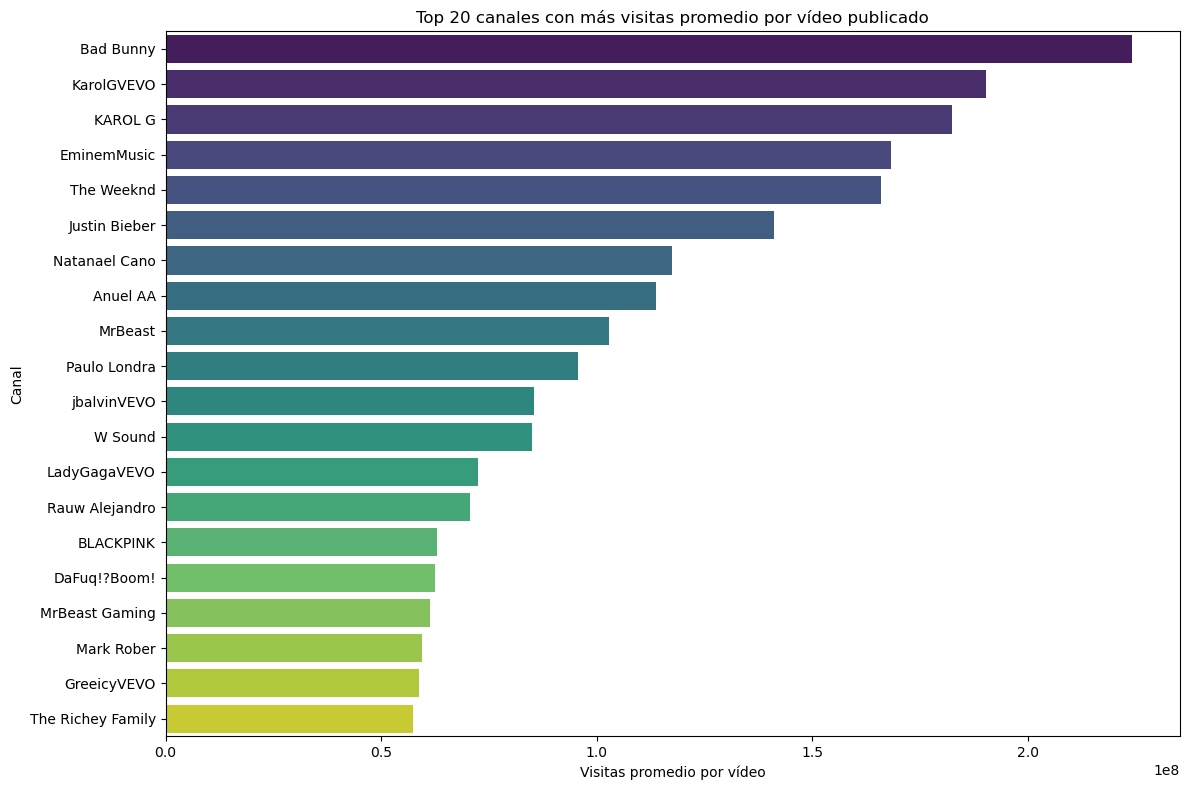

In [74]:
canal_views = (df_1
    .groupby(["channel_id","channel_title"], as_index=False)
    .agg(channel_views=("channel_views","max"),
         channel_video_count=("channel_video_count","max"))
)

# Evitar divisiones por 0
canal_views["views_per_video"] = np.where(
    canal_views["channel_video_count"] > 0,
    canal_views["channel_views"] / canal_views["channel_video_count"],
    0
)

ranking = canal_views.sort_values("views_per_video", ascending=False)
print(ranking[["channel_title","channel_views","channel_video_count","views_per_video"]].head(10))
topN = 20
plt.figure(figsize=(12,8))
sns.barplot(
    data=ranking.head(topN),
    x="views_per_video",
    y="channel_title",
    palette="viridis"
)
plt.xlabel("Visitas promedio por vídeo")
plt.ylabel("Canal")
plt.title(f"Top {topN} canales con más visitas promedio por vídeo publicado")
plt.tight_layout()
plt.show()

In [75]:
canal_views.sort_values(by="channel_views", ascending=False)

channel_id       channel_title  channel_views  \
5712  UCX6OQ3DkcsbYNE6H8uQQuVA             MrBeast    91027481209   
3441  UCJfNJmcv6LXCDsaa2kB_-7A          MaviGadget    42370799600   
8358  UCmBA_wu8xGg1OfOkfW13Q0Q           Bad Bunny    42346847724   
443   UC1a2ZCw7tugRZYRMnecNj3A         Celine Dept    41674884963   
727   UC3IZKseVpdzPSBaWxBxundA         HYBE LABELS    41289695977   
...                        ...                 ...            ...   
7879  UCjDBi1Y6Ko1SdyWZ39gSC8g     Mipymet Oficial            249   
1897  UCAGvfhB1ShR9q2lYHzhchxw  Codigo Emprendedor            147   
7223  UCf4k4XxLhyhBVqn2Sm8LVUg     Release - Topic            124   
3791  UCLv67FtTbwtRGUTuH-vTJ7A       Sherlock Code             75   
5018  UCTCPuE3FWjDWoWyDb_LqUGw         CiberTrucos             52   

      channel_video_count  views_per_video  
5712                  886     1.027398e+08  
3441                 7835     5.407888e+06  
8358                  189     2.240574e+08  
443                  1604     2.598185e+07  
727                  2757     1.497631e+07  
...                   ...              ...  
7879                    1     2.490000e+02  
1897                    3     4.900000e+01  
7223                    1     1.240000e+02  
3791                    1     7.500000e+01  
5018                    3     1.733333e+01  

[10637 rows x 5 columns]

### Frecuencia de publicacion

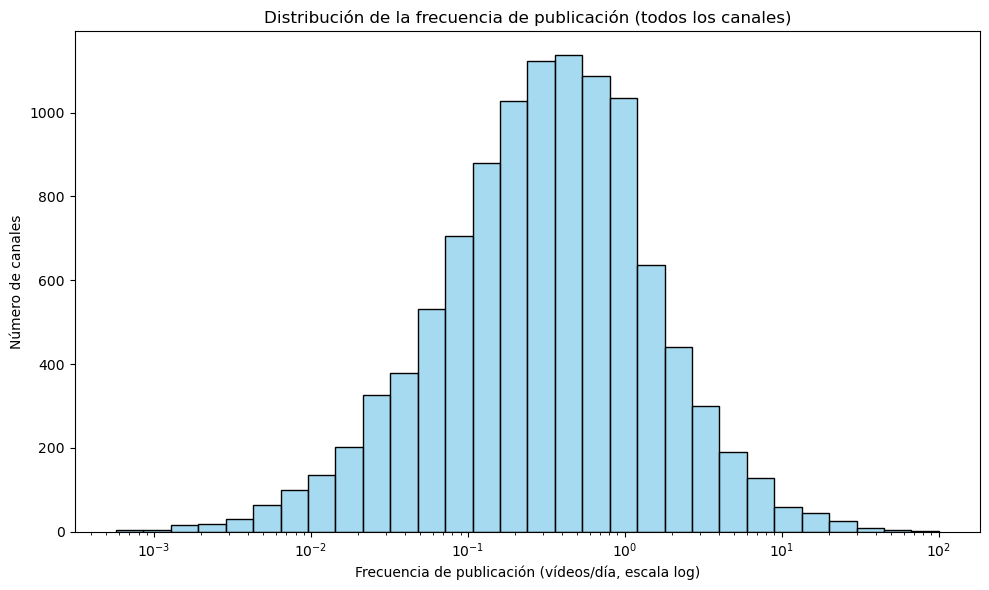

In [78]:
canal_stats = (df_1
    .groupby(["channel_id","channel_title"], as_index=False)
    .agg(channel_video_count=("channel_video_count","max"),
         channel_age_days=("channel_age_days","max"),
         efficiency=("efficiency","mean"),
         engagement_subscribers=("engagement_subscribers","mean"))
)
# Frecuencia de publicación = vídeos subidos por día
canal_stats["frecuencia"] = np.where(
    canal_stats["channel_age_days"] > 0,
    canal_stats["channel_video_count"] / canal_stats["channel_age_days"],
    0
)

plt.figure(figsize=(10,6))
sns.histplot(
    data=canal_stats,
    x="frecuencia",
    bins=30,
    log_scale=(True, False),   # log en X
    color="skyblue",
    edgecolor="black"
)

plt.xlabel("Frecuencia de publicación (vídeos/día, escala log)")
plt.ylabel("Número de canales")
plt.title("Distribución de la frecuencia de publicación (todos los canales)")
plt.tight_layout()
plt.show()

•	¿Qué canal mantiene mejor la frecuencia de publicación vs engagement?

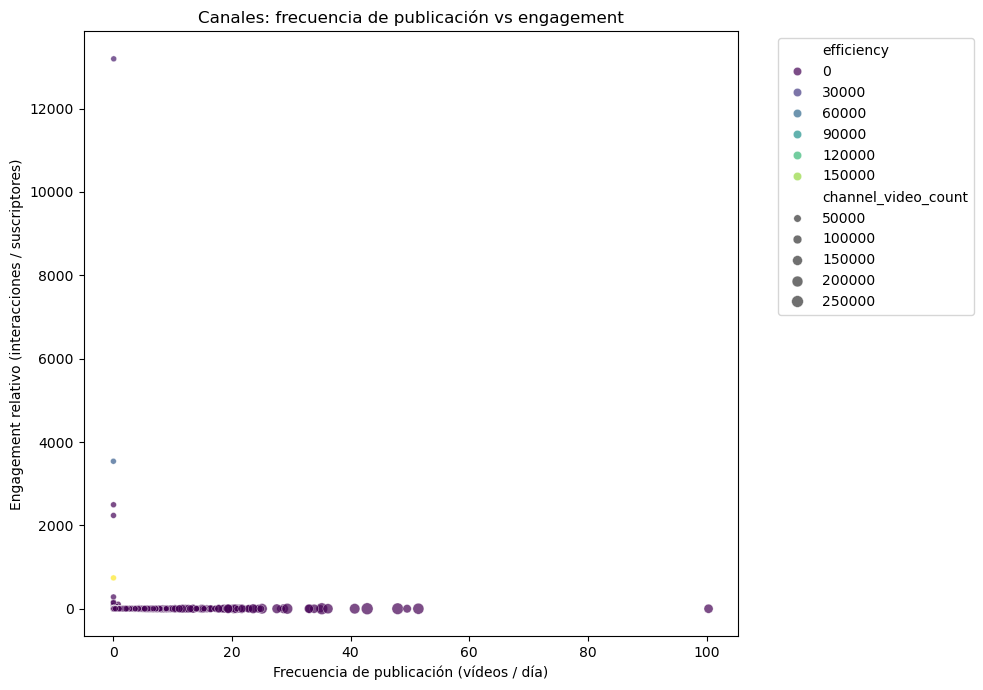

In [79]:

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=canal_stats,
    x="frecuencia",
    y="engagement_subscribers",   # o usa "efficiency" si prefieres
    size="channel_video_count",   # tamaño = volumen total de vídeos
    hue="efficiency",             # color según eficiencia media
    palette="viridis",
    alpha=0.7
)

#plt.xscale("log")   # escala log para frecuencia (suele estar muy sesgada)
plt.xlabel("Frecuencia de publicación (vídeos / día)")
plt.ylabel("Engagement relativo (interacciones / suscriptores)")
plt.title("Canales: frecuencia de publicación vs engagement")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

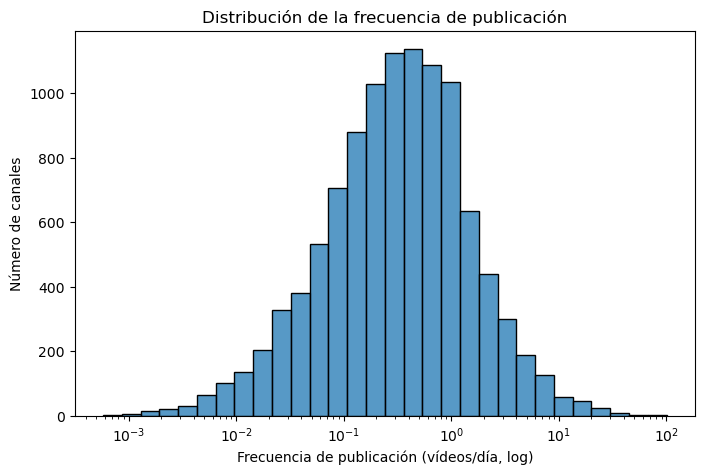

In [80]:
plt.figure(figsize=(8,5))
sns.histplot(canal_stats["frecuencia"], bins=30, log_scale=True)
plt.xlabel("Frecuencia de publicación (vídeos/día, log)")
plt.ylabel("Número de canales")
plt.title("Distribución de la frecuencia de publicación")
plt.show()

Super activos

In [81]:
top_activos = (canal_stats
    .sort_values(["frecuencia","engagement_subscribers"], ascending=[False,False])
    .head(50)
)
print(top_activos[["channel_title","frecuencia","engagement_subscribers"]])

                        channel_title  frecuencia  engagement_subscribers
7557                              ViX  100.336113                0.000024
205                           eltrece   51.418204                0.000007
10071                     Negocios TV   49.519252                0.000198
6779                  Imagen Noticias   47.923882                0.000301
1302                      Crunchyroll   42.785762                0.066459
8304                        EXCELSIOR   40.683231                0.000021
8829                           CDN 37   36.173225                0.000270
2848                          MILENIO   35.136306                0.000042
888            HardReset_info Español   34.905671                0.000003
8906           HCH Televisión Digital   33.849810                0.000053
5312                   Sin Censura TV   33.089975                0.000382
9454                  TN23 Guatemala    32.960707                0.000012
7617                     Europa Press 

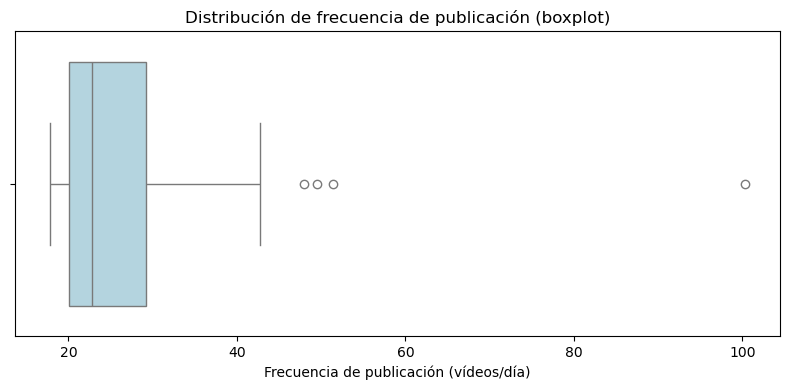

In [82]:
plt.figure(figsize=(8,4))
sns.boxplot(x=top_activos["frecuencia"], color="lightblue")
#plt.xscale("log")
plt.xlabel("Frecuencia de publicación (vídeos/día)")
plt.title("Distribución de frecuencia de publicación (boxplot)")
plt.tight_layout()
plt.show()

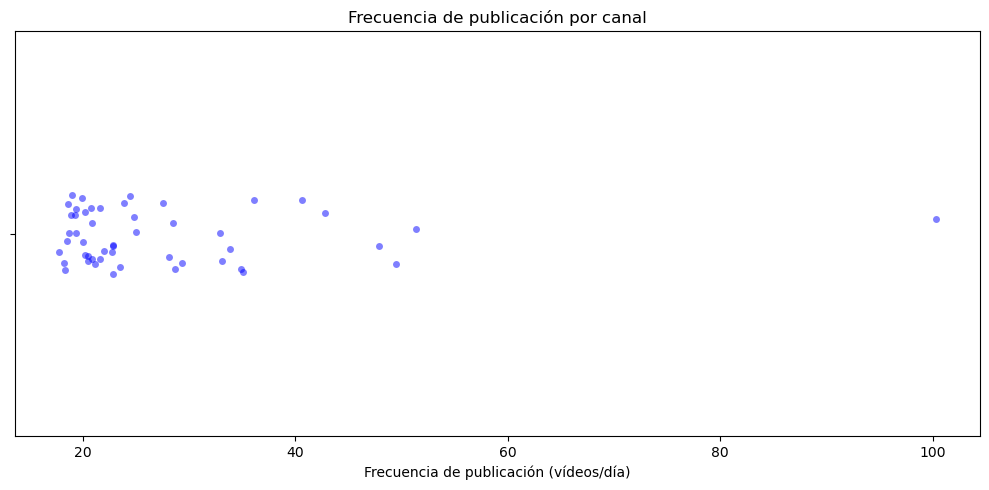

In [83]:
plt.figure(figsize=(10,5))
sns.stripplot(
    x=top_activos["frecuencia"],
    color="blue",
    alpha=0.5
)
#plt.xscale("log")
plt.xlabel("Frecuencia de publicación (vídeos/día)")
plt.title("Frecuencia de publicación por canal")
plt.tight_layout()
plt.show()

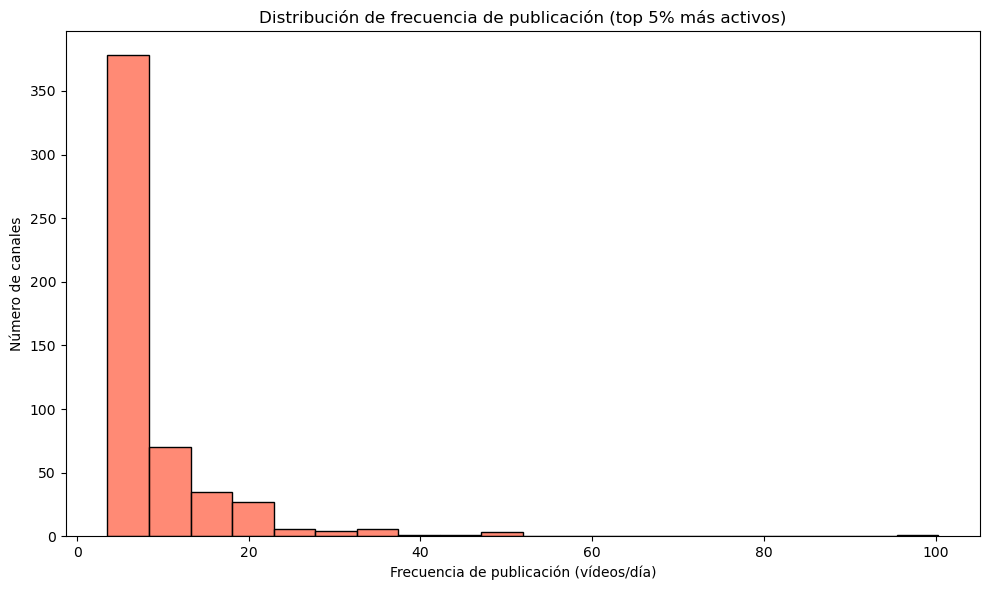

In [84]:
umbral = canal_stats["frecuencia"].quantile(0.95)

plt.figure(figsize=(10,6))
sns.histplot(
    data=canal_stats[canal_stats["frecuencia"] > umbral],
    x="frecuencia",
    bins=20,
    color="tomato",
    edgecolor="black"
)

plt.xlabel("Frecuencia de publicación (vídeos/día)")
plt.ylabel("Número de canales")
plt.title("Distribución de frecuencia de publicación (top 5% más activos)")
plt.tight_layout()
plt.show()

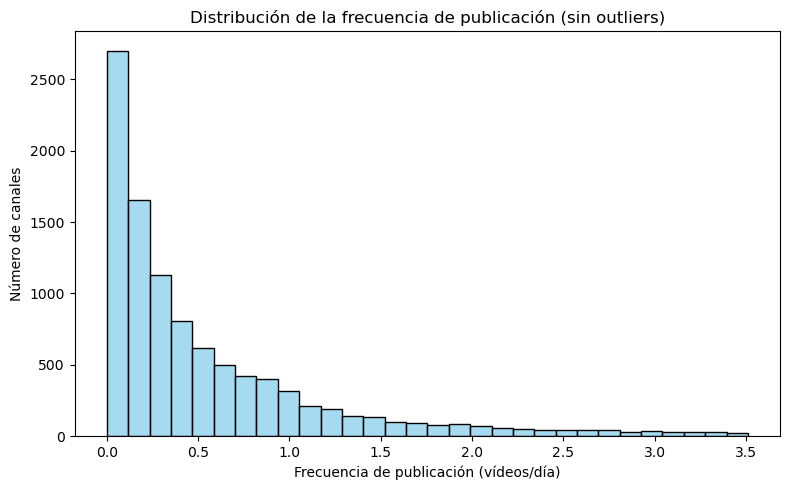

In [85]:
# Cortar en el percentil 95
umbral = canal_stats["frecuencia"].quantile(0.95)

plt.figure(figsize=(8,5))
sns.histplot(canal_stats[canal_stats["frecuencia"] <= umbral]["frecuencia"], bins=30, color="skyblue")
plt.xlabel("Frecuencia de publicación (vídeos/día)")
plt.ylabel("Número de canales")
plt.title("Distribución de la frecuencia de publicación (sin outliers)")
plt.tight_layout()
plt.show()

### Frecuencia y engagement

In [86]:
canal_stats = (df_1
    .groupby(["channel_id","channel_title"], as_index=False)
    .agg(channel_views=("channel_views","max"),
         channel_video_count=("channel_video_count","max"),
         channel_age_days=("channel_age_days","max"))
)

# Frecuencia de publicación = vídeos / días
canal_stats["frecuencia"] = np.where(
    canal_stats["channel_age_days"] > 0,
    canal_stats["channel_video_count"] / canal_stats["channel_age_days"],
    0
)

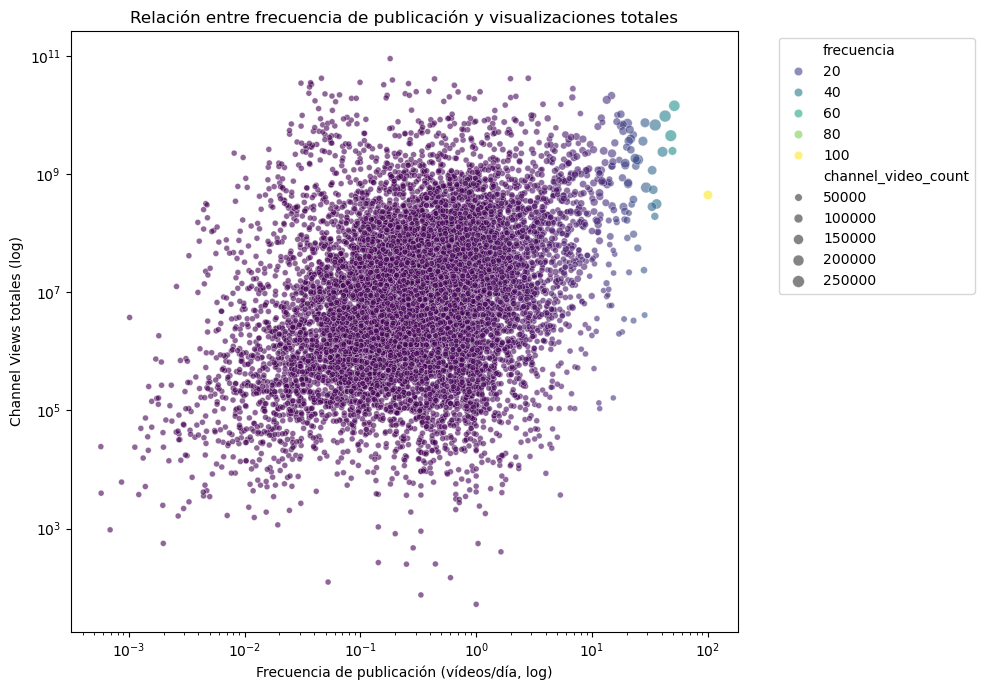

In [87]:

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=canal_stats,
    x="frecuencia",
    y="channel_views",
    size="channel_video_count",  # tamaño según nº de vídeos
    hue="frecuencia",
    palette="viridis",
    alpha=0.6
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frecuencia de publicación (vídeos/día, log)")
plt.ylabel("Channel Views totales (log)")
plt.title("Relación entre frecuencia de publicación y visualizaciones totales")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

In [88]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, pval_p = pearsonr(canal_stats["frecuencia"], canal_stats["channel_views"])
spearman_corr, pval_s = spearmanr(canal_stats["frecuencia"], canal_stats["channel_views"])

print("Correlación de Pearson:", pearson_corr)
print("Correlación de Spearman:", spearman_corr)

Correlación de Pearson: 0.09921019495091228
Correlación de Spearman: 0.28486371355610945


### ENGAGEMENT FRECUENCIA 

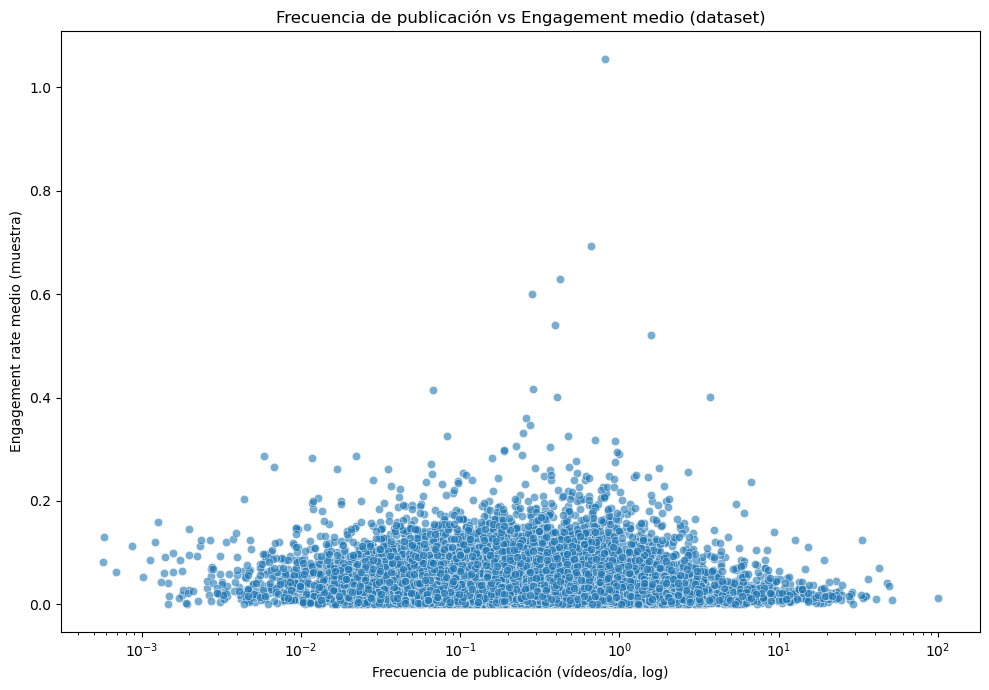

In [89]:
canal_eng = (df_1
    .groupby(["channel_id","channel_title"], as_index=False)
    .agg(channel_video_count=("channel_video_count","max"),
         channel_age_days=("channel_age_days","max"),
         engagement_rate=("engagement_rate","mean"))
)

canal_eng["frecuencia"] = np.where(
    canal_eng["channel_age_days"] > 0,
    canal_eng["channel_video_count"] / canal_eng["channel_age_days"],
    0
)

# scatter frecuencia vs engagement medio
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=canal_eng,
    x="frecuencia",
    y="engagement_rate",
    alpha=0.6
)
plt.xscale("log")
plt.xlabel("Frecuencia de publicación (vídeos/día, log)")
plt.ylabel("Engagement rate medio (muestra)")
plt.title("Frecuencia de publicación vs Engagement medio (dataset)")
plt.tight_layout()
plt.show()

In [90]:
canal_eng

channel_id                      channel_title  \
0      UC--2HA4pkpcmJrtbbXeCJAw                  Boom de Estrellas   
1      UC--QiU9Zn6_rD18Pp3-C5uw               Fan Cuồng Ngoại Hạng   
2      UC-11gdZw8ipKe_DOKH6cF6w                             Bullfy   
3      UC-1BWF1CIbuOtlWSSfto4Vw                Albania inexplorada   
4      UC-1IP4NH4ZUemFcYlpVEygA                         HikenGames   
...                         ...                                ...   
10632  UCzxzGERyMJA3SBuxYAHhTiw           María Blaquier Astróloga   
10633  UCzy8cUBs1BNTNf1bu--fn7A  electrónica automotriz desde cero   
10634  UCzyLOV-Z1oaRGFGr5koHVxA             La Chica del Dividendo   
10635  UCzysmlDbxCHWD28JCg79GQw                        Dr Lliteras   
10636  UCzz7U27ZdHMpdhU89qC33_A                 Maestro Carpintero   

       channel_video_count  channel_age_days  engagement_rate  frecuencia  
0                       75                36         0.013463    2.083333  
1                      763               639         0.009224    1.194053  
2                       48               475         0.074096    0.101053  
3                       46               124         0.004193    0.370968  
4                      780              2645         0.026003    0.294896  
...                    ...               ...              ...         ...  
10632                  845              2577         0.119491    0.327901  
10633                 2410              2077         0.015794    1.160327  
10634                   49               724         0.080520    0.067680  
10635                 1441              1482         0.176471    0.972335  
10636                  194               557         0.027847    0.348294  

[10637 rows x 6 columns]

In [91]:
# 0) Si no existe engagement_rate a nivel de vídeo, créalo en df_1
if "engagement_rate" not in df_1.columns:
    df_1["engagement_rate"] = (df_1["likes"] + df_1["comments"]) / df_1["views"].replace(0, np.nan)

# 1) Tabla base de canal con frecuencia (si ya la tienes, sáltalo)
canal_stats = (df_1
    .groupby(["channel_id","channel_title"], as_index=False)
    .agg(channel_views=("channel_views","max"),
         channel_video_count=("channel_video_count","max"),
         channel_age_days=("channel_age_days","max"))
)
canal_stats["frecuencia"] = np.where(
    canal_stats["channel_age_days"] > 0,
    canal_stats["channel_video_count"] / canal_stats["channel_age_days"],
    0.0
)

# 2) Engagement medio por canal (sobre tu muestra)
eng_por_canal = (df_1
    .groupby(["channel_id"], as_index=False)
    .agg(engagement_rate=("engagement_rate","mean"))
)

# 3) Unirlo a canal_stats
canal_stats = canal_stats.merge(eng_por_canal, on="channel_id", how="left")

# 4) Quitar NaN para correlaciones
tmp = canal_stats[["frecuencia","engagement_rate"]].dropna()

# 5) Correlaciones
pearson_corr, pval_p = pearsonr(tmp["frecuencia"], tmp["engagement_rate"])
spearman_corr, pval_s = spearmanr(tmp["frecuencia"], tmp["engagement_rate"])

print("Correlación de Pearson:", pearson_corr, "| p:", pval_p)
print("Correlación de Spearman:", spearman_corr, "| p:", pval_s)

Correlación de Pearson: -0.10314529081096385 | p: 1.4891210164326075e-26
Correlación de Spearman: -0.14769298648609994 | p: 6.166892057537587e-53


FRECUENCIA ESCASO IMPACTO

In [92]:
canal_stats["views_per_video"] = np.where(
    canal_stats["channel_video_count"] > 0,
    canal_stats["channel_views"] / canal_stats["channel_video_count"],
    0
)

In [93]:
freq_low =  canal_stats["frecuencia"].quantile(0.25)
freq_high = canal_stats["frecuencia"].quantile(0.75)
impact_low = canal_stats["views_per_video"].quantile(0.25)
impact_high = canal_stats["views_per_video"].quantile(0.75)

# Filtrar canales de interés
canales_mucho_poco = canal_stats[
    (canal_stats["frecuencia"] >= freq_high) &
    (canal_stats["views_per_video"] <= impact_low)
]
canales_poco_mucho = canal_stats[
    (canal_stats["frecuencia"] <= freq_low) &
    (canal_stats["views_per_video"] >= impact_high)
]

canales_mucho_mucho = canal_stats[
    (canal_stats["frecuencia"] >= freq_high) &
    (canal_stats["views_per_video"] >= impact_high)
]

canales_poco_poco = canal_stats[
    (canal_stats["frecuencia"] <= freq_low) &
    (canal_stats["views_per_video"] <= impact_low)
]


print(canales_mucho_poco[["channel_title","frecuencia","views_per_video"]])

                 channel_title  frecuencia  views_per_video
26           DarioSpinarGaming    0.933383      3016.568164
34                Aquí En Vivo    3.341735      2780.483862
36               Canal Antigua   11.616462      1407.776119
52     Pensión Adultos Mayores    2.561089      2518.327864
57           Culé Confidencial    2.440000       474.459016
...                        ...         ...              ...
10517  La Cara Oculta De Petro    0.947368      2119.833333
10530          La salud es oro    5.200000      1029.336538
10589            LagartoShowOk   11.101644      2705.116164
10617                    Cómo?    1.593750       636.225490
10628  Noticias De Última Hora    2.113297       499.270463

[685 rows x 3 columns]


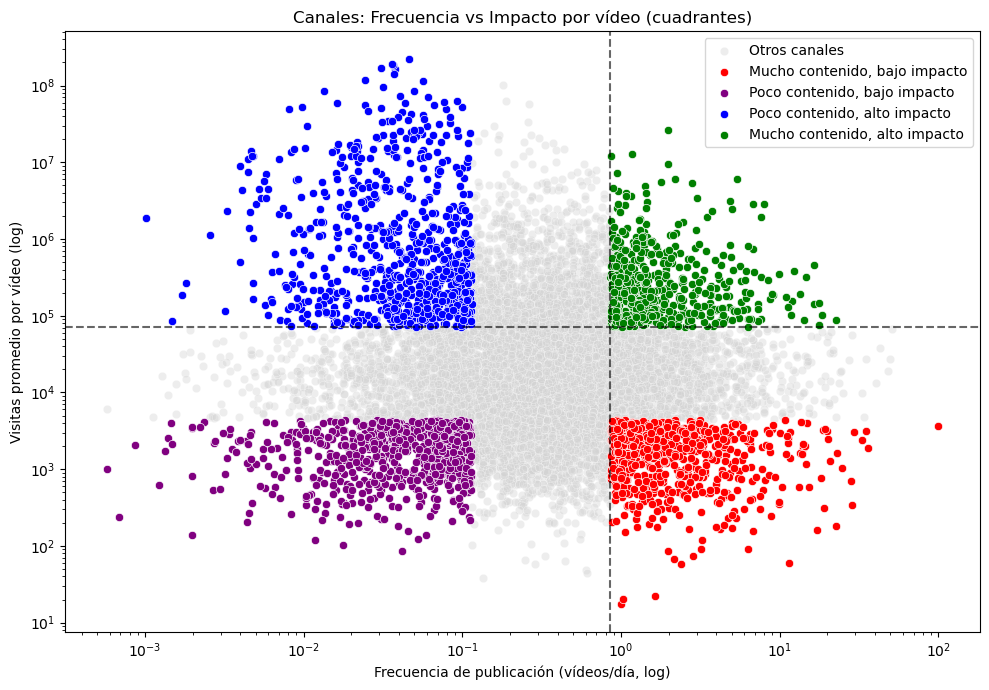

In [94]:

plt.figure(figsize=(10,7))

# Base: todos los canales en gris claro
sns.scatterplot(
    data=canal_stats,
    x="frecuencia",
    y="views_per_video",
    color="lightgray",
    alpha=0.4,
    label="Otros canales"
)

# 1) Mucho contenido, bajo impacto
sns.scatterplot(
    data=canales_mucho_poco,
    x="frecuencia",
    y="views_per_video",
    color="red",

    label="Mucho contenido, bajo impacto"
)

sns.scatterplot(
    data=canales_poco_poco,
    x="frecuencia",
    y="views_per_video",
    color="purple",

    label="Poco contenido, bajo impacto")

# 2) Poco contenido, mucho impacto
sns.scatterplot(
    data=canales_poco_mucho,
    x="frecuencia",
    y="views_per_video",
    color="blue",
 
    label="Poco contenido, alto impacto"
)

# 3) Mucho contenido, mucho impacto
sns.scatterplot(
    data=canales_mucho_mucho,
    x="frecuencia",
    y="views_per_video",
    color="green",

    label="Mucho contenido, alto impacto"
)

# Escalas logarítmicas (muy útil aquí)
plt.xscale("log")
plt.yscale("log")

# Líneas de referencia para umbrales
plt.axvline(freq_high, color="black", linestyle="--", alpha=0.6)
plt.axhline(impact_high, color="black", linestyle="--", alpha=0.6)

plt.xlabel("Frecuencia de publicación (vídeos/día, log)")
plt.ylabel("Visitas promedio por vídeo (log)")
plt.title("Canales: Frecuencia vs Impacto por vídeo (cuadrantes)")
plt.legend()
plt.tight_layout()
plt.show()

## ANÁLISIS TEMPORAL

¿La edad del canal (channel_age_days) influye en el éxito?

<Axes: xlabel='channel_age_days', ylabel='channel_views'>

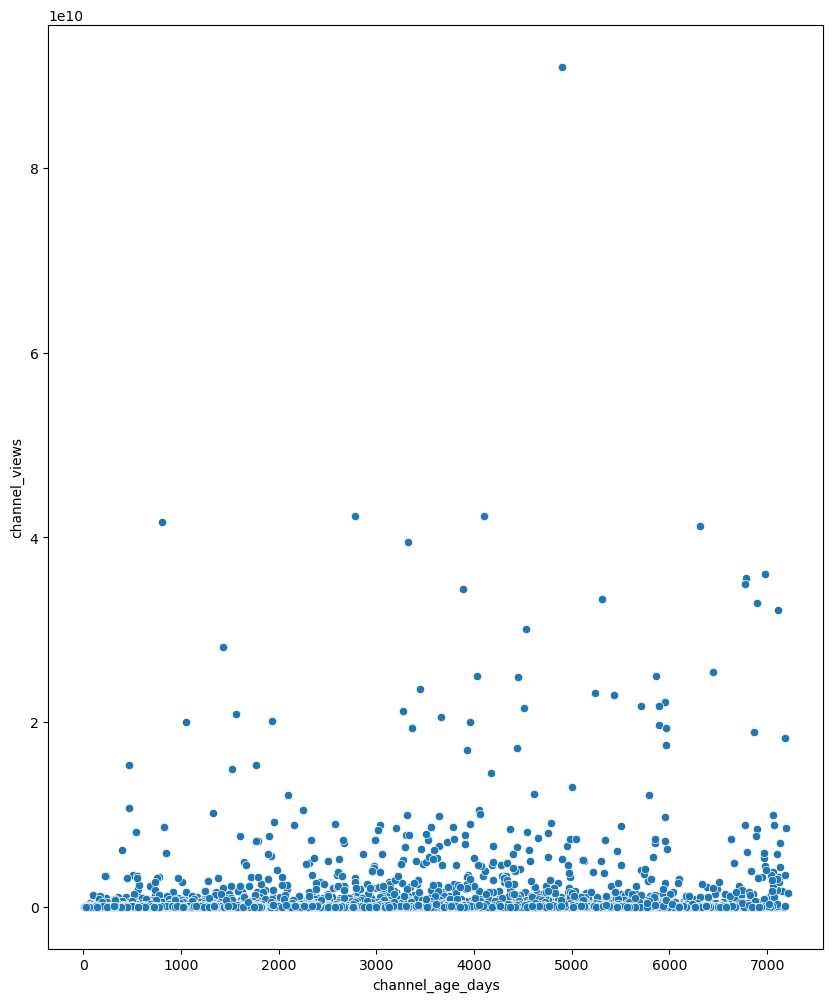

In [95]:

canal_age = (df_1
    .groupby(["channel_id","channel_title"], as_index=False)
    .agg(channel_age_days=("channel_age_days","max"),
         channel_views=("channel_views","max"),
         channel_video_count=("channel_video_count","max")))

plt.figure(figsize=(10,12))
sns.scatterplot(data=canal_age, x="channel_age_days", y="channel_views")

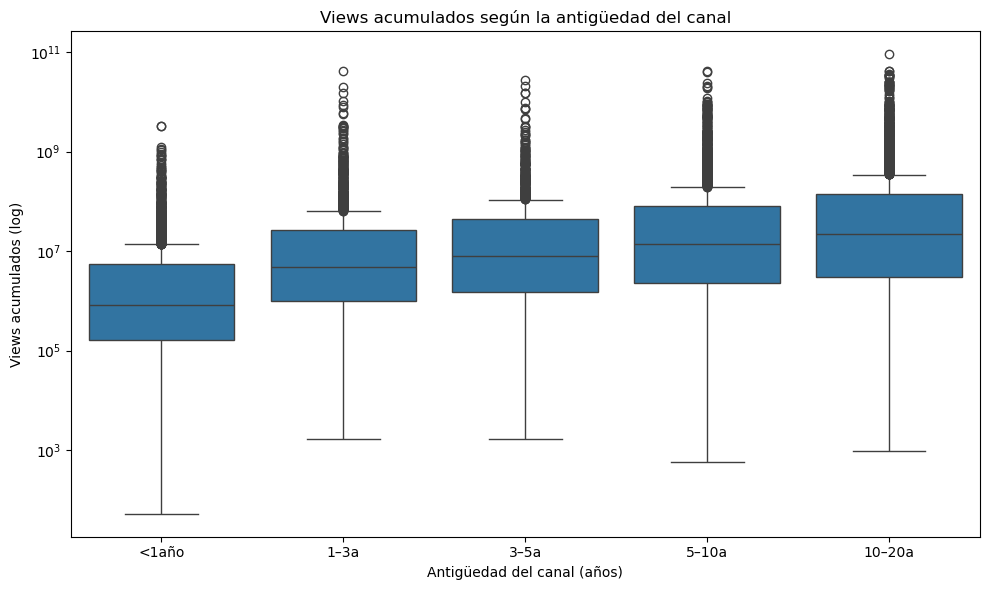

In [96]:
# Bins de edad en años
df_bins = canal_age.copy()
df_bins["age_years"] = df_bins["channel_age_days"] / 365
bins = [0,1,3,5,10,20]
labels = ["<1año","1–3a","3–5a","5–10a","10–20a"]
df_bins["age_group"] = pd.cut(df_bins["age_years"], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10,6))
sns.boxplot(data=df_bins, x="age_group", y="channel_views")
plt.yscale("log")   # escalar porque las views suelen ser muy dispares
plt.xlabel("Antigüedad del canal (años)")
plt.ylabel("Views acumulados (log)")
plt.title("Views acumulados según la antigüedad del canal")
plt.tight_layout()
plt.show()

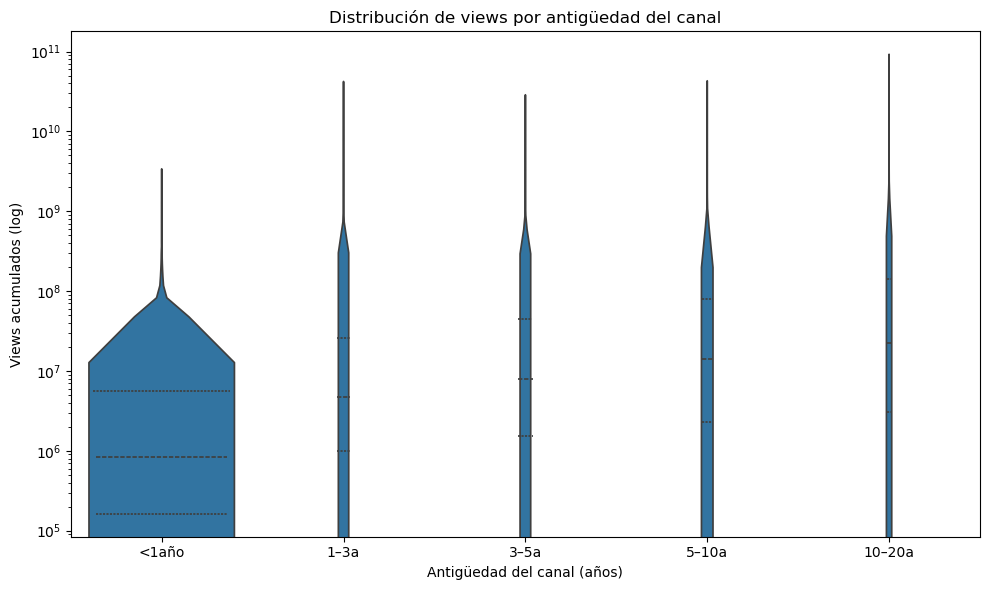

In [97]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df_bins, x="age_group", y="channel_views", inner="quartile")
plt.yscale("log")
plt.xlabel("Antigüedad del canal (años)")
plt.ylabel("Views acumulados (log)")
plt.title("Distribución de views por antigüedad del canal")
plt.tight_layout()
plt.show()

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2337177734.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend = (df_bins.groupby("age_group")["channel_views"]


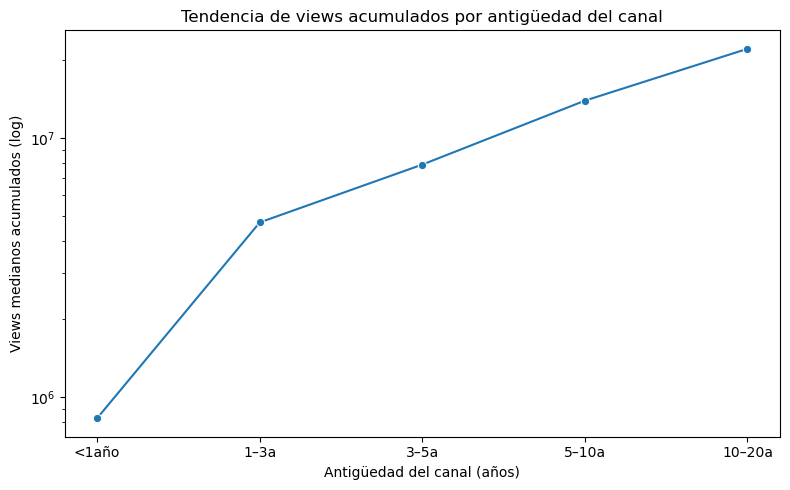

In [98]:
trend = (df_bins.groupby("age_group")["channel_views"]
         .median()
         .reset_index())

plt.figure(figsize=(8,5))
sns.lineplot(data=trend, x="age_group", y="channel_views", marker="o")
plt.yscale("log")
plt.xlabel("Antigüedad del canal (años)")
plt.ylabel("Views medianos acumulados (log)")
plt.title("Tendencia de views acumulados por antigüedad del canal")
plt.tight_layout()
plt.show()

•	Ver si canales más viejos acumulan más impacto.

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/1768169669.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medianas = canal_impacto.groupby("age_group")["Impacto_medio"].median().reset_index()


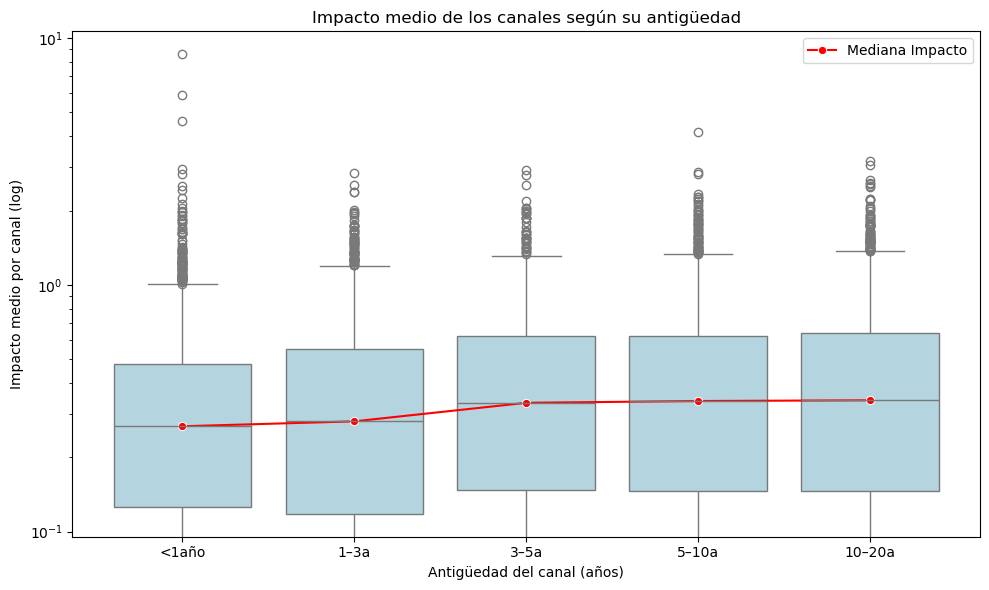

In [99]:
# Impacto medio por canal
canal_impacto = (df_1
    .groupby(["channel_id","channel_title"], as_index=False)
    .agg(channel_age_days=("channel_age_days","max"),
         Impacto_medio=("Impacto","median"))   # uso mediana para reducir outliers
)
# Convertimos a años para agrupar
canal_impacto["age_years"] = canal_impacto["channel_age_days"] / 365

bins = [0,1,3,5,10,20]
labels = ["<1año","1–3a","3–5a","5–10a","10–20a"]
canal_impacto["age_group"] = pd.cut(canal_impacto["age_years"], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10,6))

# Boxplot de impacto por grupo de edad
sns.boxplot(data=canal_impacto, x="age_group", y="Impacto_medio", color="lightblue")

# Línea con medianas
medianas = canal_impacto.groupby("age_group")["Impacto_medio"].median().reset_index()
sns.lineplot(data=medianas, x="age_group", y="Impacto_medio", marker="o", color="red", label="Mediana Impacto")

plt.yscale("log")   # impacto puede estar muy disperso
plt.xlabel("Antigüedad del canal (años)")
plt.ylabel("Impacto medio por canal (log)")
plt.title("Impacto medio de los canales según su antigüedad")
plt.legend()
plt.tight_layout()
plt.show()

##  DISTRIBUCIONES Y OUTLIERS

¿Hay canales donde un solo vídeo explica la mayoría de visitas?

In [100]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19154 entries, 0 to 19153
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                19154 non-null  object             
 1   title                   19154 non-null  object             
 2   description             15337 non-null  object             
 3   published_at            19154 non-null  datetime64[ns, UTC]
 4   duration_minutes        19154 non-null  float64            
 5   definition              19154 non-null  int64              
 6   licensed_content        19154 non-null  Int64              
 7   has_caption             19154 non-null  Int64              
 8   category_id             19154 non-null  float64            
 9   views                   19154 non-null  int64              
 10  likes                   19154 non-null  int64              
 11  comments                19154 non-null  i

In [ ]:
canal_impacto_un_video = df_1[df_1["channel_video_count"] > 1]
#     .groupby(["channel_id","channel_title"], as_index=False)
#     .agg(channel_video_count =("channel_video_count","max"),
#          Impacto_medio=("Impacto","median"))   # uso mediana para reducir outliers
# )
canal_impacto_un_video.info()
canal_impacto_un_video.groupby(["channel_id","channel_title"], as_index=False).agg(channel_video_count =("channel_video_count","max"), 

<class 'pandas.core.frame.DataFrame'>
Index: 19133 entries, 0 to 19153
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                19133 non-null  object             
 1   title                   19133 non-null  object             
 2   description             15320 non-null  object             
 3   published_at            19133 non-null  datetime64[ns, UTC]
 4   duration_minutes        19133 non-null  float64            
 5   definition              19133 non-null  int64              
 6   licensed_content        19133 non-null  Int64              
 7   has_caption             19133 non-null  Int64              
 8   category_id             19133 non-null  float64            
 9   views                   19133 non-null  int64              
 10  likes                   19133 non-null  int64              
 11  comments                19133 non-null  int64 

In [113]:
canal_stats = (
    canal_impacto_un_video
    .groupby(["channel_id", "channel_title"], as_index=False)
    .agg(
        views_mean=("views", "mean"),
        views_std=("views", "std"),
        views_max=("views", "max"),
        views_sum=("views", "sum"),
        n_videos=("video_id", "count")
    )
)
canal_stats["max_share"] = canal_stats["views_max"] / canal_stats["views_sum"]
canal_stats["max_vs_mean"] = canal_stats["views_max"] / canal_stats["views_mean"]

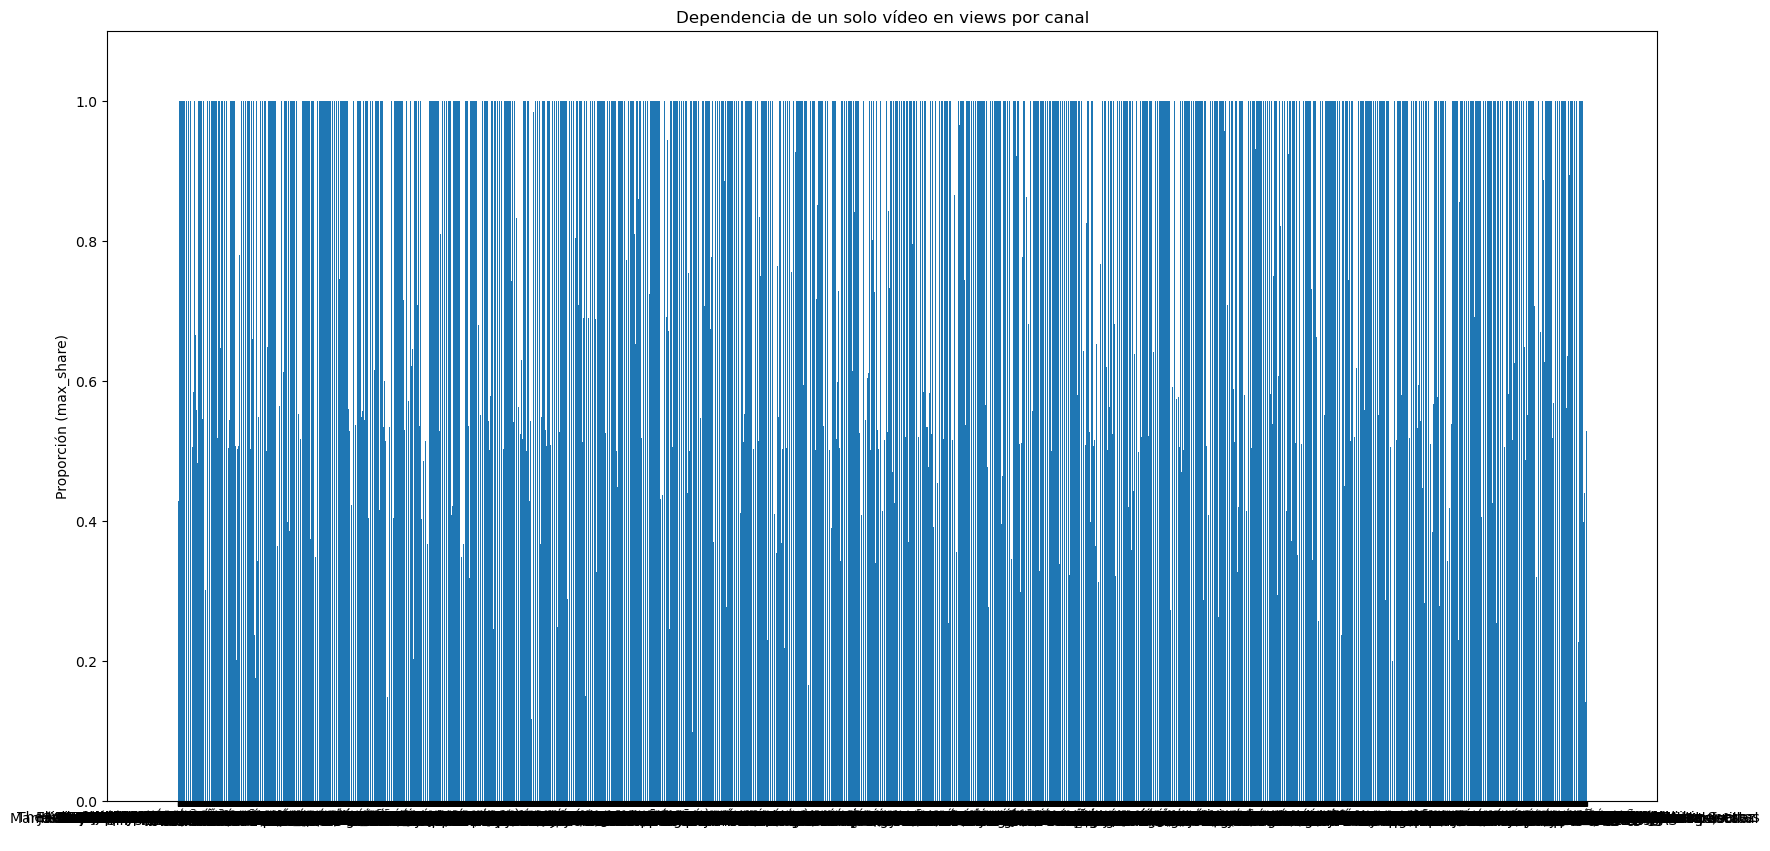

In [115]:
plt.figure(figsize=(20,10))
plt.bar(canal_stats["channel_title"], canal_stats["max_share"])
plt.title("Dependencia de un solo vídeo en views por canal")
plt.ylabel("Proporción (max_share)")
plt.ylim(0, 1.1)
plt.show()

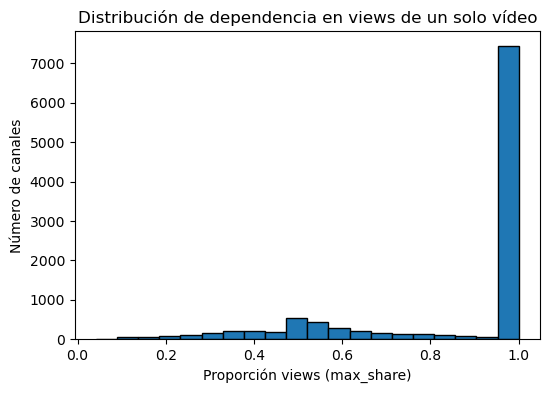

In [116]:
plt.figure(figsize=(6,4))
plt.hist(canal_stats["max_share"], bins=20, edgecolor="black")
plt.title("Distribución de dependencia en views de un solo vídeo")
plt.xlabel("Proporción views (max_share)")
plt.ylabel("Número de canales")
plt.show()

Importante ver el reparto de los videos. Si bien es cierto que en el dataset la mayoria de canales el exito se  explica por un solo video, poco menos de las 3 cuartas partes. En un cuarto se observa un reparto más equitativo entre los videos del canal.   

In [118]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–0.9", "0.9–1.0"]

# Categorizar cada canal en un bin
canal_stats["bin"] = pd.cut(canal_stats["max_share"], bins=bins, labels=labels, include_lowest=True)

# Contar frecuencias y calcular porcentaje
bin_counts = canal_stats["bin"].value_counts().sort_index()
bin_perc = (bin_counts / bin_counts.sum() * 100).round(2)

# Combinar en tabla
tabla_bins = pd.DataFrame({"N canales": bin_counts, "% sobre total": bin_perc})
print(tabla_bins)

         N canales  % sobre total
bin                              
0–0.2          125           1.18
0.2–0.4        641           6.04
0.4–0.6       1438          13.55
0.6–0.8        694           6.54
0.8–0.9        202           1.90
0.9–1.0       7516          70.80


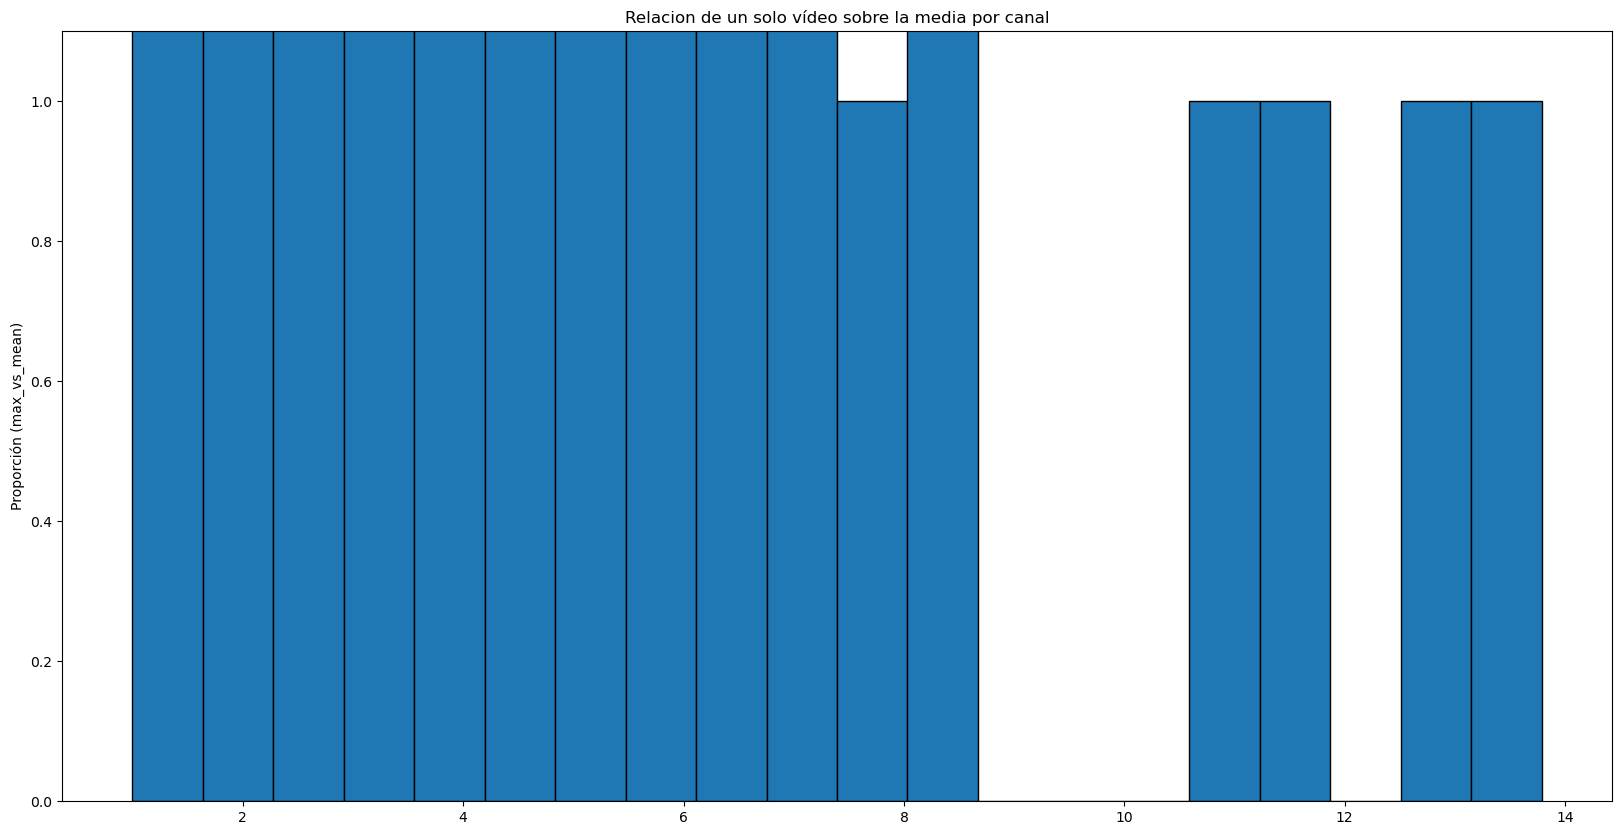

In [123]:
plt.figure(figsize=(20,10))
plt.hist(canal_stats["max_vs_mean"], bins=20,edgecolor="black")
plt.title("Relacion de un solo vídeo sobre la media por canal")
plt.ylabel("Proporción (max_vs_mean)")
plt.ylim(0, 1.1)
plt.show()

En la distribución observada, la gran mayoría de canales se concentran en valores elevados de max_vs_mean, lo que confirma que el éxito en YouTube suele estar explicado por un único contenido “estrella” que eclipsa al resto de vídeos del canal. Los casos cercanos a 1, que corresponderían a un reparto más homogéneo del impacto, son escasos en comparación.

Este patrón refuerza la conclusión de que la visibilidad de los canales está fuertemente concentrada en vídeos puntuales y no en un rendimiento sostenido de todos sus contenidos.

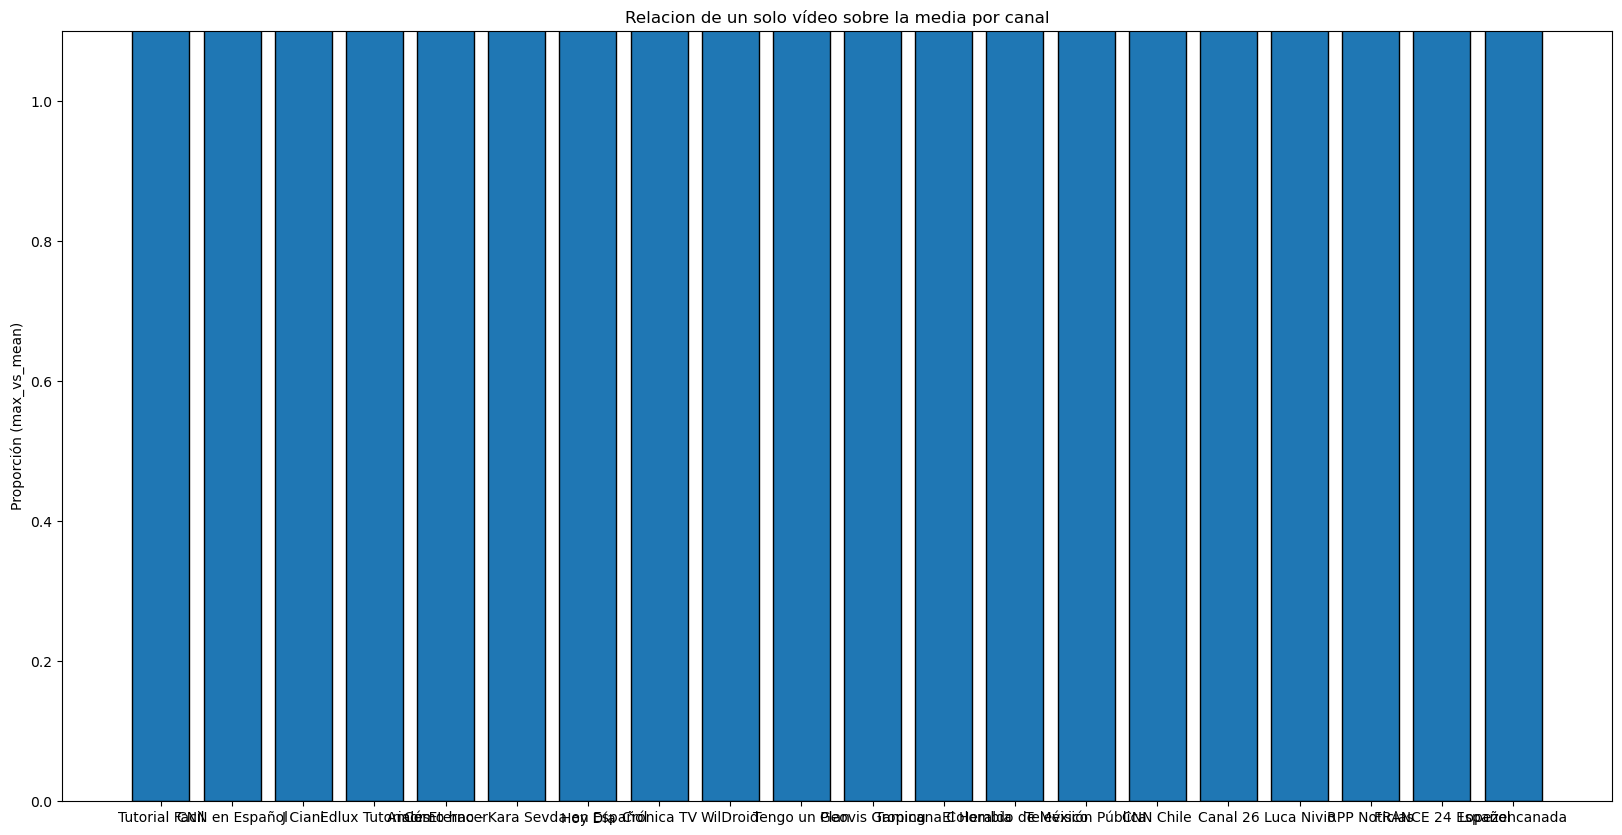

In [126]:
top20 = canal_stats.nlargest(20, "max_vs_mean")
plt.figure(figsize=(20,10))
plt.bar(top20["channel_title"], top20["max_vs_mean"], edgecolor="black")
plt.title("Relacion de un solo vídeo sobre la media por canal")
plt.ylabel("Proporción (max_vs_mean)")
plt.ylim(0, 1.1)
plt.show()

Entre los 20 canales más extremos, el vídeo estrella de cada uno concentra la mayoría del impacto, estando muy por encima de la media del canal.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Tutorial Facil'),
  Text(1, 0, 'CNN en Español'),
  Text(2, 0, 'J Ciani'),
  Text(3, 0, 'Edlux Tutoriales'),
  Text(4, 0, 'Cómo hacer'),
  Text(5, 0, 'Amor Eterno - Kara Sevda en Español'),
  Text(6, 0, 'Hoy Día'),
  Text(7, 0, 'Crónica TV'),
  Text(8, 0, 'WilDroid'),
  Text(9, 0, 'Tengo un Plan'),
  Text(10, 0, 'Geovis Gaming'),
  Text(11, 0, 'Tropicana Colombia'),
  Text(12, 0, 'El Heraldo de México'),
  Text(13, 0, 'Televisión Pública'),
  Text(14, 0, 'CNN Chile'),
  Text(15, 0, 'Canal 26'),
  Text(16, 0, 'Luca Nivio'),
  Text(17, 0, 'RPP Noticias'),
  Text(18, 0, 'FRANCE 24 Español'),
  Text(19, 0, 'Lopezencanada')])

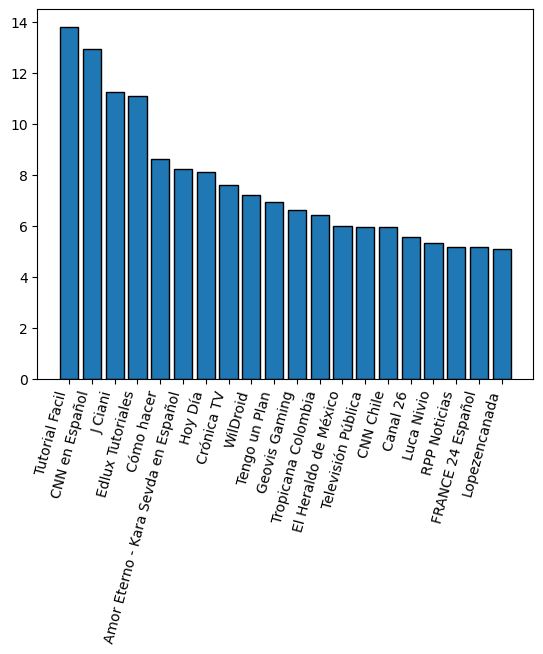

In [127]:
top20_sorted = top20.sort_values("max_vs_mean", ascending=False)
plt.bar(top20_sorted["channel_title"], top20_sorted["max_vs_mean"], edgecolor="black")
plt.xticks(rotation=75, ha="right")

 Este grafico muestra los canales cuyo vídeo con más exito concentra un volumen de visualizaciones entre 5 y 14 veces superior al promedio de su producción. Esto evidencia una fuerte dependencia de un único contenido para explicar el impacto total del canal.

In [129]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19154 entries, 0 to 19153
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                19154 non-null  object             
 1   title                   19154 non-null  object             
 2   description             15337 non-null  object             
 3   published_at            19154 non-null  datetime64[ns, UTC]
 4   duration_minutes        19154 non-null  float64            
 5   definition              19154 non-null  int64              
 6   licensed_content        19154 non-null  Int64              
 7   has_caption             19154 non-null  Int64              
 8   category_id             19154 non-null  float64            
 9   views                   19154 non-null  int64              
 10  likes                   19154 non-null  int64              
 11  comments                19154 non-null  i

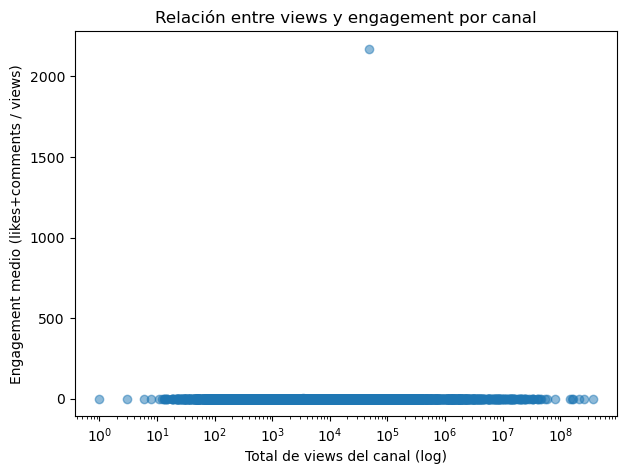

In [135]:
df_1["engagement_rate"] = (df_1["likes"] + df_1["comments"]) / df_1["views"].replace(0, 1)
canal_stats2 = (
    df_1.groupby(["channel_id", "channel_title"], as_index=False)
    .agg(
        views_sum=("views", "sum"),
        engagement_mean=("engagement_rate", "mean"),
        n_videos=("video_id", "count")
))

plt.figure(figsize=(7,5))
plt.scatter(canal_stats2["views_sum"], canal_stats2["engagement_mean"], alpha=0.5)
plt.xscale("log")  # porque views suele ser muy desigual
plt.xlabel("Total de views del canal (log)")
plt.ylabel("Engagement medio (likes+comments / views)")
plt.title("Relación entre views y engagement por canal")
plt.show()

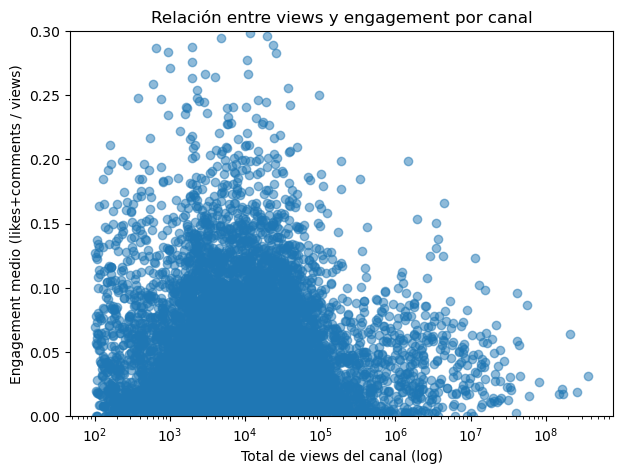

In [146]:
canal_stats2 = canal_stats2[canal_stats2["views_sum"] > 100]  # ejemplo: solo canales con >100 views totales
plt.figure(figsize=(7,5))
plt.scatter(canal_stats2["views_sum"], canal_stats2["engagement_mean"], alpha=0.5)
plt.xscale("log")  # porque views suele ser muy desigual
plt.xlabel("Total de views del canal (log)")
plt.ylabel("Engagement medio (likes+comments / views)")
plt.title("Relación entre views y engagement por canal")

plt.ylim(0, 0.3)  # mostrar solo hasta 20% de engagement
plt.show()


El engagement relativo es bajo en general. Los canales con mayor volumen de views tienden a tener menor engagement rate, lo que podría deberse a que con mayor audiencia también crece la proporción de usuarios pasivos (que ven pero no interactúan). Mientras que los canales pequeños a veces muestran engagement más alto, pero de forma dispersa y poco sistemática.

In [136]:
umbral_views = canal_stats2["views_sum"].quantile(0.9)  # top 10% en views
umbral_engagement = canal_stats2["engagement_mean"].quantile(0.1)  # bottom 10% en engagement

canales_muchos_views_poco_engagement = canal_stats2[
    (canal_stats2["views_sum"] >= umbral_views) &
    (canal_stats2["engagement_mean"] <= umbral_engagement)
]

In [140]:
canales_muchos_views_poco_engagement

channel_id                     channel_title  views_sum  \
18     UC-AVSNvCVhzi0_dwjh-9OIQ                    Aquarius Music     251918   
48     UC-K6fa6T9oaOuMVwHDsoPYA                      Mundo Dembow     590121   
97     UC-_pA7VRirBYGouvLS2v-cA                          RockHype     140146   
101    UC-bk3CDvTwt2TqPHykduhcQ                             UnoTV     138075   
291    UC0gY8Boruzdlgp0m_vfO0CQ                        LatinVerse     888504   
...                         ...                               ...        ...   
10272  UCxtVICGVfz8FDnStJ6-nkMQ                      Lynn Covers༄      86711   
10444  UCytFQMZQhb0kfEIARX_fdHw                      Pulso Latino    1352069   
10533  UCzQMShBXs2eQoUr2w8L5Uyg  Mundo de secretos y curiosidades     161165   
10551  UCzWXJk5VK_8mAJgW1WerRJw                       Audio Music     336723   
10611  UCznpMscBCzKggKpDuEKZn0Q                 FUMIMOTOR Pereira      88818   

       engagement_mean  n_videos  
18            0.003230         4  
48            0.002062         5  
97            0.006158         1  
101           0.006555         5  
291           0.002072         4  
...                ...       ...  
10272         0.002134         3  
10444         0.002964         2  
10533         0.004246         7  
10551         0.004846         3  
10611         0.005713         3  

[152 rows x 5 columns]

•	¿Cuánto pesa el número de suscriptores en el éxito real del vídeo?


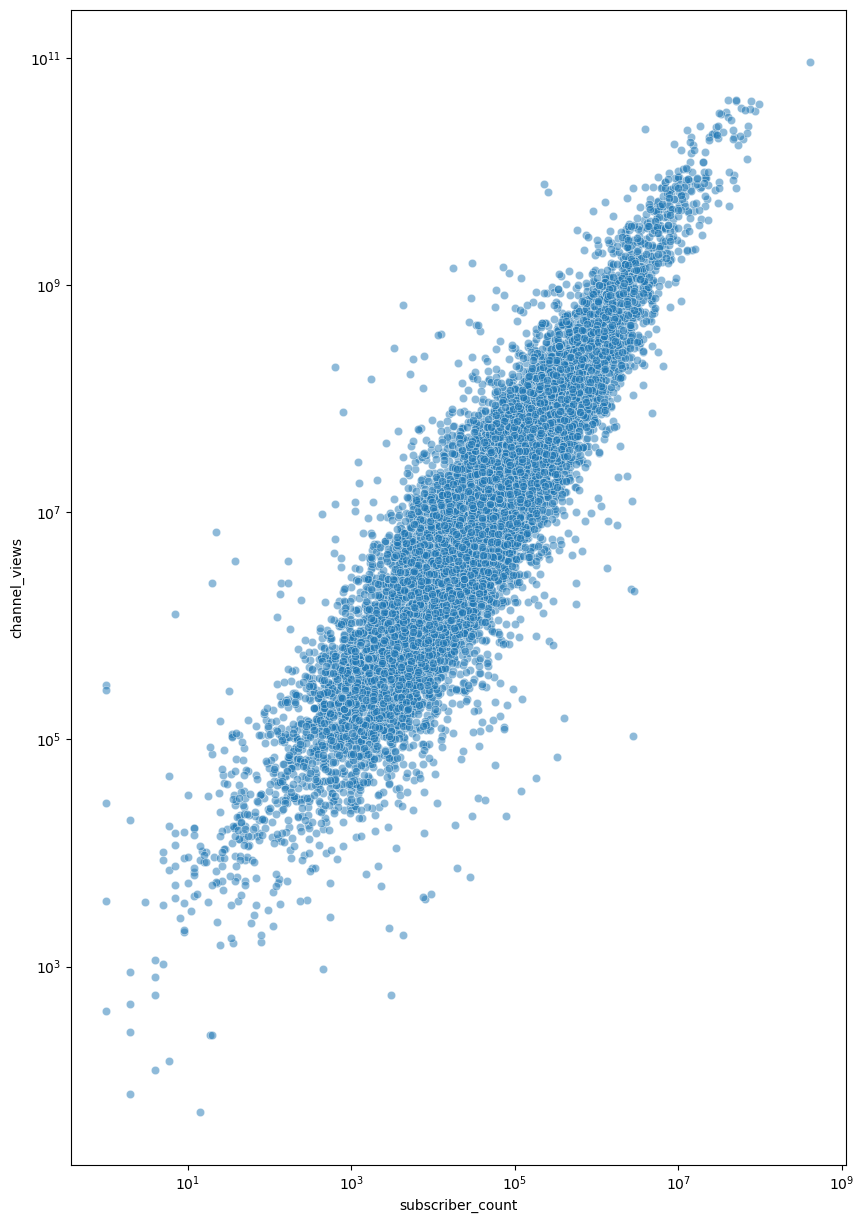

In [157]:

canal_stats3 = (
    df_1.groupby(["channel_id", "channel_title"], as_index=False)
    .agg(
        channel_views=("channel_views", "max"),
    
        subscriber_count=("subscriber_count", "max")
))
plt.figure(figsize=(10, 15))
sns.scatterplot(data=canal_stats3, x="subscriber_count", y="channel_views", alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.show()

El gráfico confirma que suscriptores y views están fuertemente correlacionados, lo cual es lógico: los canales con bases de seguidores más grandes tienden a acumular también más visualizaciones.

Sin embargo, la dispersión observada indica que los suscriptores no explican por completo el éxito en términos de views: hay canales que sobrepasan o quedan por debajo de la “línea esperada”, lo que abre la puerta a factores adicionales (algoritmo, viralización puntual, contenidos de nicho, etc.).

In [159]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19154 entries, 0 to 19153
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                19154 non-null  object             
 1   title                   19154 non-null  object             
 2   description             15337 non-null  object             
 3   published_at            19154 non-null  datetime64[ns, UTC]
 4   duration_minutes        19154 non-null  float64            
 5   definition              19154 non-null  int64              
 6   licensed_content        19154 non-null  Int64              
 7   has_caption             19154 non-null  Int64              
 8   category_id             19154 non-null  float64            
 9   views                   19154 non-null  int64              
 10  likes                   19154 non-null  int64              
 11  comments                19154 non-null  i

### ¿Qué canal es más eficiente en tiempo? (engagement acumulado dividido entre channel_age_days). ###

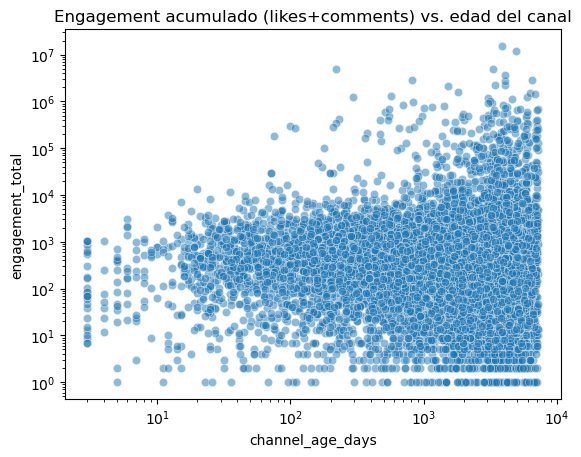

In [164]:
df_1["engagement_abs"] = df_1["likes"] + df_1["comments"]

canal_stats4 = (
    df_1.groupby(["channel_id", "channel_title"], as_index=False)
    .agg(
        engagement_total=("engagement_abs", "sum"),
        views_total=("views", "sum"),
        channel_age_days=("channel_age_days", "max")
    )
)

sns.scatterplot(data=canal_stats4, x="channel_age_days", y="engagement_total", alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.title("Engagement acumulado (likes+comments) vs. edad del canal")
plt.show()

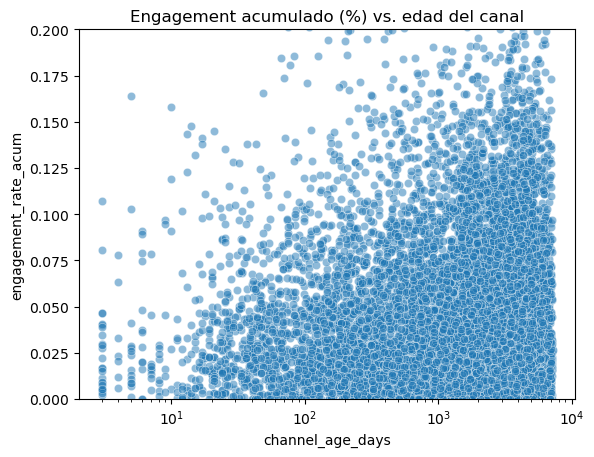

In [165]:
canal_stats4["engagement_rate_acum"] = canal_stats4["engagement_total"] / canal_stats4["views_total"].replace(0,1)

sns.scatterplot(data=canal_stats4, x="channel_age_days", y="engagement_rate_acum", alpha=0.5)
plt.xscale("log")
plt.ylim(0, 0.2)  # para no saturar el gráfico
plt.title("Engagement acumulado (%) vs. edad del canal")
plt.show()

Aunque existe mucha dispersión, los canales con más tiempo tienden a acumular también mayores niveles relativos de engagement.

Es decir, no solo suman más interacciones totales (como viste en el gráfico anterior), sino que también mantienen —o incluso mejoran— su eficiencia relativa en cuanto a interacciones por view.

## VIRALIDAD INESPERADA

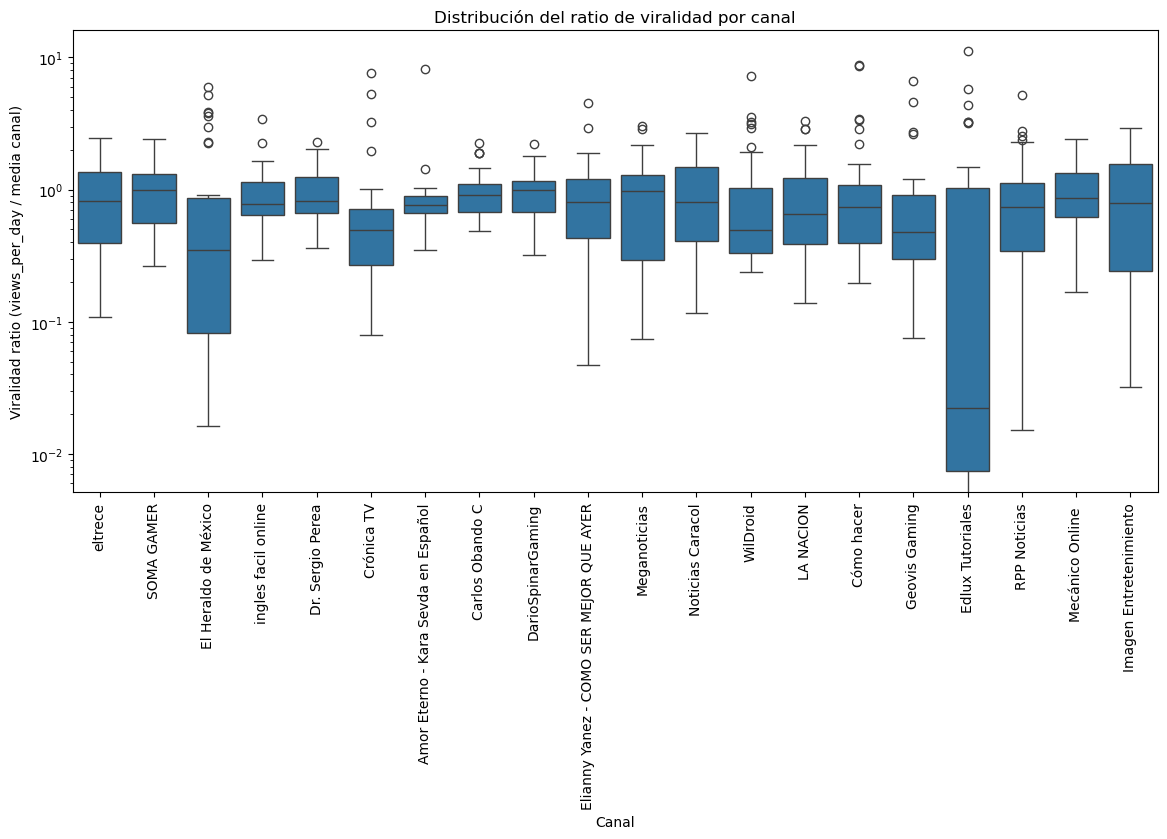

In [172]:
canal_mean = (
    df_1.groupby("channel_id", as_index=False)
    .agg(media_views_per_day=("views_per_day", "mean"))
)
df_viral = df_1.merge(canal_mean, on="channel_id", how="left")
df_viral["viralidad_ratio"] = df_viral["views_per_day"] / df_viral["media_views_per_day"]
umbral = df_viral["viralidad_ratio"].quantile(0.99)
videos_virales = df_viral[df_viral["viralidad_ratio"] >= umbral]
top_canales = df_viral["channel_id"].value_counts().nlargest(20).index
df_top = df_viral[df_viral["channel_id"].isin(top_canales)]

plt.figure(figsize=(14,6))
sns.boxplot(data=df_top, x="channel_title", y="viralidad_ratio")
plt.xticks(rotation=90)
plt.yscale("log")  # log para ver mejor los outliers
plt.title("Distribución del ratio de viralidad por canal")
plt.ylabel("Viralidad ratio (views_per_day / media canal)")
plt.xlabel("Canal")
plt.show()

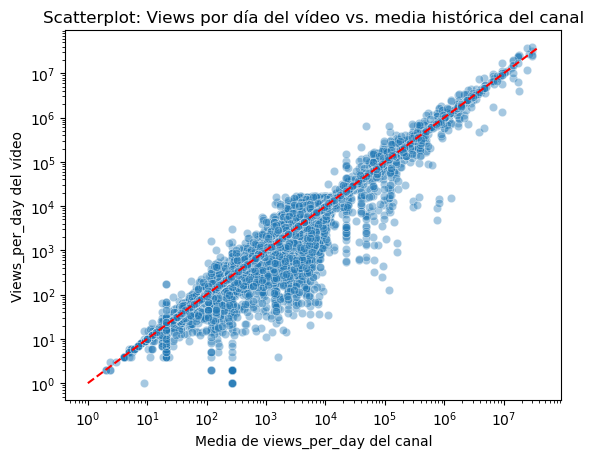

In [174]:
lim = max(df_viral["media_views_per_day"].max(), df_viral["views_per_day"].max())
plt.plot([1, lim], [1, lim], color="red", linestyle="--")
sns.scatterplot(data=df_viral, x="media_views_per_day", y="views_per_day", alpha=0.4)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Media de views_per_day del canal")
plt.ylabel("Views_per_day del vídeo")
plt.title("Scatterplot: Views por día del vídeo vs. media histórica del canal")
plt.show()

<Axes: xlabel='channel_id', ylabel='viralidad_ratio'>

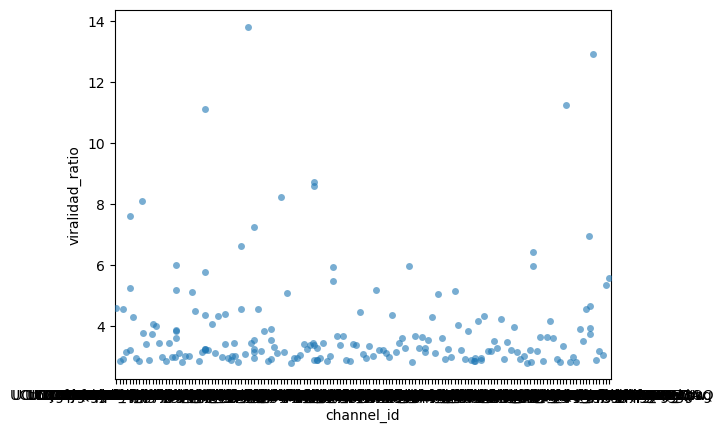

In [177]:
videos_virales = df_viral[df_viral["viralidad_ratio"] >= umbral]
sns.stripplot(data=videos_virales, x="channel_id", y="viralidad_ratio", jitter=True, alpha=0.6)

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_3945/2248404651.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=videos_virales, x="channel_title", y="viralidad_ratio", estimator="mean", ci=None)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127477 (\N{REGIONAL INDICATOR SYMBOL LETTER P}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


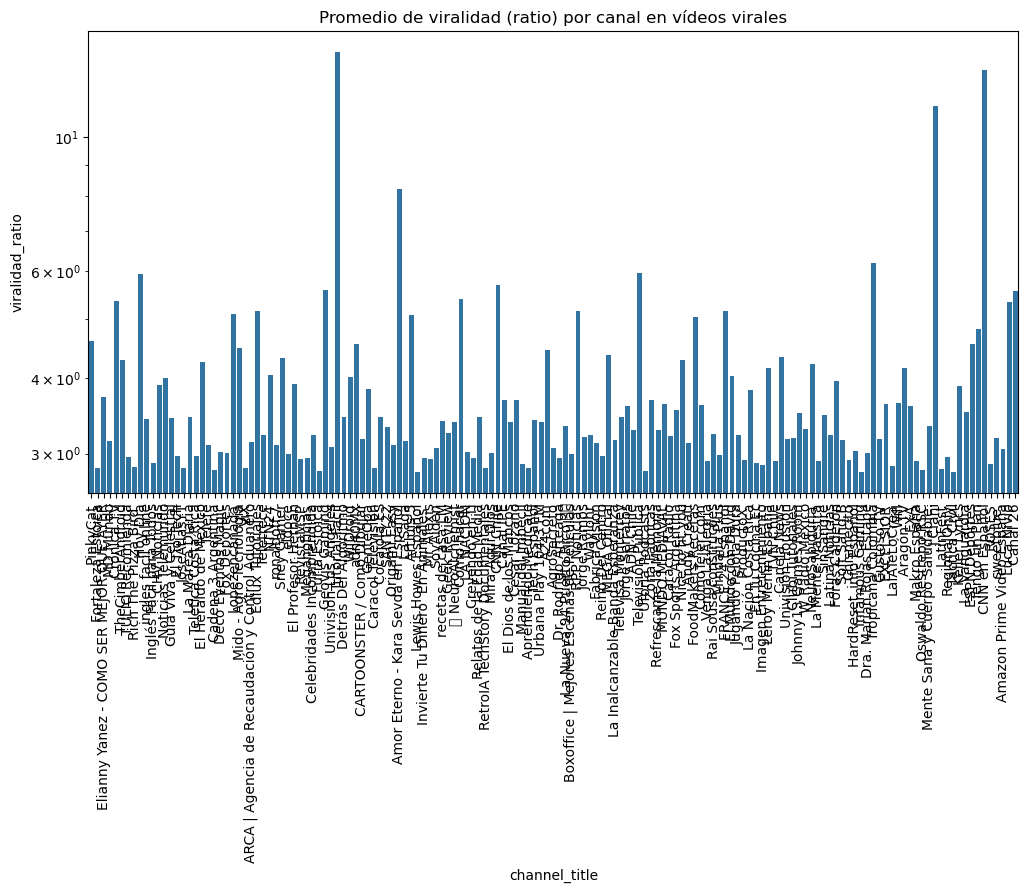

In [179]:
plt.figure(figsize=(12,6))
sns.barplot(data=videos_virales, x="channel_title", y="viralidad_ratio", estimator="mean", ci=None)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Promedio de viralidad (ratio) por canal en vídeos virales")
plt.show()

a Figura X muestra los canales cuyos vídeos se encuentran en el 1% superior del indicador viralidad_ratio, definido como el cociente entre las visualizaciones diarias de un vídeo y la media de visualizaciones diarias de todos los vídeos del canal.

En total se identificaron 192 vídeos en esta categoría. En la mayoría de los casos, estos vídeos superan entre 3 y 6 veces el promedio de rendimiento del canal, aunque existen casos excepcionales donde el ratio alcanza valores superiores a 10. Estos resultados evidencian la existencia de fenómenos de viralidad inesperada, en los que un único contenido se aleja significativamente del patrón habitual del canal y explica una parte desproporcionada de su impacto total.